# Tarea M10 MPAD de Gonz√°lez_Ram√≥n

# Problema machine learning: Detecci√≥n estilos de juego usando SVM


### Template para Desarrollo de Modelos siguiendo CRISP-DM

In [ ]:
## Importaci√≥n de bibliotecas necesarias

import numpy as np
import pandas as pd
import os
import json
import re
import io
from collections import defaultdict
from glob import glob
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as mpatches
from datetime import datetime  

# Configuraciones
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Comprensi√≥n del Negocio

### <u>Contexto deportivo</u>

**Para este punto inicial quiero comenzar por explicar el contexto deportivo por el cual me he decidido a realizar un an√°lisis de estilo de juego de los partidos del Atl√©tico de Madrid durante la liga 2024/25.**

Este f√∫tbol moderno ha evolucionado hacia un an√°lisis cada vez m√°s cuantitativo y basado en datos. Esto, antes era dominio exclusivo de la observaci√≥n cualitativa y la intuici√≥n de expertos, hoy se complementa con an√°lisis estad√≠stico avanzado y modelos predictivos. En este contexto, el Atl√©tico de Madrid representa un caso de estudio particularmente interesante para mi, donde cada partido es una muestra de la variabilidad en el estilo, idea, plan... o como queramos denominarlo, para minimizar al rival, y exponer las fortalezas propias.
Bajo la direcci√≥n t√©cnica de Diego Simeone desde 2011, el Atl√©tico ha mostrado una evoluci√≥n t√°ctica notable, pasando de un equipo reconocido principalmente por su solidez defensiva y juego directo, a un conjunto capaz de adaptar su estilo de juego seg√∫n el contexto competitivo. Por eso, esta adaptabilidad es precisamente lo que hace valioso utilizar t√©cnicas de machine learning para detectar, categorizar y analizar sus patrones t√°cticos.

### <u>Definici√≥n del Problema</u>

El problema que abordamos es la clasificaci√≥n autom√°tica de los estilos de juego del Atl√©tico de Madrid en cada partido de La Liga. Lo cual nos lleva a:

- Identificar, primero, las dimensiones t√°cticas relevantes que definen un estilo de juego (orientaci√≥n ofensiva/defensiva, tipo de ataque, presi√≥n, etc.);
- Cuantificar estas dimensiones mediante m√©tricas e √≠ndices objetivos perfectamente comprobables y que su elaboraci√≥n sea exigente y eshaustiva;
- Considerar factores contextuales que pueden influir en el estilo adoptado (expulsiones, goles, lesiones...);
- Crear un sistema de clasificaci√≥n que pueda asignar etiquetas de estilo para cada dimensi√≥n t√°ctica, o al menos, se acerque lo m√°s posible.

Este problema es fundamentalmente de clasificaci√≥n multiclase y multidimensional, ya que para cada partido necesitamos categorizar el estilo en varias dimensiones independientes pero relacionadas.

### <u>Objetivo del Proyecto</u>

El objetivo principal es desarrollar un modelo SVM (Support Vector Machine) que permita:

1.- Clasificar autom√°ticamente el estilo de juego del Atl√©tico en cada partido seg√∫n m√∫ltiples dimensiones t√°cticas, mediante la generaci√≥n de √çndices que nos ayuden a determinar:

- Orientaci√≥n general (ofensivo, defensivo, equilibrado);
- Fase ofensiva (posicional, vertical, directo);
- Patrones de ataque (bandas, pasillo central);
- Intensidad defensiva (presi√≥n alta, defensa pasiva);
- Altura del bloque (alto, medio, bajo).


2.- Analizar la evoluci√≥n t√°ctica del equipo a lo largo de la temporada, identificando patrones y tendencias.
3.- Evaluar el impacto de factores contextuales como:

- Rival (categor√≠a del oponente)
- Local√≠a (jugar como local o visitante)
- Eventos clave (expulsiones, goles tempranos)
- Resultado parcial


4.- Proporcionar insights t√°cticos que puedan ser valiosos para an√°lisis deportivo, periodismo especializado o entrenadores.

### <u>Justificaci√≥n modelo SVM</u>

He elegido un modelo SVM (Support Vector Machine) fundamentalmente por los siguientes motivos:

- Su eficacia en espacios de alta dimensionalidad: SVM es particularmente efectivo cuando trabajamos con m√∫ltiples variables e √≠ndices t√°cticos, manteniendo buen rendimiento incluso cuando el n√∫mero de caracter√≠sticas es elevado en comparaci√≥n con el n√∫mero de muestras (38 jornadas vs m√∫ltiples √≠ndices).
- Es capaz de establecer fronteras de decisi√≥n complejas: al usar diferentes kernels (lineal, RBF, polin√≥mico), SVM puede capturar relaciones no lineales entre los √≠ndices t√°cticos y los estilos de juego, adapt√°ndose a la complejidad que lleva dicho an√°lisis t√°ctico.
- Es muy robusto frente a posibles outliers: existen partidos con eventos at√≠picos (expulsiones tempranas, goleadas) pueden ser mejor manejados por SVM, especialmente con la adecuada configuraci√≥n del par√°metro de regularizaci√≥n C.
- Interpretabilidad con SVM lineal: si se usa un kernel lineal, se pueden interpretar los coeficientes del modelo para entender qu√© √≠ndices tienen mayor influencia en la clasificaci√≥n de cada estilo.
- Y su versatilidad para problemas multiclase: con estrategias como "uno contra todos" (OvA) o "uno contra uno" (OvO), SVM puede abordar eficazmente la naturaleza multiclase de nuestro problema t√°ctico.

### <u>Criterios de √©xito</u>


El √©xito del proyecto se evaluar√° seg√∫n:

- Precisi√≥n de la clasificaci√≥n: medida a trav√©s de m√©tricas como accuracy, precision, recall y F1-score para cada dimensi√≥n t√°ctica.
- Consistencia con el conocimiento experto: las clasificaciones deben tener sentido futbol√≠stico y alinearse con an√°lisis t√©cnicos reconocidos.
- Capacidad para detectar adaptaciones t√°cticas: el modelo debe identificar cambios de estilo seg√∫n el contexto (rival, resultado, etc.).
- Interpretabilidad de los resultados: los hallazgos deben ser f√°cilmente comprensibles para profesionales del deporte.
- Potencial anal√≠tico: las clasificaciones deben proporcionar insights valiosos sobre patrones t√°cticos temporada a temporada.

### <u>Recursos disponibles</u>

Para desarrollar este proyecto cuento con:

1.- Datos de eventos detallados por partido, por jornada (Ejemplo --> 1¬™_VIL-ATM_EventData.csv):

- Coordenadas espaciales (x, y) de cada acci√≥n;
- Tipo de evento (pase, tiro, recuperaci√≥n, etc.);
- Resultado de cada acci√≥n (exitosa/fallida);
- Atributos adicionales como longitud de pase, √°ngulo, etc.

2.- Datos contextuales y maestros:

- master_liga_atm.csv: informaci√≥n sobre partido con formato jornada, rival, resultado, expulsiones, minutos primer gol...
- stats_atm_por_partido.csv: estad√≠sticas agregadas de cada partido, b√°sicas como xG, pases completados...
- M√©tricas precalculadas: verticalidad, altura media del equipo.


3.- √çndices t√°cticos que desarrollaremos:

- √çndice de Iniciativa de Juego (IIJ);
- √çndice de Volumen de Juego Ofensivo (IVJO);
- √çndice de Progresi√≥n (EC);
- √çndice de Eficacia en finalizaci√≥n (EF);
- √çndice de Verticalidad (IV);
- √çndice de Presi√≥n Alta (IPA);
- √çndice de Juego Directo (IJD);
- √çndice de Amplitud (IA);
- √çndice de Densidad Defensiva (IDD);
- ¬ø√çndice de Complejidad en el Juego? (ICJ).

# 2. Comprensi√≥n de los Datos

## 2.1 Carga de Datos

In [53]:
# Funciones que leen los archivos de datos de ATM

def cargar_datos():
    """
    Carga todos los datasets necesarios para el an√°lisis y
    muestra informaci√≥n sobre su estructura y contenido
    
    Returns:
        dict: Diccionario con todos los datasets cargados
    """
    datasets = {}
    
    print("=== CARGA DE DATOS Y DESCRIPCI√ìN DE FUENTES ===")
    
    # 1. Carga datos maestros de partidos
    print("\n1. Datos maestros de partidos (master_liga_atm.csv):")
    try:
        # Intento con diferentes separadores
        try:
            master_liga = pd.read_csv("data/stats_jornadas/master_liga_atm.csv", sep=';')
            if master_liga.shape[1] <= 1:  # Si solo hay una columna, se intenta con coma
                master_liga = pd.read_csv("data/stats_jornadas/master_liga_atm.csv")
        except:
            master_liga = pd.read_csv("data/stats_jornadas/master_liga_atm.csv")
        
        datasets['master_liga'] = master_liga
        print(f"   ‚úì Archivo cargado correctamente: {master_liga.shape[0]} filas, {master_liga.shape[1]} columnas")
        
        # Informaci√≥n de columnas
        print("\n   Columnas disponibles:")
        for col in master_liga.columns:
            print(f"   - {col}: {master_liga[col].dtype}")
        
        # Primeras filas
        print("\n   Primeras 3 filas del dataset:")
        print(master_liga.head(3))
        
        print("\n   Descripci√≥n: Este archivo contiene informaci√≥n contextual de cada partido,")
        print("   incluyendo rival, resultado, m√©tricas t√°cticas (altura media, verticalidad),")
        print("   y eventos clave (goles, expulsiones) con sus minutos.")
    except Exception as e:
        print(f"   ‚úó Error al cargar master_liga_atm.csv: {e}")
    
    # 2. Estad√≠sticas por partido
    print("\n2. Estad√≠sticas por partido (stats_atm_por_partido.csv):")
    try:
        # Intento con diferentes enfoques de carga
        try:
            # Primero con punto y coma
            stats_partido = pd.read_csv("data/stats_jornadas/stats_atm_por_partido.csv", sep=';')
            
            # Si solo hay una columna, se intenta con coma
            if stats_partido.shape[1] <= 1:
                stats_partido = pd.read_csv("data/stats_jornadas/stats_atm_por_partido.csv")
        except:
            # Intentar directamente con coma
            stats_partido = pd.read_csv("data/stats_jornadas/stats_atm_por_partido.csv")
        
        datasets['stats_partido'] = stats_partido
        print(f"   ‚úì Archivo cargado correctamente: {stats_partido.shape[0]} filas, {stats_partido.shape[1]} columnas")
        
        # Informaci√≥n de columnas
        print("\n   Columnas disponibles:")
        print("   " + ", ".join(stats_partido.columns.tolist()))
        
        # Primeras filas
        print("\n   Primeras 5 filas del dataset:")
        print(stats_partido.head(5))
        
        print("\n   Descripci√≥n: Este archivo contiene estad√≠sticas detalladas por jornada,")
        print("   organizadas con m√©tricas en columnas y cada jornada en cada fila. Incluye datos de")
        print("   posesi√≥n, pases, tiros, xG, y m√∫ltiples m√©tricas ofensivas y defensivas.")
    except Exception as e:
        print(f"   ‚úó Error al cargar stats_atm_por_partido.csv: {e}")  
        
    # 3. Busca y carga archivos de eventos de ejemplo
    print("\n3. Datos de eventos en una jornada:")
    
    # Busca en la estructura de carpetas correcta
    root_dir = "data/stats_jornadas"
    jornadas_encontradas = []
    
    # Busca archivos directamente en stats_jornadas
    try:
        for file in os.listdir(root_dir):
            if "EventData" in file:
                jornada = file.split('_')[0]
                if jornada not in jornadas_encontradas:
                    jornadas_encontradas.append(jornada)
    except:
        pass
    
    # Busca en carpetas de jornada si no encontramos directamente
    if not jornadas_encontradas:
        try:
            for item in os.listdir(root_dir):
                item_path = os.path.join(root_dir, item)
                if os.path.isdir(item_path) and "jornada" in item.lower():
                    for file in os.listdir(item_path):
                        if "EventData" in file:
                            jornada = item.replace("jornada_", "")
                            if jornada not in jornadas_encontradas:
                                jornadas_encontradas.append(jornada)
        except:
            pass
    
    if jornadas_encontradas:
        print(f"   ‚úì Jornadas con datos disponibles: {', '.join(jornadas_encontradas)}")
        
        # Carga un ejemplo de la primera jornada encontrada
        ejemplo_jornada = jornadas_encontradas[0]
        
        # Determina la ruta correcta
        event_file_path = None
               
        # Busca en el directorio ra√≠z
        for file in os.listdir(root_dir):
            file_path = os.path.join(root_dir, file)
            if os.path.isfile(file_path):
                if ejemplo_jornada in file and "EventData" in file:
                    event_file_path = file_path
        
        # Si no encontramos, buscar en carpetas de jornada
        if not event_file_path:
            jornada_dir = os.path.join(root_dir, f"jornada_{ejemplo_jornada}")
            if os.path.exists(jornada_dir):
                for file in os.listdir(jornada_dir):
                    file_path = os.path.join(jornada_dir, file)
                    if "EventData" in file:
                        event_file_path = file_path
        
        # Carga y muestra datos de eventos
        if event_file_path:
            try:
                # Intenta diferentes separadores
                try:
                    eventos = pd.read_csv(event_file_path, sep=';')
                    if eventos.shape[1] <= 1:  # Si solo hay una columna, con coma
                        eventos = pd.read_csv(event_file_path)
                except:
                    eventos = pd.read_csv(event_file_path)
                
                datasets['eventos_ejemplo'] = eventos
                print(f"\n   4.1. Datos de eventos (archivo: {os.path.basename(event_file_path)}):")
                print(f"   ‚úì Dimensiones: {eventos.shape[0]} eventos, {eventos.shape[1]} columnas")
                
                # Muestra informaci√≥n de las columnas principales
                print("\n   Columnas principales:")
                main_cols = ['id', 'minute', 'teamId', 'x', 'y', 'type', 'outcomeType']
                for col in main_cols:
                    if col in eventos.columns:
                        print(f"   - {col}: {eventos[col].dtype}")
                
                # Muestra ejemplos de eventos
                print("\n   Primeros 3 eventos:")
                print(eventos.head(3))
                
                print("\n   Descripci√≥n: Este archivo contiene todos los eventos ocurridos durante el partido,")
                print("   con coordenadas espaciales (x,y), minuto, equipo, tipo de evento (pase, tiro, etc.)")
                print("   y resultado. Permite an√°lisis detallado de patrones t√°cticos.")
            except Exception as e:
                print(f"   ‚úó Error al cargar archivo de eventos: {e}")
        
    else:
        print("   ‚úó No se encontraron archivos de eventos")

    # 4. Datos archivo master equipos liga
    print("\n4. Datos maestros de equipos (equipos_laliga_master.csv):")
    try:
        # Intenta con diferentes separadores
        try:
            equipos = pd.read_csv("data/master/equipos_laliga_master.csv", sep=';')
            if equipos.shape[1] <= 1:  # Si solo hay una columna, con coma
                equipos = pd.read_csv("data/master/equipos_laliga_master.csv")
        except:
            equipos = pd.read_csv("data/master/equipos_laliga_master.csv")
        
        datasets['equipos'] = equipos
        print(f"   ‚úì Archivo cargado correctamente: {equipos.shape[0]} filas, {equipos.shape[1]} columnas")
        
        # Muestra informaci√≥n de columnas
        print("\n   Columnas disponibles:")
        for col in equipos.columns:
            print(f"   - {col}: {equipos[col].dtype}")
        
        # Muestra las primeras filas
        print("\n   Primeras 5 filas del dataset:")
        print(equipos.head(5))
        
        print("\n   Descripci√≥n: Este archivo contiene informaci√≥n de referencia sobre los equipos")
        print("   de La Liga, incluyendo nombres, identificadores y atributos que facilitan")
        print("   el mapeo con otros datasets.")
    except Exception as e:
        print(f"   ‚úó Error al cargar equipos_laliga_master.csv: {e}")
    
    # Informaci√≥n final
    print("\n=== RESUMEN DE FUENTES DE DATOS ===")
    print("1. master_liga_atm.csv: Datos contextuales de partidos (38 jornadas)")
    print("2. stats_atm_por_partido.csv: Estad√≠sticas detalladas por jornada")
    print("3. Archivos por jornada: Datos de eventos a nivel micro")
    print("4. equipos_laliga_master.csv: Informaci√≥n de referencia de equipos")
    
    print("\nCon estas fuentes complementarias, podremos analizar el estilo de juego del")
    print("Atl√©tico de Madrid desde m√∫ltiples perspectivas: t√°cticas generales, patrones")
    print("ofensivos/defensivos y comportamiento espacial en el campo.")
    
    return datasets

# Cargar todos los datos disponibles
datos = cargar_datos()

# Asigno cada dataset a una variable independiente para facilitar la exploraci√≥n 
df_master_liga = datos.get('master_liga')
df_stats_partido = datos.get('stats_partido') 
df_eventos_ej = datos.get('eventos_ejemplo')
df_equipos = datos.get('equipos')

print("\nDatasets asignados a variables individuales para exploraci√≥n interactiva:")
print(f"- master_liga: {df_master_liga.shape if isinstance(df_master_liga, pd.DataFrame) else 'No disponible'}")
print(f"- stats_partido: {df_stats_partido.shape if isinstance(df_stats_partido, pd.DataFrame) else 'No disponible'}")
print(f"- eventos_ejemplo: {df_eventos_ej.shape if isinstance(df_eventos_ej, pd.DataFrame) else 'No disponible'}")
print(f"- equipos: {df_equipos.shape if isinstance(df_equipos, pd.DataFrame) else 'No disponible'}")

=== CARGA DE DATOS Y DESCRIPCI√ìN DE FUENTES ===

1. Datos maestros de partidos (master_liga_atm.csv):
   ‚úì Archivo cargado correctamente: 38 filas, 18 columnas

   Columnas disponibles:
   - jornada: object
   - formato_jornada: object
   - equipo_local: object
   - equipo_visitante: object
   - fecha: object
   - local_visitante: object
   - rival: object
   - resultado: object
   - altura_media: float64
   - verticalidad: object
   - goles_a_favor: float64
   - goles_en_contra: float64
   - min_primer_gol_a_favor: float64
   - min_primer_gol_en_contra: float64
   - expulsion_propia: float64
   - expulsion_rival: float64
   - min_expulsion_propia: float64
   - min_expulsion_rival: float64

   Primeras 3 filas del dataset:
  jornada formato_jornada        equipo_local    equipo_visitante       fecha  \
0      1¬™      1¬™_VIL-ATM       Villarreal CF  Atletico de Madrid  19/08/2024   
1      2¬™      2¬™_ATM-GIR  Atletico de Madrid           Girona FC  25/08/2024   
2      3¬™      3

**Carga de datos y muestra m√≠nima de como tengo estructurados los 4 archivos que entiendo, utilizaremos para el proyecto**

## 2.2 An√°lisis Exploratorio


#### <u>Creo una funci√≥n que expone la informaci√≥n de los archivos</u>

In [54]:
def analisis_exploratorio(df, nombre_df="Dataset"):
    """
    Realizar an√°lisis exploratorio inicial
    
    Args:
        df: DataFrame a analizar
        nombre_df: Nombre descriptivo del DataFrame
    """
    print(f"\n=== AN√ÅLISIS EXPLORATORIO: {nombre_df} ===\n")
    
    # Info b√°sica
    print("Informaci√≥n del Dataset:")
    print(df.info())
    
    # Estad√≠sticas descriptivas (solo para columnas num√©ricas)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print("\nEstad√≠sticas Descriptivas (columnas num√©ricas):")
        print(df[numeric_cols].describe())
    
    # Valores faltantes
    print("\nValores Faltantes:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No hay valores faltantes en el dataset")
    
    return None

# Aplico la funci√≥n a cada uno de los dataframes
print("\n" + "="*70)
print("AN√ÅLISIS EXPLORATORIO DE DATOS")
print("="*70)

# Df master_liga
analisis_exploratorio(df_master_liga, "MASTER LIGA")

# Df stats_partido
analisis_exploratorio(df_stats_partido, "ESTAD√çSTICAS POR PARTIDO")

# DF eventos_ejemplo (probando si est√° disponible)
if 'df_eventos_ej' in locals() and isinstance(df_eventos_ej, pd.DataFrame):
    analisis_exploratorio(df_eventos_ej, "EVENTOS EJEMPLO")
else:
    print("\n=== AN√ÅLISIS EXPLORATORIO: EVENTOS EJEMPLO ===\n")
    print("No hay datos de eventos disponibles para analizar")

# DF equipos
analisis_exploratorio(df_equipos, "EQUIPOS")


AN√ÅLISIS EXPLORATORIO DE DATOS

=== AN√ÅLISIS EXPLORATORIO: MASTER LIGA ===

Informaci√≥n del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   jornada                   38 non-null     object 
 1   formato_jornada           38 non-null     object 
 2   equipo_local              38 non-null     object 
 3   equipo_visitante          38 non-null     object 
 4   fecha                     29 non-null     object 
 5   local_visitante           38 non-null     object 
 6   rival                     38 non-null     object 
 7   resultado                 29 non-null     object 
 8   altura_media              29 non-null     float64
 9   verticalidad              29 non-null     object 
 10  goles_a_favor             29 non-null     float64
 11  goles_en_contra           29 non-null     float64
 12  min_primer_gol_a_

In [55]:
df_master_liga.head(3)

jornada formato_jornada        equipo_local    equipo_visitante       fecha  \
0      1¬™      1¬™_VIL-ATM       Villarreal CF  Atletico de Madrid  19/08/2024   
1      2¬™      2¬™_ATM-GIR  Atletico de Madrid           Girona FC  25/08/2024   
2      3¬™      3¬™_ATM-ESP  Atletico de Madrid         RCD Espa√±ol  28/08/2024   

  local_visitante          rival resultado  altura_media verticalidad  \
0               V  Villarreal CF       2-2         50.46       44.27%   
1               L      Girona FC       3-0         49.84       45.89%   
2               L    RCD Espa√±ol       0-0         57.79       41.39%   

   goles_a_favor  goles_en_contra  min_primer_gol_a_favor  \
0            2.0              2.0                    20.0   
1            3.0              0.0                    39.0   
2            0.0              0.0                     0.0   

   min_primer_gol_en_contra  expulsion_propia  expulsion_rival  \
0                      18.0               0.0              0.0   
1                       0.0               0.0              0.0   
2                       0.0               0.0              0.0   

   min_expulsion_propia  min_expulsion_rival  
0                   0.0                  0.0  
1                   0.0                  0.0  
2                   0.0                  0.0

In [56]:
df_stats_partido.head(3)

jornada  posesion  pases pases_precisos  pases_campo_propio  \
0        1        55    592      519 (88%)                 304   
1        2        42    462      404 (87%)                 214   
2        3        62    595      523 (88%)                 223   

   pases_campo_rival pases_largos_precisos centros_precisos  \
0                215              19 (56%)          7 (47%)   
1                190              28 (55%)          1 (17%)   
2                300              29 (67%)          9 (32%)   

   toques_area_rival regates_exitosos  tiros_totales  tiros_puerta  \
0                 24          8 (73%)              9             4   
1                 19          5 (45%)             11             6   
2                 39          6 (60%)             25             7   

   tiros_palos  tiros_fuera  tiros_bloqueados  tiros_bloqueados.1  \
0            1            4                 1                   2   
1            0            2                 3                   5   
2            1           10                 8                   0   

   tiros_bloqueados.2  tiros_bloqueados.3  tiros_bloqueados.4  \
0                   1                   2                   1   
1                   3                   5                   3   
2                   8                   0                   8   

   tiros_bloqueados.5  tiros_bloqueados.6  tiros_bloqueados.7  \
0                   2                   1                   2   
1                   5                   3                   5   
2                   0                   8                   0   

   tiros_dentro_area  tiros_fuera_area    xG  xG_juego_abierto  \
0                  7                 2  1.11              1.09   
1                  6                 5  1.22              1.09   
2                 18                 7  2.47              1.98   

   xG_balon_parado  xG_sin_penaltis  xG_porteria  ocasiones_claras  \
0             0.02             1.11         0.38                 3   
1             0.13             1.22         1.43                 1   
2             0.48             2.47         1.36                 5   

   ocasiones_claras_falladas  duelos_ganados duelos_suelo_ganados  \
0                          2              39             31 (47%)   
1                          0              46             38 (52%)   
2                          5              42             25 (50%)   

  duelos_aereos_ganados entradas_exitosas  interceptaciones  despejes  \
0               8 (57%)           9 (53%)                 2         9   
1               8 (53%)          15 (65%)                10        33   
2              17 (52%)           8 (80%)                 5        15   

   tiros_bloqueados.8  tiros_bloqueados.9  tiros_bloqueados.10  \
0                   1                   2                    1   
1                   3                   5                    3   
2                   8                   0                    8   

   tiros_bloqueados.11  tiros_bloqueados.12  tiros_bloqueados.13  \
0                    2                    1                    2   
1                    5                    3                    5   
2                    0                    8                    0   

   tiros_bloqueados.14  tiros_bloqueados.15  paradas_portero  \
0                    1                    2                2   
1                    3                    5                4   
2                    8                    0                1   

   faltas_cometidas  corners  fueras_juego  saques_banda  tarj_amar  tarj_roj  
0                12        3             2            19          3         0  
1                11        1             2            15          1         0  
2                 6        9             6            28          0         0

In [57]:
df_eventos_ej.head(3)

Unnamed: 0            id  eventId  minute  second  teamId     x     y  \
0           0  2.736476e+09        2       0     0.0     825   0.0   0.0   
1           1  2.736476e+09        2       0     0.0      63   0.0   0.0   
2           2  2.736477e+09        3       0     0.0     825  49.2  50.0   

   expandedMinute                                    period  \
0               0  {'value': 1, 'displayName': 'FirstHalf'}   
1               0  {'value': 1, 'displayName': 'FirstHalf'}   
2               0  {'value': 1, 'displayName': 'FirstHalf'}   

                                    type  \
0  {'value': 32, 'displayName': 'Start'}   
1  {'value': 32, 'displayName': 'Start'}   
2    {'value': 1, 'displayName': 'Pass'}   

                                 outcomeType  \
0  {'value': 1, 'displayName': 'Successful'}   
1  {'value': 1, 'displayName': 'Successful'}   
2  {'value': 1, 'displayName': 'Successful'}   

                                          qualifiers  \
0                                                 []   
1                                                 []   
2  [{'type': {'value': 213, 'displayName': 'Angle...   

              satisfiedEventsTypes  isTouch  playerId  endX  endY  blockedX  \
0                               []    False       NaN   NaN   NaN       NaN   
1                               []    False       NaN   NaN   NaN       NaN   
2  [91, 117, 30, 35, 37, 215, 218]     True  334221.0  33.2  51.3       NaN   

   blockedY  goalMouthZ  goalMouthY isShot  relatedEventId  relatedPlayerId  \
0       NaN         NaN         NaN    NaN             NaN              NaN   
1       NaN         NaN         NaN    NaN             NaN              NaN   
2       NaN         NaN         NaN    NaN             NaN              NaN   

  cardType isGoal  
0      NaN    NaN  
1      NaN    NaN  
2      NaN    NaN

In [58]:
df_equipos.head(3)

nombre  shortname   id_streamlit  \
0    Deportivo Alaves        ALA              1   
1  Atletico de Madrid        ATM              2   
2       Athletic Club        ATH              3   

                                           url_fbref   id_whoscored  \
0  https://fbref.com/es/equipos/8d6fd021/Estadist...             60   
1  https://fbref.com/es/equipos/db3b9613/Estadist...             63   
2  https://fbref.com/es/equipos/2b390eca/Estadist...             53   

    id_fotmob                                     id_understat  id_sofascore  \
0        9866           https://understat.com/team/Alaves/2024          2885   
1        9906  https://understat.com/team/Atletico_Madrid/2024          2836   
2        8315    https://understat.com/team/Athletic_Club/2024          2825   

   id_transfermarkt               ruta_escudo  
0              1108  'assets/escudos/ala.png'  
1                13  'assets/escudos/atm.png'  
2               621  'assets/escudos/ath.png'

#### <u>Conclusiones an√°lisis exploratorio</u>

1. df_master_liga (master_liga_atm.csv): 
-   Faltantes porque solo se han disputado 29 jornadas, y el resto son de las que quedan por disputar.
-   Resultado est√° en object, y ver formatos o errroes, y crear√© columna que certifique empate, victoria o derrota.
-   Verticalidad tambi√©n est√° en object y debo pasarlo a num√©rico, y quitar el signo de porcentaje.
-   Resto de columnas num√©ricas quitar decimales, excepto verticalidad y altura media.

2. df_stats_partido (stats_atm_por_partido.csv):
-   Solo son 30 filas, por solo disputarse esos 29 partidos. 
-   Las filas de las siguientes variables (pases_precisos, pases_largos_precisos, centros_precisos, regates_exitosos, duelos_suelos_ganados, duelos_aereos_ganados, y entradas_exitosas) contienen tras el dato, y entre par√©ntesis, el porcentaje de √©xito en dicha m√©trica. Se generar√°n las columnas nuevas con el signo % previo a la m√©trica en cuesti√≥n, y se extraer√°n los valores. Un ejemplo puede ser en la primera jornada que tiene este dato como "regates_exitosos" --> 8 (73%) , y la nueva variable llamada "%regates_exitosos" tendr√≠a este otro "73.0". 
-   Es necesario eliminar las columnas duplicadas de "tiros_bloqueados".

3. df_eventos_ej (1¬™_VIL-ATM_EventData.csv):
-   Aunque hay muchos eventos faltantes, para lo que haremos, que ser√° filtrar y crear un archivo maestro que contenga la info deseada por partido, no ser√≠a necesario rellenar con n√∫meros o eliminar.
-   Filtraremos por id de equipo (63 para el Atleti), y seleccionaremos las columnas que queremos (teamId, minute, second, x, y, type que cambiar√© a tipo_evento, outcomeType que convertir√© a resultado_evento m√°s legible, endX y endY para los eventos que los tengan, isTouch).
-   Transformar el Json de la columna type, cuya informaci√≥n es b√°sica para muchos de los datos.

4. df_equipos (equipos_laliga_master.csv):
-   No requiere transformaciones, ya que es solo para cruzar informaci√≥n.

## 2.3 Visualizaciones Iniciales

### <u>Visualizaciones elegidas</u>

1. Scatter plot donde lo primero que quiero mostrar es la relaci√≥n entre verticalidad y altura media, y que se enfrenta con resultados de los partidos.
2. Heatmap de correlaci√≥n para detectar esta en m√©tricas clave, ayudando a detectar factores adyacentes.
3. Gr√°fico de l√≠neas que igualmente nos mostrar√° la evoluci√≥n t√°ctica a lo largo de la temporada.
4. Box plots de comparativa para mostrar diferencias entre local y visitante.
5. Y repetir de nuevo otro Box Plot por ver qu√© m√©tricas nos pueden ayudar a discriminar mejor entre victorias, empates y derrotas.

In [59]:
def visualizaciones_iniciales(datos):
    """
    Crear visualizaciones exploratorias para an√°lisis t√°ctico
    
    Args:
        datos: Diccionario con los datasets cargados (master_liga, stats_partido, etc.)
    """
    print("\n=== VISUALIZACIONES INICIALES DE AN√ÅLISIS T√ÅCTICO ===\n")
    
    # 1. Scatter plot: Verticalidad vs Altura Media
    print("1. Visualizaci√≥n de relaci√≥n entre verticalidad y altura media")
    if 'master_liga' in datos:
        df = datos['master_liga'].copy()
        
        if 'verticalidad' in df.columns and 'altura_media' in df.columns:
            sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
            
            df['verticalidad_num'] = df['verticalidad'].str.rstrip('%').astype(float)
            
            df['resultado_tipo'] = df.apply(
                lambda row: 'Victoria' if row['goles_a_favor'] > row['goles_en_contra'] 
                else ('Empate' if row['goles_a_favor'] == row['goles_en_contra'] else 'Derrota'),
                axis=1
            )
            
            colors = {'Victoria': 'green', 'Empate': '#ff7f0e', 'Derrota': 'red'}
            
            # Scatter plot
            plt.figure(figsize=(12, 8), facecolor="#E6E6E6")
            ax = plt.gca()
            
            for resultado, grupo in df.groupby('resultado_tipo'):
                plt.scatter(
                    grupo['verticalidad_num'], grupo['altura_media'],
                    label=resultado, color=colors[resultado], alpha=0.7, s=100,
                    edgecolor='darkblue', linewidth=1.5
                )
            
            # A√±ado etiquetas de jornada
            for _, row in df.iterrows():
                plt.annotate(
                    f"{row['formato_jornada']}", 
                    (row['verticalidad_num'], row['altura_media']),
                    xytext=(5, 0), textcoords='offset points',
                    fontsize=9, color='darkblue', fontweight='bold'
                )
            
            # Fondo y bordes
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            
            # Personalizo cuadr√≠cula
            ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # T√≠tulos y etiquetas
            plt.title('Relaci√≥n entre verticalidad y altura media', fontsize=16, color='darkblue', fontweight='bold')
            plt.xlabel('Verticalidad (%)', fontsize=14, color='darkblue')
            plt.ylabel('Altura Media', fontsize=14, color='darkblue')
            plt.tick_params(axis='both', colors='darkblue')
            
            # Leyenda
            legend = plt.legend(title='Resultado', frameon=True, labelcolor='darkblue')
            legend.get_frame().set_edgecolor('darkblue')
            legend.get_frame().set_linewidth(1)
            plt.setp(legend.get_title(), color='darkblue')
            
            plt.tight_layout()
            plt.show()
    
    # 2. Heatmap de correlaci√≥n entre m√©tricas clave
    print("\n2. Heatmap de correlaci√≥n entre m√©tricas t√°cticas clave")
    if 'stats_partido' in datos:
        try:
            stats = datos['stats_partido'].copy()
            
            # M√©tricas elegidas
            metricas_clave = ['posesion', 'pases', 'pases_campo_rival','toques_area_rival', 'tiros_totales', 'xG', 'duelos_ganados', 'interceptaciones']
            
            # Dataframe de correlaci√≥n
            df_corr = pd.DataFrame()
            
            for col in metricas_clave:
                if col in stats.columns:
                    
                    df_corr[col] = pd.to_numeric(stats[col], errors='coerce')
            
            if not df_corr.empty:
                # Calculo de matriz
                corr_matrix = df_corr.corr()
                
                sns.set_style("white")
                
                # Visualizar heatmap
                plt.figure(figsize=(10, 8), facecolor="#E6E6E6")
                ax = plt.gca()
                
                # Mask para mostrar solo la mitad superior
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                
                heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
                            fmt='.2f', mask=mask, cbar_kws={"shrink": .8})
                
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                    spine.set_color('darkblue')
                    spine.set_linewidth(1.5)
                
                cbar = heatmap.collections[0].colorbar
                cbar.ax.tick_params(colors='darkblue')
                plt.title('Correlaci√≥n entre m√©tricas elegidas', fontsize=16, color='darkblue', 
                        fontweight='bold')
                plt.xticks(color='darkblue', fontweight='bold')
                plt.yticks(color='darkblue', fontweight='bold')
                
                for pos in ['top', 'bottom', 'right', 'left']:
                    plt.gca().spines[pos].set_color('darkblue')
                    plt.gca().spines[pos].set_linewidth(1)
                
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Error al crear heatmap: {e}")
    
    # 3. Gr√°fico de l√≠neas: Evoluci√≥n t√°ctica
    print("\n3. Gr√°fico de evoluci√≥n de m√©tricas t√°cticas a lo largo de la temporada")
    if 'stats_partido' in datos and 'master_liga' in datos:
        try:
            sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
            
            stats = datos['stats_partido'].copy()
            
            # M√©tricas de inter√©s
            metricas_evolucion = ['posesion', 'xG']
            
            # Creaci√≥n figura
            plt.figure(figsize=(14, 8), facecolor="#E6E6E6")
            ax = plt.gca()
            
            for metrica in metricas_evolucion:
                if metrica in stats.columns:
                    valores = pd.to_numeric(stats[metrica], errors='coerce')
                    plt.plot(valores.index, valores, 'o-', linewidth=2, label=metrica,
                            marker='o', markersize=8, markeredgecolor='darkblue', markeredgewidth=1.5)
            
            # Verticalidad desde master_liga
            df_master = datos['master_liga'].copy()
            df_master['jornada_num'] = pd.to_numeric(df_master['jornada'].str.replace('¬™', ''), errors='coerce')
            df_master['verticalidad_num'] = df_master['verticalidad'].str.rstrip('%').astype(float)
            
            # Orden por jornada
            df_master = df_master.sort_values('jornada_num')
            
            # Plot de verticalidad
            plt.plot(df_master['jornada_num'], df_master['verticalidad_num'], 'o-', 
                    linewidth=2, label='Verticalidad (%)',
                    marker='o', markersize=8, markeredgecolor='darkblue', markeredgewidth=1.5)
            
            # Se a√±ade referencia de resultados
            for i, row in df_master.iterrows():
                color = 'green' if row['goles_a_favor'] > row['goles_en_contra'] else ('blue' if row['goles_a_favor'] == row['goles_en_contra'] else 'red')
                plt.axvline(x=row['jornada_num'], color=color, alpha=0.2)
            
            # Fondo y los bordes
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1.5)
            
            plt.grid(True, axis='both', color='lightgray', linestyle='-', alpha=0.7)
            
            # T√≠tulo y etiquetas
            plt.title('Evoluci√≥n de m√©tricas durante la temporada', fontsize=16, 
                    color='darkblue', fontweight='bold')
            plt.xlabel('Jornada', fontsize=14, color='darkblue')
            plt.ylabel('Valor', fontsize=14, color='darkblue')
            plt.tick_params(axis='both', colors='darkblue')
            
            legend = plt.legend(frameon=True)
            legend.get_frame().set_edgecolor('darkblue')
            legend.get_frame().set_linewidth(1)
            
            plt.xticks(df_master['jornada_num'])
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al crear gr√°fico de evoluci√≥n: {e}")
    
    # 4. Box plot comparativas local-visitante
    print("\n4. Comparaci√≥n de m√©tricas si local o visitante")
    if 'master_liga' in datos and 'stats_partido' in datos:
        try:
            df_master = datos['master_liga'].copy()
            df_master['jornada_num'] = pd.to_numeric(df_master['jornada'].str.replace('¬™', ''), errors='coerce')
            
            stats = datos['stats_partido'].copy()
            
            # Uni√≥n de datasets
            df_unidos = pd.merge(
                df_master[['jornada_num', 'local_visitante']], 
                stats, 
                left_on='jornada_num', 
                right_index=True,
                how='inner'
            )
            
            # M√©tricas para comparar
            metricas_comparar = ['posesion', 'pases', 'xG', 'duelos_ganados', 'despejes', 'faltas_cometidas']
            metricas_disponibles = [m for m in metricas_comparar if m in df_unidos.columns]
            
            if metricas_disponibles:
                # Estilo
                sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
                
                # Figura
                plt.figure(figsize=(12, 6), facecolor="#E6E6E6")
                
                # Subplots
                n_cols = 3
                n_rows = (len(metricas_disponibles) + 1) // 3
                
                for i, metrica in enumerate(metricas_disponibles, 1):
                    ax = plt.subplot(n_rows, n_cols, i)
                    
                    df_unidos[metrica] = pd.to_numeric(df_unidos[metrica], errors='coerce')
                    
                    boxplot = sns.boxplot(x='local_visitante', y=metrica, data=df_unidos,
                                order=['L', 'V'], palette={'L': 'darkgreen', 'V': 'red'}, 
                                flierprops={'markerfacecolor': 'darkblue', 'markersize': 6})
                    
                    # Todos los elementos del boxplot
                    for patch in ax.artists:
                        r, g, b, a = patch.get_facecolor()
                        patch.set_edgecolor('darkblue')
                        patch.set_linewidth(1)
                    
                    for line in ax.get_lines():
                        line.set_color('darkblue')
                        line.set_linewidth(1)
                    
                    ax.set_facecolor('white')
                    for spine in ax.spines.values():
                        spine.set_color('darkblue')
                        spine.set_linewidth(1)
                    
                    ax.grid(True, axis='y', color='lightgray', linestyle='-', alpha=0.7)
                    
                    # T√≠tulo y etiquetas
                    ax.set_title(f'{metrica}', fontsize=12, color='darkblue', weight='bold')
                    ax.set_xlabel('')
                    ax.set_ylabel('')
                    ax.tick_params(axis='both', colors='darkblue')
                
                plt.suptitle('Comparaci√≥n de M√©tricas seg√∫n Local√≠a', fontsize=16, color='darkblue', weight='bold')
                plt.tight_layout()
                plt.subplots_adjust(top=0.9)
                plt.show()
            else:
                print("No se encontraron las m√©tricas necesarias para la comparaci√≥n")
        except Exception as e:
            print(f"Error al crear visualizaci√≥n por local√≠a: {e}")
    else:
        print("No se encuentran los datasets necesarios")
    
    # 5. Box plots por resultado
    print("\n5. Distribuci√≥n de m√©tricas seg√∫n resultado")
    if 'master_liga' in datos and 'stats_partido' in datos:
        try:
            df_master = datos['master_liga'].copy()
            df_master['jornada_num'] = pd.to_numeric(df_master['jornada'].str.replace('¬™', ''), errors='coerce')
            
            # Columna de resultado
            df_master['resultado_tipo'] = df_master.apply(
                lambda row: 'Victoria' if row['goles_a_favor'] > row['goles_en_contra'] 
                else ('Empate' if row['goles_a_favor'] == row['goles_en_contra'] else 'Derrota'),
                axis=1
            )
            
            stats = datos['stats_partido'].copy()
            
            # Uni√≥n de datasets
            df_unidos = pd.merge(
                df_master[['jornada_num', 'resultado_tipo']], 
                stats, 
                left_on='jornada_num', 
                right_index=True,
                how='inner'
            )
            
            # Columnas a num√©rico
            numeric_cols = ['posesion', 'xG', 'tiros_totales', 'duelos_ganados']
            available_cols = [col for col in numeric_cols if col in df_unidos.columns]
            
            if available_cols:
                # Estilo
                sns.set_style("whitegrid", {'grid.color': '#E6E6E6'})
                
                for col in available_cols:
                    df_unidos[col] = pd.to_numeric(df_unidos[col], errors='coerce')
                
                # Visualizaci√≥n
                plt.figure(figsize=(12, 6), facecolor="#E6E6E6")
                
                for i, col in enumerate(available_cols, 1):
                    ax = plt.subplot(2, 2, i)
                    
                    # Boxplot con personalizaci√≥n
                    boxplot = sns.boxplot(x='resultado_tipo', y=col, data=df_unidos, 
                                palette={'Victoria': 'green', 'Empate': '#ff7f0e', 'Derrota': 'red'},
                                flierprops={'markerfacecolor': 'darkblue', 'markersize': 6})
                    
                    # Elementos del boxplot
                    for patch in ax.artists:
                        r, g, b, a = patch.get_facecolor()
                        patch.set_edgecolor('darkblue')
                        patch.set_linewidth(1)
                    
                    for line in ax.get_lines():
                        line.set_color('darkblue')
                        line.set_linewidth(1)
                    
                    ax.set_facecolor('white')
                    for spine in ax.spines.values():
                        spine.set_color('darkblue')
                        spine.set_linewidth(1)
                    
                    ax.grid(True, axis='y', color='lightgray', linestyle='-', alpha=0.7)
                    
                    # T√≠tulo y etiquetas
                    ax.set_title(f'{col}', fontsize=14, color='darkblue', weight='bold')
                    ax.set_xlabel('')
                    ax.set_ylabel('')
                    ax.tick_params(axis='both', colors='darkblue')
                
                plt.suptitle('Distribuci√≥n de m√©tricas seg√∫n resultado', fontsize=16, color='darkblue', weight='bold')
                plt.tight_layout()
                plt.subplots_adjust(top=0.9)
                plt.show()
            else:
                print("No se encontraron las m√©tricas necesarias para el an√°lisis")
        except Exception as e:
            print(f"Error al crear boxplots por resultado: {e}")
    else:
        print("No se encuentran los datasets necesarios")

    print("\n=== VISUALIZACIONES COMPLETADAS ===")
    return


=== VISUALIZACIONES INICIALES DE AN√ÅLISIS T√ÅCTICO ===

1. Visualizaci√≥n de relaci√≥n entre verticalidad y altura media


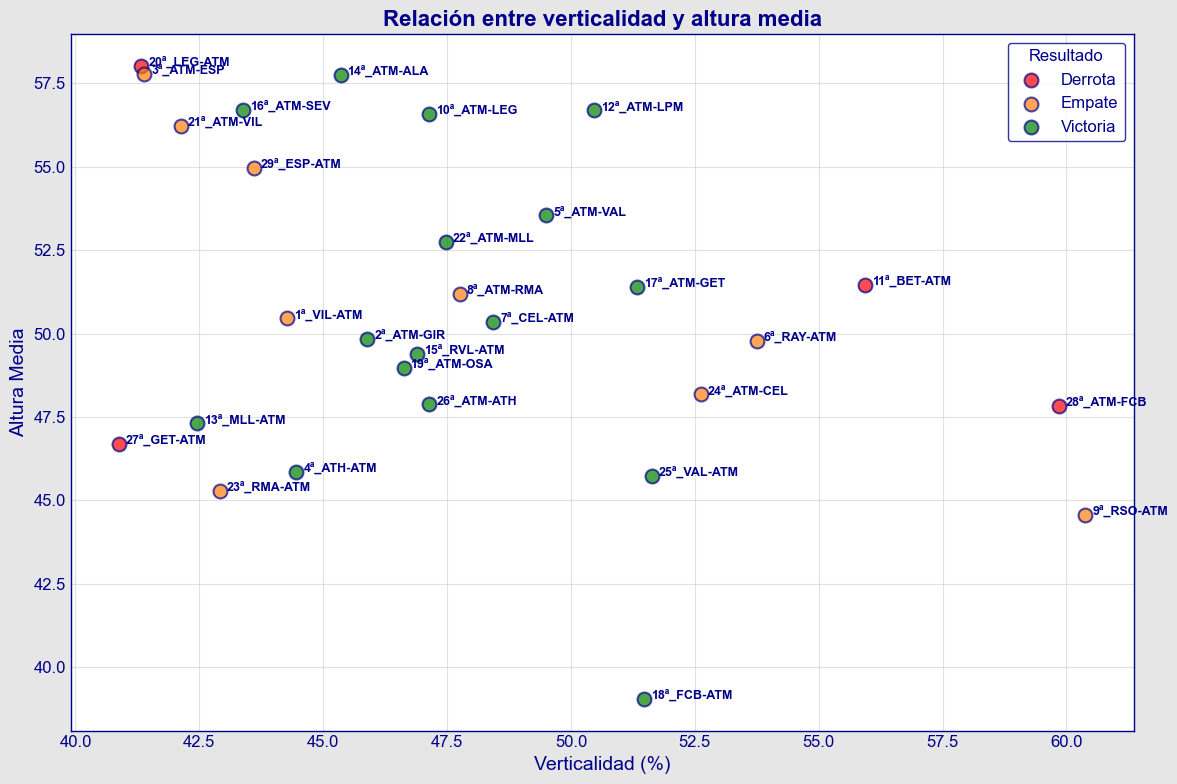


2. Heatmap de correlaci√≥n entre m√©tricas t√°cticas clave


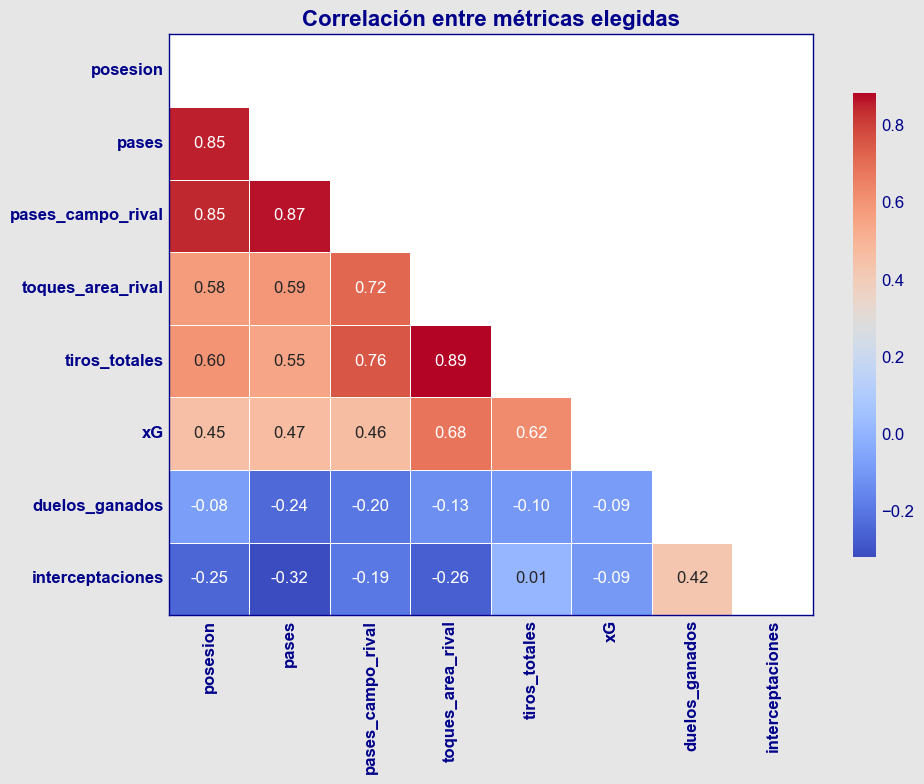


3. Gr√°fico de evoluci√≥n de m√©tricas t√°cticas a lo largo de la temporada


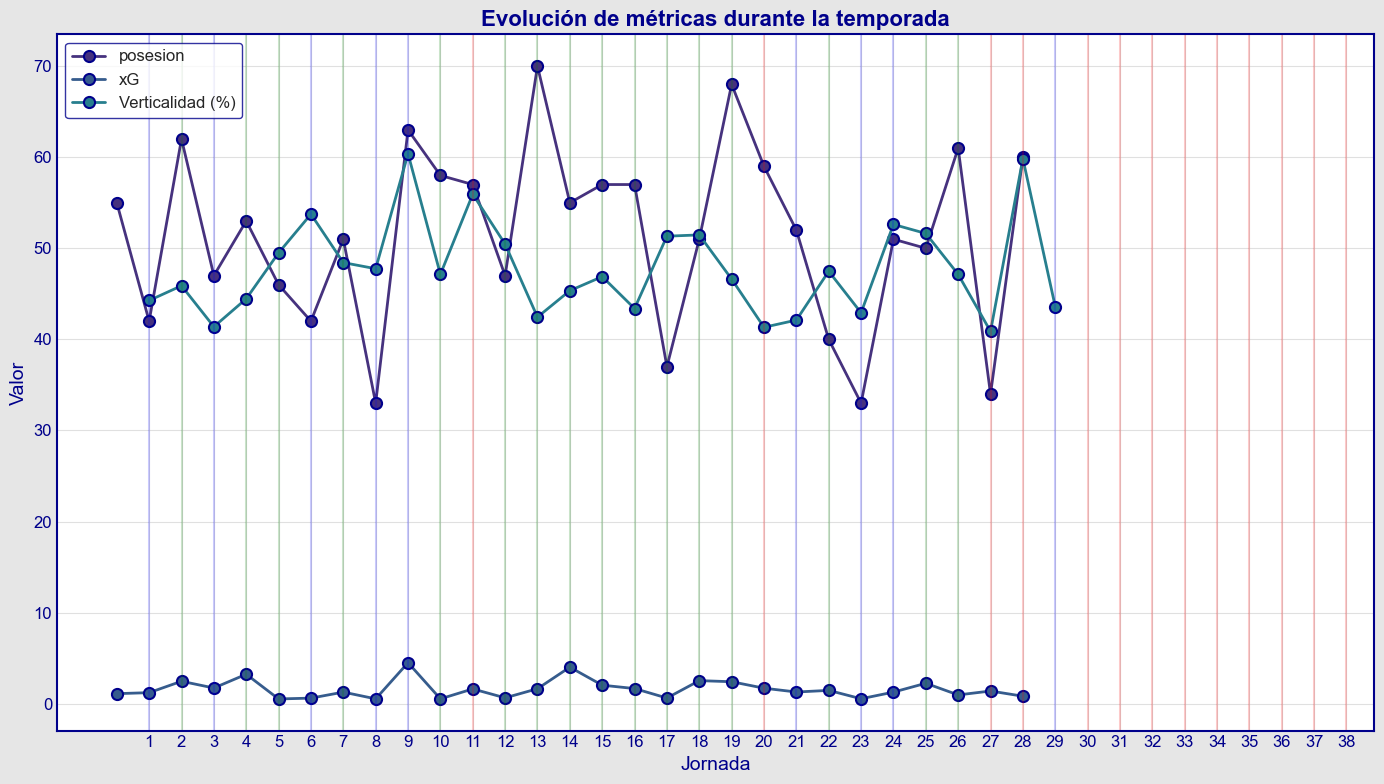


4. Comparaci√≥n de m√©tricas si local o visitante


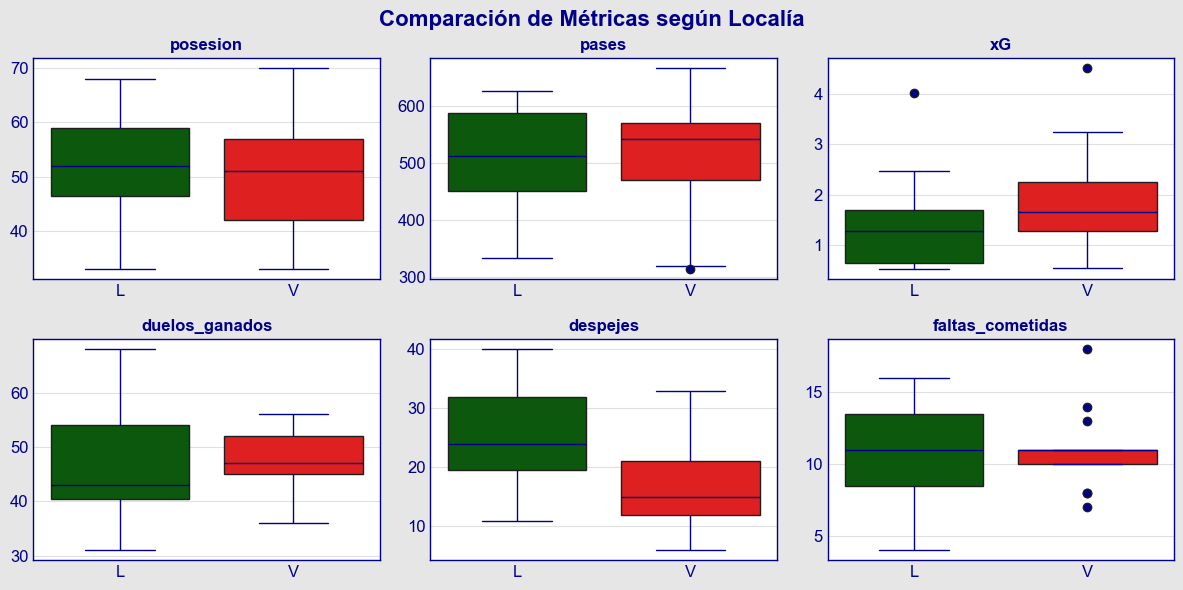


5. Distribuci√≥n de m√©tricas seg√∫n resultado


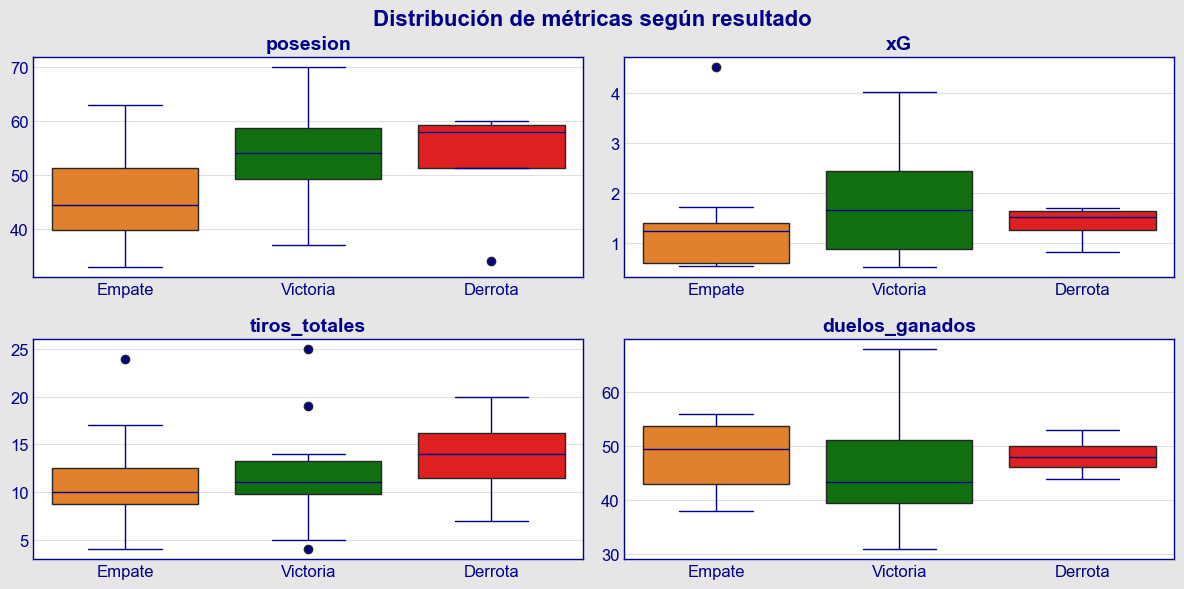


=== VISUALIZACIONES COMPLETADAS ===


In [60]:
# Ejecutar visualizaciones
visualizaciones_iniciales(datos)

### <u>Conclusiones extraidas de las visualizaciones</u>

1. **Scatter Plot: Relaci√≥n entre verticalidad y altura media**
- Elecci√≥n de visualizaci√≥n y m√©tricas:
Este scatter plot es perfecto para identificar la relaci√≥n entre dos variables continuas fundamentales para determinar el estilo de juego: la verticalidad (tendencia a avanzar r√°pidamente hacia la porter√≠a rival) y la altura media del equipo en el campo (vinculada a presi√≥n alta o bloque bajo). El uso de colores para distinguir los resultados a√±ade una tercera dimensi√≥n informativa.

- An√°lisis de resultado:
Se observa una amplia dispersi√≥n de puntos, lo que sugiere que el Atl√©tico de Madrid adapta su estilo de juego seg√∫n el contexto.
Las victorias (verde) tienden a mostrar una verticalidad moderada (45-52%) con altura media variable, y una agrupaci√≥n m√°s cercana entre puntos.
Las derrotas (rojo) presentan patrones m√°s extremos: muy alta verticalidad (FCB, 28¬™ jornada) o muy baja altura (GET, 27¬™ jornada), aunque son menos, 4, y ante rivales y contextos muy variados.
Los partidos con Barcelona (tanto local como visitante) muestran estilos opuestos: altura muy baja pero verticalidad extrema como visitante (18¬™), y verticalidad alta manteniendo posici√≥n m√°s alta como local (28¬™).

- Utilidad para el modelo SVM:
Esta visualizaci√≥n es crucial para identificar los diferentes "clusters" de estilos de juego. Las coordenadas en este espacio bidimensional pueden ser caracter√≠sticas importantes para el SVM, permitiendo separar diferentes enfoques t√°cticos.

2. **Heatmap: Correlaci√≥n entre m√©tricas elegidas**
- Elecci√≥n de visualizaci√≥n y m√©tricas:
El heatmap es la visualizaci√≥n ideal para mostrar correlaciones entre m√∫ltiples variables. Las m√©tricas seleccionadas cubren aspectos ofensivos (posesi√≥n, pases, toques en √°rea) y defensivos (duelos, interceptaciones).

- An√°lisis de resultado:
Fuerte correlaci√≥n positiva entre posesi√≥n, pases y pases en campo rival (0.85-0.87), lo que es esperable.
Alta correlaci√≥n entre toques en √°rea rival y tiros totales (0.89), vinculando penetraci√≥n y finalizaci√≥n.
Correlaci√≥n negativa entre m√©tricas ofensivas (posesi√≥n, pases) y defensivas (duelos, interceptaciones), lo que sugiere estilos de juego diferenciados (posesi√≥n vs. contraataque).
El xG muestra correlaciones moderadas con m√©tricas ofensivas, indicando que la eficacia no siempre est√° ligada al volumen ofensivo. Punto importante a tener en cuenta.

- Utilidad para el modelo SVM:
Esta matriz permite identificar variables colineales que podr√≠an reducirse para evitar redundancia en el modelo SVM. Por ejemplo, podr√≠a seleccionarse solo una entre posesi√≥n/pases/pases_campo_rival debido a su alta correlaci√≥n.

3. **Gr√°fico de l√≠neas: Evoluci√≥n de m√©tricas durante la temporada**
- Elecci√≥n de visualizaci√≥n y m√©tricas:
El gr√°fico de l√≠neas es perfecto para visualizar evoluci√≥n temporal. Incluir posesi√≥n, xG y verticalidad permite ver cambios en enfoque t√°ctico a lo largo de las jornadas.

- An√°lisis de lo observado:
Gran variabilidad en la posesi√≥n (desde 33% hasta 70%), mostrando adaptabilidad t√°ctica.
La verticalidad muestra menor variaci√≥n, manteniendo un rango m√°s constante (40-60%).
El xG se mantiene generalmente bajo (0-5), con picos en jornadas espec√≠ficas.
Las l√≠neas verticales verdes/rojas permiten contextualizar los cambios seg√∫n resultados.
Se aprecian periodos con patrones t√°cticos similares, seguidos de cambios abruptos, muy contextualizados por rivales.

- Utilidad para el modelo SVM:
Esta visualizaci√≥n ayuda a identificar posibles agrupaciones temporales (periodos con estilos similares) que podr√≠an usarse para crear variables categ√≥ricas en el modelo SVM, como "fase de temporada".

4. **Boxplots: Comparaci√≥n de m√©tricas seg√∫n local√≠a**
- Elecci√≥n de visualizaci√≥n y m√©tricas:
Los boxplots son ideales para comparar distribuciones entre grupos. Comparar m√©tricas entre partidos como local (L) y visitante (V) revela adaptaciones t√°cticas seg√∫n el contexto.

- An√°lisis de lo observado:
Mayor posesi√≥n y xG como local, reflejando un enfoque m√°s dominante.
Sorprendentemente, los pases totales son similares como local y visitante.
Hay, como es l√≥gico, m√°s despejes como visitante, indicando un enfoque m√°s defensivo.
M√°s faltas cometidas como visitante, sugiriendo mayor intensidad defensiva.
Los duelos ganados se mantienen relativamente constantes, aunque con mayor variabilidad como visitante.

- Utilidad para el modelo SVM:
La variable "local_visitante" podr√≠a ser un factor importante para el modelo SVM. La interacci√≥n entre local√≠a y otras m√©tricas t√°cticas podr√≠a capturarse mediante t√©rminos de interacci√≥n en el modelo.

5. **Boxplots: Distribuci√≥n de m√©tricas seg√∫n resultado**
- Elecci√≥n de visualizaci√≥n y m√©tricas:
Similar al anterior, estos boxplots permiten analizar c√≥mo var√≠an las m√©tricas seg√∫n el resultado (victoria, empate, derrota).

- An√°lisis de lo observado:
Mayor posesi√≥n en derrotas, lo que parece contraintuitivo pero sugiere que el equipo es m√°s efectivo sin dominar tanto el bal√≥n, o que tras verse por detr√°s en el marcador, adopta mayor iniciativa en dicho dominio.
Mayor xG en victorias, indicando mejor calidad de ocasiones cuando se gana. Tambi√©n relacionado con lo anterior, es decir, si se adelanta en el marcador, evoluciona a un ataque m√°s selectivo.
Menor n√∫mero de tiros en derrotas, a pesar de la mayor posesi√≥n. Puede clarificar un estilo de mayor eficiencia con espacios en ataques cortos y verticales.
Duelos ganados similares en victorias y derrotas, pero menores en empates.

- Utilidad para el modelo SVM:
Estas relaciones sugieren que el Atl√©tico tiene diferentes patrones de √©xito. El modelo SVM podr√≠a beneficiarse de caracter√≠sticas que capturen la "eficiencia" (ratio entre xG y posesi√≥n, por ejemplo), m√°s que valores absolutos.

### <u>Toma de decisi√≥n final</u>

**Basado en estas visualizaciones, ser√≠a recomendable:**

- Variables clave para el modelo SVM:

Verticalidad y altura media como variables fundamentales;
Eficiencia ofensiva (xG/posesi√≥n, tiros/posesi√≥n);
Variables de contexto (local/visitante);
M√©tricas defensivas (despejes, duelos ganados).

- Reducci√≥n de dimensionalidad:

Eliminar variables altamente correlacionadas (usar solo una de: posesi√≥n, pases, pases_campo_rival);
Considerar la creaci√≥n de √≠ndices compuestos (ofensivo, defensivo, transici√≥n).

- Posibles clasificaciones de estilo:

Posesi√≥n dominante: alta posesi√≥n, alto xG, altura media alta;
Contraataque vertical: baja posesi√≥n, alta verticalidad, xG moderado;
Bloque bajo defensivo: baja altura media, bajos valores ofensivos, altos despejes;
Presi√≥n alta agresiva: alta altura media, duelos ganados altos, posesi√≥n moderada.

    Importante a√±adir que a√∫n queda por unir un csv de eventos, donde podremos observar aspectos como saques de puerta o faltas en primer tercio de campo para medir el impacto de reinicios en corto, o coordenadas en ataques para observar pasillos ofensivos como patr√≥n com√∫n.

# 3. Preparaci√≥n de Datos

## 3.1 Limpieza de Datos

In [61]:
# Proceso de limpieza de los archivos

def limpiar_datos(ruta_master, ruta_stats, ruta_eventos, ruta_equipos=None, mostrar_ejemplos=True):
    """
    Realiza la limpieza integral de todos los datasets necesarios para el an√°lisis
    t√°ctico del Atl√©tico de Madrid.
    
    Args:
        ruta_master (str): Ruta al archivo master_liga_atm.csv
        ruta_stats (str): Ruta al archivo stats_atm_por_partido.csv
        ruta_eventos (str): Ruta a la carpeta que contiene los archivos de eventos por jornada
        ruta_equipos (str, opcional): Ruta al archivo equipos_laliga_master.csv
        mostrar_ejemplos (bool): Si es True, muestra las primeras filas de cada DataFrame
    
    Returns:
        dict: Diccionario con todos los DataFrames limpios
    """
    print("Iniciando proceso de limpieza de datos...")
    resultado = {}
    
    # 1. master_liga_atm.csv
    print("\n1. Limpieza de datos maestros de partidos...")
    df_master = limpiar_df_master(ruta_master)
    resultado['master'] = df_master
    
    # 2. stats_atm_por_partido.csv
    print("\n2. Limpieza de estad√≠sticas por partido...")
    df_stats = limpiar_df_stats(ruta_stats)
    resultado['stats'] = df_stats
    
    # 3. Limpieza y combinaci√≥n de archivos de eventos
    print("\n3. Procesando archivos de eventos por jornada...")
    df_eventos = limpiar_df_eventos(ruta_eventos)
    resultado['eventos'] = df_eventos
    
    # 4. equipos_laliga_master.csv
    if ruta_equipos:
        print("\n4. Procesando datos de equipos...")
        df_equipos = limpiar_df_equipos(ruta_equipos)
        resultado['equipos'] = df_equipos
    
    # Muestro info detallada de cada DataFrame
    if mostrar_ejemplos:
        for nombre, df in resultado.items():
            print(f"\n{'='*20} AN√ÅLISIS DETALLADO DE {nombre.upper()} {'='*20}")
            
            # Dimensiones
            print(f"\nüìä Dimensiones: {df.shape} (filas, columnas)")
            
            # Tipos de datos y valores no nulos
            print("\nüìã Informaci√≥n del DataFrame:")
            buffer = io.StringIO()
            df.info(buf=buffer)
            print(buffer.getvalue())
            
            # Estad√≠sticas descriptivas para columnas num√©ricas
            try:
                print("\nüìà Estad√≠sticas descriptivas (columnas num√©ricas):")
                print(df.describe())
            except:
                print("No se pudieron generar estad√≠sticas descriptivas")
            
            # Valores √∫nicos para columnas categ√≥ricas
            print("\nüîç Valores √∫nicos en columnas categ√≥ricas:")
            cat_cols = df.select_dtypes(include=['object']).columns
            for col in cat_cols[:5]:  # 5 por no saturar salida
                try:
                    n_unique = df[col].nunique()
                    print(f"{col}: {n_unique} valores √∫nicos")
                    if n_unique < 10:  # Solo se muestra si hay pocos valores √∫nicos
                        try:
                            unique_vals = df[col].unique()
                            # Se convierte a string para evitar problemas con diccionarios
                            print(f"    Valores: {[str(val)[:50] + '...' if isinstance(val, str) and len(str(val)) > 50 else str(val) for val in unique_vals]}")
                        except:
                            print("    No se pueden mostrar los valores √∫nicos")
                except:
                    print(f"{col}: No se puede determinar valores √∫nicos (posiblemente contiene tipos no hashables)")
            
            # Datos faltantes
            print("\n‚ö†Ô∏è An√°lisis de datos faltantes:")
            missing = df.isnull().sum()
            missing = missing[missing > 0]
            if len(missing) > 0:
                print(missing)
            else:
                print("No hay datos faltantes")
            
            # Primeras filas
            print("\nüëÄ Primeras 5 filas:")
            print(df.head(5))
            
            print(f"\n{'='*70}")
    
    print("\nProceso de limpieza completado con √©xito.")
    return resultado

def limpiar_df_master(ruta_archivo):
    """
    Limpia el archivo master_liga_atm.csv
    
    Args:
        ruta_archivo (str): Ruta al archivo
    
    Returns:
        pd.DataFrame: DataFrame limpio
    """
    print(f"Leyendo archivo {ruta_archivo}...")
    df = pd.read_csv(ruta_archivo, sep=';')
    
    print("Aplicando transformaciones a datos maestros...")
    # Jornada a num√©rico
    df['jornada_num'] = df['jornada'].str.replace('¬™', '').astype(int)
    
    # Verticalidad a num√©rico extrayendo s√≠mbolo de porcentaje
    df['verticalidad_num'] = df['verticalidad'].str.rstrip('%').astype(float)
    
    # Extraigo componentes del resultado
    df[['goles_favor_res', 'goles_contra_res']] = df['resultado'].str.split('-', expand=True).astype(float)
    
    # Se verifica coherencia entre resultado y goles
    mask_inconsistencia = (df['goles_favor_res'] != df['goles_a_favor']) | (df['goles_contra_res'] != df['goles_en_contra'])
    if mask_inconsistencia.any():
        print(f"ADVERTENCIA: Se encontraron {mask_inconsistencia.sum()} inconsistencias entre resultado y goles registrados")
    
    # Se crea la columna de resultado tipo (Victoria, Empate, Derrota)
    df['resultado_tipo'] = 'Sin disputar'
    mask_jugados = ~df['resultado'].isna()
    
    df.loc[mask_jugados & (df['goles_a_favor'] > df['goles_en_contra']), 'resultado_tipo'] = 'Victoria'
    df.loc[mask_jugados & (df['goles_a_favor'] == df['goles_en_contra']), 'resultado_tipo'] = 'Empate'
    df.loc[mask_jugados & (df['goles_a_favor'] < df['goles_en_contra']), 'resultado_tipo'] = 'Derrota'
    
    # Creo columnas para clasificar expulsiones seg√∫n el minuto
    df['impacto_expulsion_propia'] = 0
    df.loc[df['min_expulsion_propia'] <= 30, 'impacto_expulsion_propia'] = 3  # Alta
    df.loc[(df['min_expulsion_propia'] > 30) & (df['min_expulsion_propia'] <= 60), 'impacto_expulsion_propia'] = 2  # Media
    df.loc[df['min_expulsion_propia'] > 60, 'impacto_expulsion_propia'] = 1  # Baja
    
    df['impacto_expulsion_rival'] = 0
    df.loc[df['min_expulsion_rival'] <= 30, 'impacto_expulsion_rival'] = 3  # Alta
    df.loc[(df['min_expulsion_rival'] > 30) & (df['min_expulsion_rival'] <= 60), 'impacto_expulsion_rival'] = 2  # Media
    df.loc[df['min_expulsion_rival'] > 60, 'impacto_expulsion_rival'] = 1  # Baja
    
    # Crear columnas para goles tempranos
    df['gol_temprano_favor'] = (df['min_primer_gol_a_favor'] <= 15) & (~df['min_primer_gol_a_favor'].isna())
    df['gol_temprano_contra'] = (df['min_primer_gol_en_contra'] <= 15) & (~df['min_primer_gol_en_contra'].isna())
    
    return df

def limpiar_df_stats(ruta_archivo):
    """
    Limpia el archivo stats_atm_por_partido.csv
    
    Args:
        ruta_archivo (str): Ruta al archivo
    
    Returns:
        pd.DataFrame: DataFrame limpio
    """

    def limpiar_stats_tiros_bloqueados(df):
        """
        Elimina las columnas duplicadas de tiros_bloqueados y mantiene solo las necesarias
        """
        # Identificar columnas de tiros_bloqueados
        cols_tiros = [col for col in df.columns if col.startswith('tiros_bloqueados')]
        
        # Mantener solo la original y la primera variante
        cols_a_mantener = ['tiros_bloqueados', 'tiros_bloqueados.1']
        cols_a_eliminar = [col for col in cols_tiros if col not in cols_a_mantener]
        
        # Verificar si hay diferencias reales antes de eliminar
        print(f"Columna tiros_bloqueados - media: {df['tiros_bloqueados'].mean()}, std: {df['tiros_bloqueados'].std()}")
        print(f"Columna tiros_bloqueados.1 - media: {df['tiros_bloqueados.1'].mean()}, std: {df['tiros_bloqueados.1'].std()}")
        
        # Eliminar columnas duplicadas
        df = df.drop(columns=cols_a_eliminar)
        
        # Renombrar para mayor claridad (opcional)
        df = df.rename(columns={
            'tiros_bloqueados': 'tiros_bloqueados_original',
            'tiros_bloqueados.1': 'tiros_bloqueados_alt'
        })

        return df

    print(f"Leyendo archivo {ruta_archivo}...")
    df = pd.read_csv(ruta_archivo)
    
    print("Aplicando transformaciones a estad√≠sticas por partido...")

    # AQU√ç: Limpieza espec√≠fica de columnas duplicadas de tiros_bloqueados
    df = limpiar_stats_tiros_bloqueados(df)

    # Lista de columnas que necesitan extracci√≥n de porcentajes
    columnas_con_porcentaje = [
        'pases_precisos', 'pases_largos_precisos', 'centros_precisos', 
        'regates_exitosos', 'duelos_suelo_ganados', 'duelos_aereos_ganados', 
        'entradas_exitosas'
    ]
    
    # Funci√≥n para extraer valor num√©rico y porcentaje
    def extraer_valor_porcentaje(valor):
        if isinstance(valor, str) and '(' in valor:
            match = re.search(r'(\d+)\s*\((\d+(?:\.\d+)?)%\)', valor)
            if match:
                return int(match.group(1)), float(match.group(2))
        # Si no se puede extraer, devuelve el valor original y None
        return valor, None
    
    # Procesar columnas con porcentajes
    for col in columnas_con_porcentaje:
        if col in df.columns:
            # Se crea nueva columna para el porcentaje
            nuevo_col = f"pct_{col}"
            
            # Extrae valor y porcentaje
            valores_porcentajes = df[col].apply(extraer_valor_porcentaje)
            
            # Se asignan valores y porcentajes a sus respectivas columnas
            df[col] = valores_porcentajes.apply(lambda x: x[0])
            df[nuevo_col] = valores_porcentajes.apply(lambda x: x[1])
    
    # Elimino duplicados en columnas de tiros_bloqueados
    columnas_duplicadas = [col for col in df.columns if col.startswith('tiros_bloqueados.')]
    if columnas_duplicadas:
        print(f"Eliminando {len(columnas_duplicadas)} columnas duplicadas de tiros_bloqueados")
        df = df.drop(columns=columnas_duplicadas)
    
    # Convierto todas las columnas num√©ricas a float
    columnas_numericas = df.columns.drop('jornada')
    for col in columnas_numericas:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            print(f"No se pudo convertir la columna {col} a num√©rico")
    
    # Me aseguro de que jornada es num√©rica
    df['jornada'] = pd.to_numeric(df['jornada'], errors='coerce')
    
    # Orden por jornada
    df = df.sort_values('jornada')
    
    return df

def limpiar_df_eventos(ruta_carpeta):
    """
    Limpia y combina todos los archivos de eventos por jornada
    
    Args:
        ruta_carpeta (str): Ruta a la carpeta con archivos de eventos
    
    Returns:
        pd.DataFrame: DataFrame combinado y limpio de eventos
    """
    print(f"Buscando archivos de eventos en {ruta_carpeta}...")
    # Obtengo primero la lista de archivos de eventos
    archivos_eventos = glob(os.path.join(ruta_carpeta, '*_EventData.csv'))
    print(f"Se encontraron {len(archivos_eventos)} archivos de eventos")
    
    if not archivos_eventos:
        print("ADVERTENCIA: No se encontraron archivos de eventos")
        return pd.DataFrame()
    
    # Funci√≥n para extraer n√∫mero de jornada del nombre de archivo
    def extraer_jornada(nombre_archivo):
        match = re.search(r'(\d+)¬™?_', os.path.basename(nombre_archivo))
        if match:
            return int(match.group(1))
        return None
    
    # Lista para almacenar DataFrames procesados
    dfs_eventos = []
    
    # Procesa cada archivo
    for archivo in archivos_eventos:
        jornada = extraer_jornada(archivo)
        if jornada is None:
            print(f"ADVERTENCIA: No se pudo extraer n√∫mero de jornada para {archivo}")
            continue
        
        print(f"Procesando eventos de jornada {jornada}...")
        
        # Lee el archivo
        df = pd.read_csv(archivo)
        
        # Extrae informaci√≥n de columnas JSON
        df = procesar_json_eventos(df)
        
        # Filtrar eventos del Atl√©tico
        df_atletico = df[df['teamId'] == 63].copy()

        # Filtrar tiros y goles del rival
        df_tiros_rival = df[(df['teamId'] != 63) & 
                            (df['type_nombre'].isin(['Shot', 'Goal']))].copy()

        # Marcar estos eventos como "del rival" para distinguirlos
        df_tiros_rival['es_rival'] = True

        # Combinar ambos DataFrames
        df_eventos_filtrados = pd.concat([df_atletico, df_tiros_rival])

        # A√±adir columna para identificar eventos del Atl√©tico vs rival
        if 'es_rival' not in df_eventos_filtrados:
            df_eventos_filtrados.loc[df_eventos_filtrados['teamId'] == 63, 'es_rival'] = False
        
        # A√±ade columna de jornada
        df_eventos_filtrados['jornada'] = jornada
        
        # Ordena por minuto y segundo
        df_eventos_filtrados = df_eventos_filtrados.sort_values(['minute', 'second'])
        
        # A√±ade al listado
        dfs_eventos.append(df_eventos_filtrados)
    
    # Combina todos los DataFrames
    if dfs_eventos:
        print("Combinando todos los archivos de eventos...")
        df_eventos_completo = pd.concat(dfs_eventos, ignore_index=True)
        print(f"DataFrame de eventos combinado: {df_eventos_completo.shape}")
        return df_eventos_completo
    else:
        print("ADVERTENCIA: No se proces√≥ ning√∫n archivo de eventos correctamente")
        return pd.DataFrame()

def procesar_json_eventos(df):
    """
    Procesa columnas JSON en el DataFrame de eventos
    
    Args:
        df (pd.DataFrame): DataFrame con eventos
    
    Returns:
        pd.DataFrame: DataFrame con columnas JSON procesadas
    """
    # Columnas que contienen JSON
    columnas_json = ['period', 'type', 'outcomeType', 'qualifiers']
    
    # Procesar cada columna JSON
    for columna in columnas_json:
        if columna in df.columns:
            # Extraer valores directamente en lugar de mantener el diccionario
            if columna != 'qualifiers':  # qualifiers es una lista, no un diccionario
                try:
                    # Extrae el valor
                    df[f'{columna}_valor'] = df[columna].apply(
                        lambda x: json.loads(x.replace("'", '"'))['value'] 
                        if isinstance(x, str) else None)
                    
                    # Extrae el nombre
                    df[f'{columna}_nombre'] = df[columna].apply(
                        lambda x: json.loads(x.replace("'", '"'))['displayName'] 
                        if isinstance(x, str) else None)
                except:
                    print(f"Error al procesar la columna {columna}")
            else:
                # Para 'qualifiers', que es una lista, simplemente guardamos la longitud
                df[f'{columna}_longitud'] = df[columna].apply(
                    lambda x: len(json.loads(x.replace("'", '"')))
                    if isinstance(x, str) else 0)
    
    # Elimina columnas originales JSON
    df = df.drop(columns=columnas_json, errors='ignore')
    
    return df

def limpiar_df_equipos(ruta_archivo):
    """
    Limpia el archivo equipos_laliga_master.csv
    
    Args:
        ruta_archivo (str): Ruta al archivo
    
    Returns:
        pd.DataFrame: DataFrame limpio
    """
    print(f"Leyendo archivo {ruta_archivo}...")
    df = pd.read_csv(ruta_archivo, sep=';')
    
    print("Aplicando transformaciones a datos de equipos...")
    # Limpia nombres de columnas
    df.columns = df.columns.str.strip()
    
    # Limpia valores de rutas de escudos (quitar comillas)
    if 'ruta_escudo' in df.columns:
        df['ruta_escudo'] = df['ruta_escudo'].str.replace("'", "")
    
    return df

# Uso
if __name__ == "__main__":
    # Defino rutas (ajustar cada uno seg√∫n corresponda)
    ruta_master = "data/stats_jornadas/master_liga_atm.csv"
    ruta_stats = "data/stats_jornadas/stats_atm_por_partido.csv"
    ruta_eventos = "data/stats_jornadas/"
    ruta_equipos = "data/master/equipos_laliga_master.csv"
    
    # Ejecutamos limpieza
    datos_limpios = limpiar_datos(ruta_master, ruta_stats, ruta_eventos, ruta_equipos)
    
    # Muestra informaci√≥n de los DataFrames limpios
    for nombre, df in datos_limpios.items():
        print(f"\n--- {nombre.upper()} ---")
        print(f"Dimensiones: {df.shape}")
        print("Primeras filas:")
        print(df.head())

Iniciando proceso de limpieza de datos...

1. Limpieza de datos maestros de partidos...
Leyendo archivo data/stats_jornadas/master_liga_atm.csv...
Aplicando transformaciones a datos maestros...
ADVERTENCIA: Se encontraron 18 inconsistencias entre resultado y goles registrados

2. Limpieza de estad√≠sticas por partido...
Leyendo archivo data/stats_jornadas/stats_atm_por_partido.csv...
Aplicando transformaciones a estad√≠sticas por partido...
Columna tiros_bloqueados - media: 3.0344827586206895, std: 1.9727203592409004
Columna tiros_bloqueados.1 - media: 2.8275862068965516, std: 2.2211477971863585

3. Procesando archivos de eventos por jornada...
Buscando archivos de eventos en data/stats_jornadas/...
Se encontraron 29 archivos de eventos
Procesando eventos de jornada 10...
Procesando eventos de jornada 11...
Procesando eventos de jornada 12...
Procesando eventos de jornada 13...
Procesando eventos de jornada 14...
Procesando eventos de jornada 15...
Procesando eventos de jornada 16...
P

#### <u>Resumen limpieza</u>


1. master_liga_atm.csv: 

Eliminamos "¬™" de la columna jornada y simbolo de porcentaje en columna de verticalidad y se pasa a num√©ricos. Se extrae valores de resultado y compara con goles, y se crea columna de victoria-empate-derrota. Generamos columna de impacto de expulsiones o goles en minutos iniciales.

2. stats_atm_por_partido: 

Se generan columnas nuevas con los porcentajes que encontramos en algunos datos con la medida del acierto, con el prefijo "pct", se eliminan columnas duplicadas, y ordenamos por jornada.

3. Limpieza, trato archivos de eventos: 

Se revisan los archivos existentes, y extrayendo el n√∫mero de jornada de cada nombre, se unen por orden. Se analizan y filtramos por id del Atleti (63) y solo dejamos acciones de tiro rival para calcular alguno de los √≠ndices, y extraemos la info de cada celda con contenido en formato json creando nuevas columnas.

## 3.2 Feature Engineering

### <u>¬øQu√© voy a intentar hacer?</u>

En el siguiente c√≥digo tomar√© los datos limpios que he procesado en la fase anterior y tratar√© de generar √≠ndices t√°cticos que caracterizan el estilo de juego del Atl√©tico de Madrid en cada partido. El proceso se divide en varias partes:

1. Procesamiento espacial: dividir el campo en zonas y clasificar los eventos seg√∫n d√≥nde ocurren (zona1/zona2/zona3 y derecho/central/izquierdo).

2. C√°lculo de √≠ndices b√°sicos usando estad√≠sticas generales para calcular:

- IIJ (√çndice de Iniciativa de Juego);
- IVJO (√çndice de Volumen de Juego Ofensivo);
- EC (√çndice de Eficacia en Construcci√≥n);
- EF (√çndice de Eficacia en Finalizaci√≥n);
- IJD (√çndice de Juego Directo).

3. C√°lculo de √≠ndices avanzados, los cu√°les requieren un an√°lisis detallado de eventos:

- IER (√çndice de Eficacia Recuperadora);
- IV (√çndice de Verticalidad);
- IPA (√çndice de Presi√≥n Alta);
- IA (√çndice de Amplitud en ataque);
- IDD (√çndice de Densidad Defensiva);
- ICJ (√çndice de Complejidad de Juego).

3. Variables de contexto que muestran informaci√≥n adicional sobre cada partido:

- Expulsi√≥n temprana;
- Gol temprano a favor/en contra;
- Categor√≠a del rival;
- Local/visitante.

4. Categorizaci√≥n de estilos basada en los √≠ndices, clasificando el estilo de juego en cada partido seg√∫n:

- Orientaci√≥n general (ofensivo, defensivo, equilibrado);
- Fase ofensiva (posicional, vertical, directo);
- Patr√≥n de ataque (bandas, central, mixto);
- Intensidad defensiva (presi√≥n alta, defensa pasiva, moderada);
- Altura del bloque (alto, medio, bajo);
- Tipo de transici√≥n (contragolpe efectivo, convencional).

5. Preparaci√≥n para modelado y organizar los datos para alimentar el modelo SVM:

- Normaliza las caracter√≠sticas num√©ricas;
- Prepara variables dependientes (y) para cada categor√≠a de estilo;
- Prepara variables independientes (X) con todos los √≠ndices t√°cticos.

In [62]:
# Funci√≥n creaci√≥n de features
def crear_features(datos_limpios):
    """
    Realiza feature engineering a partir de los datos limpios para analizar
    el estilo de juego del Atl√©tico de Madrid.
    
    Args:
        datos_limpios (dict): Diccionario con DataFrames limpios:
            - 'master': DataFrame con datos de partidos
            - 'stats': DataFrame con estad√≠sticas por partido
            - 'eventos': DataFrame con eventos detallados
            - 'equipos': DataFrame con informaci√≥n de equipos
    
    Returns:
        pd.DataFrame: DataFrame con √≠ndices t√°cticos y features derivadas por jornada
    """
    print("Iniciando proceso de feature engineering...")
    
    # DF's
    df_master = datos_limpios['master']
    df_stats = datos_limpios['stats']
    df_eventos = datos_limpios['eventos']
    df_equipos = datos_limpios['equipos']
    
    # DF para almacenar todos los √≠ndices
    df_indices = pd.DataFrame()
    
    # Info espacial de eventos
    print("\n1. Procesando informaci√≥n espacial de eventos...")
    df_zonas = procesar_zonas_campo(df_eventos)
    
    # Calculo de √≠ndices t√°cticos b√°sicos
    print("\n2. Calculando √≠ndices t√°cticos b√°sicos...")
    df_indices_basicos = calcular_indices_basicos(df_master, df_stats)
    
    # Calculo de √≠ndices t√°cticos avanzados (basados en eventos)
    print("\n3. Calculando √≠ndices t√°cticos avanzados...")
    df_indices_avanzados = calcular_indices_avanzados(df_eventos, df_zonas, df_stats)
    
    # Calculo de variables de contexto
    print("\n4. Calculando variables de contexto...")
    df_contexto = calcular_variables_contexto(df_master, df_equipos)
    
    # Combinar dataframes b√°sicos y avanzados primero
    print("\n5. Combinando √≠ndices b√°sicos y avanzados...")
    # Asegurar que todos los DF tengan 'jornada' como clave
    if 'jornada' not in df_indices_basicos.columns:
        df_indices_basicos['jornada'] = df_indices_basicos.index

    if 'jornada' not in df_indices_avanzados.columns:
        df_indices_avanzados['jornada'] = df_indices_avanzados.index

    # Primero combinar √≠ndices b√°sicos y avanzados
    df_combinado = pd.merge(df_indices_basicos, df_indices_avanzados, on='jornada', how='outer')

    # Se incorpora df_zonas para las estad√≠sticas espaciales
    df_combinado = pd.merge(df_combinado, df_zonas, on='jornada', how='left')

    # Despu√©s se a√±aden las estad√≠sticas generales para c√°lculos adicionales
    df_combinado = pd.merge(df_combinado, df_stats, on='jornada', how='left')

    # Y se calculan los √≠ndices especializados
    print("\n6. Calculando √≠ndices t√°cticos especializados...")
    df_indices_especializados = calcular_indices_especializados(df_combinado)

    # Lista de DF's a combinar para el resultado final
    print("\n7. Integrando todos los √≠ndices y variables...")
    dfs_to_combine = [df_indices_basicos, df_indices_avanzados, df_indices_especializados, df_contexto]

    # Combino los DF para obtener el resultado final
    df_indices = dfs_to_combine[0]
    for df in dfs_to_combine[1:]:
        df_indices = pd.merge(df_indices, df, on='jornada', how='outer')

    # A√ëADIR ESTAS L√çNEAS: Asegurar que posesion est√© en el DataFrame final
    if 'posesion' not in df_indices.columns and 'posesion' in df_combinado.columns:
        df_indices = pd.merge(df_indices, df_combinado[['jornada', 'posesion']], on='jornada', how='left')

    # Ordenar por jornada
    df_indices = df_indices.sort_values('jornada')
    
    # Se visualizan resultados
    print("\n8. Creando visualizaciones de √≠ndices...")
    visualizar_indices(df_indices)
    
    # Categorizaci√≥n de estilos de juego
    print("\n9. Categorizando estilos de juego...")
    df_indices = categorizar_estilos(df_indices)
    
    print("\nProceso de feature engineering completado.")
    return df_indices

# Funci√≥n que customiza las distintas zonas del campo, y definen m√©tricas asociadas a esta customizaci√≥n
def procesar_zonas_campo(df_eventos):
    """
    Procesa eventos para clasificarlos por zonas del campo
    
    Args:
        df_eventos (pd.DataFrame): DataFrame con eventos
    
    Returns:
        pd.DataFrame: DataFrame con eventos clasificados por zonas
    """
    print("  Clasificando eventos por zonas del campo...")
    
    df = df_eventos.copy()
    
    # Clasificaci√≥n de zonas
    def clasificar_zona_vertical(x):
        if x <= 33.3:
            return 'Zona1'
        elif x <= 66.6:
            return 'Zona2'
        else:
            return 'Zona3'
    
    def clasificar_zona_horizontal(y):
        if y <= 25:
            return 'Derecho'
        elif y <= 75:
            return 'Central'
        else:
            return 'Izquierdo'
    
    # Funciones para clasificaci√≥n
    df['zona_vertical'] = df['x'].apply(clasificar_zona_vertical)
    df['zona_horizontal'] = df['y'].apply(clasificar_zona_horizontal)
    
    # Se combinan las zonas para crear una zona completa
    df['zona_completa'] = df['zona_vertical'] + '_' + df['zona_horizontal']
    
    # Identificaci√≥n pases progresivos (avance vertical significativo)
    df['es_pase_progresivo'] = False
    
    # S√≥lo pases
    mask_pases = df['type_nombre'] == 'Pass'
    
    # Determinar si son progresivos (avanzan al menos 10 unidades en x)
    df.loc[mask_pases & ~df['endX'].isna(), 'es_pase_progresivo'] = (
        df.loc[mask_pases & ~df['endX'].isna(), 'endX'] - 
        df.loc[mask_pases & ~df['endX'].isna(), 'x'] > 10
    )
    
    # Identificaci√≥n pases largos (distancia euclidiana > 30 unidades)
    df['es_pase_largo'] = False
    
    # Calculamos distancia para pases con coordenadas completas
    mask_coord_completas = mask_pases & ~df['endX'].isna() & ~df['endY'].isna()
    
    if mask_coord_completas.any():
        df.loc[mask_coord_completas, 'distancia_pase'] = np.sqrt(
            (df.loc[mask_coord_completas, 'endX'] - df.loc[mask_coord_completas, 'x'])**2 +
            (df.loc[mask_coord_completas, 'endY'] - df.loc[mask_coord_completas, 'y'])**2
        )
        
        # Marcar pases largos
        df.loc[mask_coord_completas & (df['distancia_pase'] > 30), 'es_pase_largo'] = True    
    
    # Identificar recuperaciones
    recuperaciones = ['Interception', 'BallRecovery', 'Tackle', 'BlockedPass', 'Challenge']
    df['es_recuperacion'] = df['type_nombre'].isin(recuperaciones)
    
    # Identificar acciones defensivas
    acciones_defensivas = recuperaciones + ['Clearance', 'Block', 'Save', 'Claim']
    df['es_accion_defensiva'] = df['type_nombre'].isin(acciones_defensivas)
    
    # Identificar acciones en √°rea propia (primer 20% del campo)
    df['en_area_propia'] = df['x'] <= 20
    
    # Identificar secuencias de posesi√≥n
    print("  Identificando secuencias de posesi√≥n...")
    recuentos_secuencias = identificar_secuencias_posesion(df)

    # Obtener estad√≠sticas por jornada
    print("  Generando estad√≠sticas espaciales por jornada...")
    df_zonas = generar_stats_espaciales(df, recuentos_secuencias)
    
    # Extraer tiros recibidos para calcular impacto con otras m√©tricas
    print("  Extrayendo tiros recibidos...")
    # Filtrar eventos de tipo 'Shot' (o 'Goal') que no son del Atl√©tico (teamId != 63)
    tiros_rival = df_eventos[(df_eventos['teamId'] != 63) & 
                            (df_eventos['type_nombre'].isin(['Shot', 'Goal']))]
    
    # Conteo por jornada
    tiros_recibidos_por_jornada = tiros_rival.groupby('jornada').size().reset_index()
    tiros_recibidos_por_jornada.columns = ['jornada', 'tiros_recibidos']
    
    # Se a√±ade esta columna al DF de estad√≠sticas espaciales
    df_zonas = pd.merge(df_zonas, tiros_recibidos_por_jornada, on='jornada', how='left')
    df_zonas['tiros_recibidos'].fillna(0, inplace=True)
    
    return df_zonas

# Funci√≥n para calcular secuencias de posesi√≥n que considero importantes (m√≠nimo ocho pases) y que llevar√© al √≠ndice de control del juego
def identificar_secuencias_posesion(df):
    """
    Identifica secuencias de posesi√≥n en los eventos y devuelve recuentos
    
    Args:
        df (pd.DataFrame): DataFrame con eventos
    
    Returns:
        dict: Diccionario con recuentos de secuencias por jornada
    """
    # Diccionario para almacenar recuentos por jornada
    recuentos = {}
    
    # Proceso por jornada
    for jornada in df['jornada'].unique():
        print(f"  Procesando secuencias en jornada {jornada}...")
        
        df_jornada = df[df['jornada'] == jornada].copy()
        df_jornada = df_jornada.sort_values(['minute', 'second'])
        
        # Variables para seguimiento
        id_secuencia_actual = 1
        secuencias_largas = 0
        total_secuencias = 0
        pases_en_secuencia_actual = 0
        
        # Eventos que llevan a una interrupci√≥n y/o secuenia
        eventos_quiebre = ['Interception', 'Foul', 'OffsidePass', 'Offside', 'Save', 'Goal', 'Clearance']
        eventos_secuencia = ['Pass']
        
        # Iterar ordenadamente
        prev_idx = None
        
        for idx, row in df_jornada.iterrows():
            es_evento_secuencia = row['type_nombre'] in eventos_secuencia
            
            # Si hay quiebre o gap de tiempo
            if (row['type_nombre'] in eventos_quiebre or 
                (prev_idx is not None and 
                 ((df_jornada.loc[prev_idx, 'minute'] != row['minute']) or 
                  (df_jornada.loc[prev_idx, 'minute'] == row['minute'] and 
                   row['second'] - df_jornada.loc[prev_idx, 'second'] > 10)))):
                
                # Finalizar secuencia anterior si exist√≠a
                if pases_en_secuencia_actual > 0:
                    total_secuencias += 1
                    if pases_en_secuencia_actual >= 8:
                        secuencias_largas += 1
                
                # Iniciar nueva
                id_secuencia_actual += 1
                pases_en_secuencia_actual = 1 if es_evento_secuencia else 0
            else:
                # Continuar con la actual
                if es_evento_secuencia:
                    pases_en_secuencia_actual += 1
            
            prev_idx = idx
        
        # Procesar la √∫ltima
        if pases_en_secuencia_actual > 0:
            total_secuencias += 1
            if pases_en_secuencia_actual >= 8:
                secuencias_largas += 1
        
        # Se guardan los recuentos
        recuentos[jornada] = {'secuencias_largas': secuencias_largas, 'total_secuencias': total_secuencias}
        print(f"    Identificadas {secuencias_largas} secuencias largas de {total_secuencias} totales")
    
    return recuentos

# Estad√≠sticas asociadas a su ubicaci√≥n en el terreno de juego, basadas en coordenadas
def generar_stats_espaciales(df, recuentos_secuencias):
    """
    Genera estad√≠sticas espaciales agregadas por jornada
    
    Args:
        df (pd.DataFrame): DataFrame con eventos clasificados por zonas
        recuentos_secuencias (dict): Recuentos de secuencias por jornada
    
    Returns:
        pd.DataFrame: DataFrame con estad√≠sticas espaciales por jornada
    """
    stats = pd.DataFrame()
    
    # Agrupar por jornada
    jornadas = df['jornada'].unique()
    
    for jornada in jornadas:
        df_jornada = df[df['jornada'] == jornada]
        
        # Pases
        total_pases = df_jornada[df_jornada['type_nombre'] == 'Pass'].shape[0]
        pases_progresivos = df_jornada['es_pase_progresivo'].sum()
        pases_por_zona = df_jornada[df_jornada['type_nombre'] == 'Pass'].groupby('zona_completa').size()
        
        # Identifico los saques de puerta, por uso para juego directo
        saques_puerta = df_jornada[df_jornada['type_nombre'] == 'GoalKick']
        saques_puerta_totales = saques_puerta.shape[0]

        # Saques de puerta directos (con distancia larga)
        saques_puerta_directos = saques_puerta[saques_puerta['es_pase_largo']].shape[0] if saques_puerta.shape[0] > 0 else 0

        # Pases largos desde el primer tercio (incluyendo saques de puerta), juego directo
        pases_primer_tercio = df_jornada[(df_jornada['type_nombre'].isin(['Pass', 'GoalKick'])) & 
                                        (df_jornada['zona_vertical'] == 'Zona1')]
        pases_largos_primer_tercio = pases_primer_tercio[pases_primer_tercio['es_pase_largo']].shape[0]
        pases_totales_primer_tercio = pases_primer_tercio.shape[0]

        # Recuperaciones
        total_recuperaciones = df_jornada['es_recuperacion'].sum()
        recuperaciones_campo_contrario = df_jornada[df_jornada['es_recuperacion'] & (df_jornada['x'] > 50)].shape[0]
        
        # Recuentos de secuencias para esta jornada
        secuencias_largas = recuentos_secuencias[jornada]['secuencias_largas']
        total_secuencias = recuentos_secuencias[jornada]['total_secuencias']

        print(f"  Usando datos de secuencias para jornada {jornada}: {secuencias_largas} secuencias largas de {total_secuencias} totales")
        
        # Acciones defensivas
        acciones_defensivas = df_jornada['es_accion_defensiva'].sum()
        acciones_defensivas_area = df_jornada[df_jornada['es_accion_defensiva'] & df_jornada['en_area_propia']].shape[0]
        
        # Ataque por pasillos de banda vs central
        ataques_total = df_jornada[(df_jornada['zona_vertical'] == 'Zona3') & (df_jornada['type_nombre'].isin(['Pass', 'Shot', 'Goal']))].shape[0]
        ataques_banda = df_jornada[(df_jornada['zona_vertical'] == 'Zona3') & 
                                   (df_jornada['zona_horizontal'].isin(['Derecho', 'Izquierdo'])) &
                                   (df_jornada['type_nombre'].isin(['Pass', 'Shot', 'Goal']))].shape[0]
        
        # Diccionario con estad√≠sticas
        stats_jornada = {
            'jornada': jornada,
            'total_pases_eventos': total_pases,
            'pases_progresivos': pases_progresivos,
            'total_recuperaciones': total_recuperaciones,
            'recuperaciones_campo_contrario': recuperaciones_campo_contrario,
            'secuencias_largas': secuencias_largas,
            'total_secuencias': total_secuencias,
            'acciones_defensivas': acciones_defensivas,
            'acciones_defensivas_area': acciones_defensivas_area,
            'ataques_total': ataques_total,
            'ataques_banda': ataques_banda,
            'saques_puerta_totales': saques_puerta_totales,
            'saques_puerta_directos': saques_puerta_directos,
            'pases_largos_primer_tercio': pases_largos_primer_tercio,
            'pases_totales_primer_tercio': pases_totales_primer_tercio
        }
        
        # Para cada zona, a√±adir conteo de pases
        # Obtener todas las zonas existentes en los datos
        zonas_existentes = pases_por_zona.index.tolist()
        print(f"  Zonas encontradas en los datos: {zonas_existentes}")

        # Estas son las zonas que esperamos encontrar seg√∫n las funciones de clasificaci√≥n
        zonas_esperadas = ['Zona1_Derecho', 'Zona1_Central', 'Zona1_Izquierdo',
                        'Zona2_Derecho', 'Zona2_Central', 'Zona2_Izquierdo',
                        'Zona3_Derecho', 'Zona3_Central', 'Zona3_Izquierdo']

        # A√±adir conteos para cada zona
        for zona in zonas_esperadas:
            if zona in pases_por_zona:
                stats_jornada[f'pases_{zona}'] = pases_por_zona[zona]
            else:
                stats_jornada[f'pases_{zona}'] = 0
        
        # A√±adir al DF de estad√≠sticas
        stats = pd.concat([stats, pd.DataFrame([stats_jornada])], ignore_index=True)
    
    return stats

# Funci√≥n que crea √≠nidices m√°s asequibles de llegar a resultado m√°s fiable
def calcular_indices_basicos(df_master, df_stats):
    """
    Calcula √≠ndices t√°cticos b√°sicos a partir de estad√≠sticas generales
    
    Args:
        df_master (pd.DataFrame): DataFrame con datos maestros de partidos
        df_stats (pd.DataFrame): DataFrame con estad√≠sticas por partido
    
    Returns:
        pd.DataFrame: DataFrame con √≠ndices b√°sicos calculados
    """
    print("  Calculando IIJ, IVJO, EC, EF, IJD...")
    
    # DF para √≠ndices
    df_indices = pd.DataFrame()
    
    # Preparar DF's
    df_master_filtrado = df_master[~df_master['goles_a_favor'].isna()].copy()
    df_stats_filtrado = df_stats.copy()
    
    # Asegurarse que la columna de jornada sea del mismo tipo
    df_master_filtrado['jornada_num'] = df_master_filtrado['jornada_num'].astype(int)
    df_stats_filtrado['jornada'] = df_stats_filtrado['jornada'].astype(int)
    
    # Combinar DF para tener toda la informaci√≥n necesaria
    df_combinado = pd.merge(
        df_stats_filtrado, 
        df_master_filtrado[['jornada_num', 'goles_a_favor', 'goles_en_contra', 'resultado_tipo']], 
        left_on='jornada', 
        right_on='jornada_num', 
        how='inner'
    )
    
    # 1. √çndice de Iniciativa de Juego (IIJ). Se fundamenta en llegadas, en intencionalidad de finalizar ataques
    # IIJ = %Posesi√≥n + [(tiros_totales + goles_a_favor) - (tiros_recibidos + goles_en_contra)] * 1.5
    
    if 'tiros_recibidos' in df_combinado.columns:
        df_combinado['IIJ'] = (
            df_combinado['posesion'] * 0.5 + 
            ((df_combinado['tiros_totales'] + df_combinado['goles_a_favor']) - 
            (df_combinado['tiros_recibidos'] + df_combinado['goles_en_contra'])) * 1.0 +
            (df_combinado['toques_area_rival'] / 5) * 0.5  # Nuevo componente
        )
    else:
        df_combinado['tiros_recibidos_aprox'] = df_combinado['tiros_bloqueados_original'] + df_combinado['paradas_portero']
        df_combinado['IIJ'] = (
            df_combinado['posesion'] * 0.5 + 
            ((df_combinado['tiros_totales'] + df_combinado['goles_a_favor']) - 
            (df_combinado['tiros_recibidos_aprox'] + df_combinado['goles_en_contra'])) * 1.0 +
            (df_combinado['toques_area_rival'] / 5) * 0.5
        )
    
    # 2. √çndice de Volumen de Juego Ofensivo (IVJO)
    # IVJO = pases + tiros_totales + toques_area_rival

    df_combinado['IVJO'] = (
        df_combinado['pases'] * 0.4 + 
        df_combinado['tiros_totales'] * 2.0 + 
        df_combinado['toques_area_rival'] * 1.5 +
        df_combinado['xG'] * 10
    )
    
    # 3. √çndice de Eficacia en Construcci√≥n (EC). M√©trica que eval√∫a la proporci√≥n de finalizaci√≥n en tiro con pases
    # EC = (tiros_totales + goles_a_favor) / pases * 100

    df_combinado['EC'] = (df_combinado['tiros_totales'] + df_combinado['goles_a_favor']) / df_combinado['pases'] * 100
    
    # 4. √çndice de Eficacia en Finalizaci√≥n (EF)
    # EF = (goles_a_favor * 100) / (tiros_totales + tiros_palos + goles_a_favor)

    denominador_ef = df_combinado['tiros_totales'] + df_combinado['tiros_palos'] + df_combinado['goles_a_favor']
    # Evitar divisi√≥n por cero
    df_combinado['EF'] = np.where(
        denominador_ef > 0,
        (df_combinado['goles_a_favor'] * 100) / denominador_ef,
        0
    )
    
    # 8. √çndice de Juego Directo (IJD). Se asienta sobre pases en largo, incluyendo los saques de puerta. Un dato bajo significa mayor intento de ataque posicional.
    # IJD = (pases_largos_precisos / pases_precisos) * 100
    
    if all(col in df_combinado.columns for col in ['pases_largos_primer_tercio', 'pases_totales_primer_tercio', 'saques_puerta_directos', 'saques_puerta_totales']):
        # Saques de puerta (30%)
        componente_saques = np.where(
            df_combinado['saques_puerta_totales'] > 0,
            (df_combinado['saques_puerta_directos'] / df_combinado['saques_puerta_totales']) * 100,
            0
        ) * 0.3
        
        # Pases largos general (30%)
        componente_pases_general = (df_combinado['pases_largos_precisos'] / df_combinado['pases_precisos']) * 100 * 0.3
        
        # Pases largos desde primer tercio (40%) - Le doy m√°s peso a este componente
        componente_pases_primer_tercio = np.where(
            df_combinado['pases_totales_primer_tercio'] > 0,
            (df_combinado['pases_largos_primer_tercio'] / df_combinado['pases_totales_primer_tercio']) * 100,
            0
        ) * 0.4
        
        # Combinar componentes
        df_combinado['IJD'] = componente_saques + componente_pases_general + componente_pases_primer_tercio
    elif 'saques_puerta_directos' in df_combinado.columns and 'saques_puerta_totales' in df_combinado.columns:
        # Versi√≥n con solo saques de puerta y pases largos generales
        componente_saques = np.where(
            df_combinado['saques_puerta_totales'] > 0,
            (df_combinado['saques_puerta_directos'] / df_combinado['saques_puerta_totales']) * 100,
            0
        ) * 0.3
                
        componente_pases = (df_combinado['pases_largos_precisos'] / df_combinado['pases_precisos']) * 100 * 0.7
                
        df_combinado['IJD'] = componente_pases + componente_saques
    else:
        # Versi√≥n b√°sica solo con pases largos
        df_combinado['IJD'] = (df_combinado['pases_largos_precisos'] / df_combinado['pases_precisos']) * 100
        
    # Selecci√≥n columnas relevantes para el DataFrame final
    indices_basicos = ['jornada', 'IIJ', 'IVJO', 'EC', 'EF', 'IJD']
    df_indices = df_combinado[indices_basicos].copy()
    
    return df_indices

# Operaciones para hallar √≠nidices avanzados
def calcular_indices_avanzados(df_eventos, df_zonas, df_stats):
    """
    Calcula √≠ndices t√°cticos avanzados que requieren an√°lisis de eventos
    
    Args:
        df_eventos (pd.DataFrame): DataFrame con eventos detallados
        df_zonas (pd.DataFrame): DataFrame con estad√≠sticas espaciales
        df_stats (pd.DataFrame): DataFrame con estad√≠sticas generales
    
    Returns:
        pd.DataFrame: DataFrame con √≠ndices avanzados calculados
    """
    print("  Calculando IER, IV, IPA, IA, IDD, ICJ...")
    
    # Crear DF para √≠ndices avanzados
    df_indices_avanzados = pd.DataFrame()
    
    # Combinar df_zonas con df_stats
    df_combinado = pd.merge(
        df_zonas,
        df_stats,
        on='jornada',
        how='inner'
    )
    
    # 5. √çndice de Eficacia Recuperadora (IER)
    # IER = (Recuperaciones activas / Unidades defensivas) * 100
    # Unidades defensivas = entradas_exitosas + interceptaciones + duelos_defensivos
    df_combinado['unidades_defensivas'] = (
        df_combinado['entradas_exitosas'] + 
        df_combinado['interceptaciones'] + 
        df_combinado['duelos_ganados']
    )
    
    # Evitar divisi√≥n por cero
    df_combinado['IER'] = np.where(
        df_combinado['unidades_defensivas'] > 0,
        (df_combinado['total_recuperaciones'] / df_combinado['unidades_defensivas']) * 100,
        0
    )
    
    # 6. √çndice de Verticalidad (IV) mejorado
    # IV = (Pases progresivos / pases_precisos) * 70 + (toques_area_rival / pases_totales) * 30
    df_combinado['IV'] = (
        (df_combinado['pases_progresivos'] / df_combinado['pases_precisos']) * 70 +
        (df_combinado['toques_area_rival'] / df_combinado['pases']) * 30
    )
    
    # 7. √çndice de Presi√≥n Alta (IPA) mejorado
    df_combinado['IPA'] = (
        np.where(
            df_combinado['total_recuperaciones'] > 0,
            (df_combinado['recuperaciones_campo_contrario'] / df_combinado['total_recuperaciones']) * 70,
            0
        ) +
        np.where(
            df_combinado['duelos_ganados'] > 0,
            (df_combinado['entradas_exitosas'] / df_combinado['duelos_ganados']) * 10,
            0
        ) +
        np.where(
            df_combinado['acciones_defensivas'] > 0,
            (df_combinado['interceptaciones'] / df_combinado['acciones_defensivas']) * 20,
            0
        )
    )
    
    # 9. √çndice de Amplitud (IA)
    # IA = (Ataques por banda / Total ataques) * 100
    df_combinado['IA'] = np.where(
        df_combinado['ataques_total'] > 0,
        (df_combinado['ataques_banda'] / df_combinado['ataques_total']) * 100,
        0
    )
    
    # 10. √çndice de Densidad Defensiva (IDD)
    # IDD = (Acciones defensivas dentro del √°rea propia / Total acciones defensivas) * 100
    df_combinado['IDD'] = np.where(
        df_combinado['acciones_defensivas'] > 0,
        (df_combinado['acciones_defensivas_area'] / df_combinado['acciones_defensivas']) * 100,
        0
    )
    
    # 11. √çndice de Complejidad de Juego (ICJ) 
    if ('secuencias_largas' in df_combinado.columns and 
        'total_secuencias' in df_combinado.columns and 
        'IV' in df_combinado.columns and
        'pct_pases_precisos' in df_combinado.columns):
        
        # Proporci√≥n de secuencias largas (peso 60%)
        proporcion_secuencias = np.where(
            df_combinado['total_secuencias'] > 0,
            (df_combinado['secuencias_largas'] / df_combinado['total_secuencias']),
            0
        ) * 0.6
        
        # Factor de precisi√≥n de pases (peso 40%)
        factor_precision = (df_combinado['pct_pases_precisos'] / 100) * 0.4
        
        # Calcular ICJ
        df_combinado['ICJ'] = (proporcion_secuencias + factor_precision) * (df_combinado['IV'] + 50)
        
    else:
        print("No se pudo calcular ICJ mejorado: faltan columnas necesarias")
        # Usar la versi√≥n original si faltan datos
        if ('secuencias_largas' in df_combinado.columns and 
            'total_secuencias' in df_combinado.columns and 
            'IV' in df_combinado.columns):
            
            proporcion_secuencias = np.where(
                df_combinado['total_secuencias'] > 0,
                (df_combinado['secuencias_largas'] / df_combinado['total_secuencias']),
                0
            )
            
            df_combinado['ICJ'] = proporcion_secuencias * (df_combinado['IV'] + 50)
        else:
            df_combinado['ICJ'] = 0
    
    # Seleccionar columnas relevantes para el DataFrame final
    indices_avanzados = ['jornada', 'IER', 'IV', 'IPA', 'IA', 'IDD', 'ICJ']
    df_indices_avanzados = df_combinado[indices_avanzados].copy()
    
    return df_indices_avanzados

# He a√±adido nuevos √≠nidices con la intenci√≥n de mejorar y afinar m√°s las caracter√≠sticas de estilos
def calcular_indices_especializados(df_combinado):
    """
    Calcula √≠ndices t√°cticos especializados para an√°lisis m√°s detallado
    
    Args:
        df_combinado (pd.DataFrame): DataFrame con estad√≠sticas y otros √≠ndices ya calculados
    
    Returns:
        pd.DataFrame: DataFrame con los √≠ndices especializados calculados
    """
    print("  Calculando IEO, IPT, IAB, ICT, ICP...")
    
    # Crear DF para √≠ndices especializados
    df_indices_especializados = pd.DataFrame()
    
    # 1. √çndice de Eficiencia Ofensiva (IEO)
    if all(col in df_combinado.columns for col in ['xG', 'tiros_totales']):
        df_combinado['IEO'] = np.where(
            df_combinado['tiros_totales'] > 0,
            (df_combinado['xG'] / df_combinado['tiros_totales']) * 100,
            0
        )
    
    # 2. √çndice de Precisi√≥n T√°ctica (IPT)
    if all(col in df_combinado.columns for col in ['pct_pases_precisos', 'ocasiones_claras', 'pases_campo_rival']):
        df_combinado['IPT'] = (
            df_combinado['pct_pases_precisos'] * 0.6 + 
            np.where(
                df_combinado['pases_campo_rival'] > 0,
                (df_combinado['ocasiones_claras'] / df_combinado['pases_campo_rival'] * 100) * 0.4,
                0
            )
        )
    
    # 3. √çndice de Amenaza por Banda (IAB)
    # Verificar qu√© formato de nombres de columna est√° disponible
    nombres_completos = ['pases_Zona3_Derecho', 'pases_Zona3_Izquierdo', 'pases_Zona3_Central']
    nombres_abreviados = ['pases_Zona3_drch', 'pases_Zona3_izq', 'pases_Zona3_ctrl']

    # Depuraci√≥n para ver qu√© columnas existen
    print("---------- DIAGN√ìSTICO ----------")
    print("Columnas disponibles relacionadas con zonas:")
    zona_cols = [col for col in df_combinado.columns if 'pases_Zona' in col]
    for col in sorted(zona_cols):
        print(f"  - {col}")
    print("----------------------------------")

    # Verificar qu√© formato de nombres tenemos
    if all(col in df_combinado.columns for col in nombres_completos):
        print("  Usando nombres de columna formato completo")
        suma_pases_banda = df_combinado['pases_Zona3_Derecho'] + df_combinado['pases_Zona3_Izquierdo']
        suma_pases_ctrl = df_combinado['pases_Zona3_Central']
        bandas_disponibles = True
    elif all(col in df_combinado.columns for col in nombres_abreviados):
        print("  Usando nombres de columna formato abreviado")
        suma_pases_banda = df_combinado['pases_Zona3_drch'] + df_combinado['pases_Zona3_izq']
        suma_pases_ctrl = df_combinado['pases_Zona3_ctrl']
        bandas_disponibles = True
    else:
        print("  No se encontraron columnas necesarias para el c√°lculo de IAB")
        # Crear valores predeterminados
        df_combinado['IAB'] = 50  # Valor neutro por defecto
        bandas_disponibles = False

    # Calcular IAB solo si encontramos las columnas
    if bandas_disponibles:
        # Calcular IAB evitando divisi√≥n por cero
        df_combinado['IAB'] = (suma_pases_banda / (suma_pases_ctrl + 1)) * 100
        print(f"  IAB calculado: rango {df_combinado['IAB'].min():.2f} - {df_combinado['IAB'].max():.2f}")

        # 4. √çndice de Control de Transiciones (ICT)
        if all(col in df_combinado.columns for col in 
            ['faltas_cometidas', 'interceptaciones', 'total_recuperaciones', 'pct_duelos_suelo_ganados']):
            
            df_combinado['ICT'] = (
                (1 - np.minimum(df_combinado['faltas_cometidas'] / 15, 1)) * 40 +
                np.where(
                    df_combinado['total_recuperaciones'] > 0,
                    (df_combinado['interceptaciones'] / df_combinado['total_recuperaciones']) * 30,
                    0
                ) +
                (df_combinado['pct_duelos_suelo_ganados'] / 100) * 30
            )
    
    # 5. √çndice de Calidad de la Posesi√≥n (ICP)
    if all(col in df_combinado.columns for col in ['xG', 'posesion', 'ocasiones_claras', 'pases']):
        df_combinado['ICP'] = (
            np.where(
                df_combinado['posesion'] > 0,
                (df_combinado['xG'] / df_combinado['posesion']) * 70,
                0
            ) +
            np.where(
                df_combinado['pases'] > 0,
                (df_combinado['ocasiones_claras'] / df_combinado['pases']) * 30,
                0
            )
        ) * 100
    
    # Seleccionar columnas de √≠ndices especializados
    indices_especializados = ['jornada']
    for indice in ['IEO', 'IPT', 'IAB', 'ICT', 'ICP']:
        if indice in df_combinado.columns:
            indices_especializados.append(indice)
    
    df_indices_especializados = df_combinado[indices_especializados].copy()
    
    return df_indices_especializados

# Variables que tienen impacto en los planes de partido
def calcular_variables_contexto(df_master, df_equipos):
    """
    Calcula variables de contexto para cada partido
    
    Args:
        df_master (pd.DataFrame): DataFrame con datos maestros de partidos
        df_equipos (pd.DataFrame): DataFrame con informaci√≥n de equipos
    
    Returns:
        pd.DataFrame: DataFrame con variables de contexto
    """
    print("  Calculando variables de contexto...")
    
    # Crear DF para variables de contexto
    df_contexto = pd.DataFrame()
    
    # Filtrar por partidos disputados
    df_master_filtrado = df_master[~df_master['goles_a_favor'].isna()].copy()
    
    # 12. Variables de contexto
    # expulsion_temprana, gol_temprano_favor, gol_temprano_contra, rival_categoria
    
    # Las variables gol_temprano_favor y gol_temprano_contra ya est√°n en df_master
    # expulsion_temprana (combinando propia y rival)
    df_master_filtrado['expulsion_temprana'] = (
        (df_master_filtrado['min_expulsion_propia'] <= 30) & (df_master_filtrado['min_expulsion_propia'] > 0) |
        (df_master_filtrado['min_expulsion_rival'] <= 30) & (df_master_filtrado['min_expulsion_rival'] > 0)
    ).astype(int)
    
    # Clasificar rivales por categor√≠a (top, medio, bajo)
    # Definir equipos top
    equipos_top = ['Real Madrid', 'FC Barcelona', 'Atletico de Madrid']
    
    # A√±adir columna de categor√≠a de rival
    df_master_filtrado['rival_categoria'] = 'medio'
    df_master_filtrado.loc[df_master_filtrado['rival'].isin(equipos_top), 'rival_categoria'] = 'top'
    
    # Equipos reci√©n ascendidos o peor clasificaci√≥n reciente (se debe actualizar constantemente)
    equipos_bajo = ['Real Valladolid', 'CD Leganes', 'Deportivo Alaves', 'RCD Espanyol', 'RCD Mallorca', 'UD Las Palmas']
    df_master_filtrado.loc[df_master_filtrado['rival'].isin(equipos_bajo), 'rival_categoria'] = 'bajo'
    
    # Convertir categor√≠a a num√©rico para facilitar el modelado
    categoria_map = {'bajo': 0, 'medio': 1, 'top': 2}
    df_master_filtrado['rival_categoria_num'] = df_master_filtrado['rival_categoria'].map(categoria_map)
    
    # A√±adir si es local o visitante (num√©rico)
    df_master_filtrado['es_local'] = (df_master_filtrado['local_visitante'] == 'L').astype(int)
    
    # Seleccionar columnas relevantes
    cols_contexto = [
        'jornada_num', 'expulsion_temprana', 'gol_temprano_favor', 'gol_temprano_contra',
        'rival_categoria', 'rival_categoria_num', 'es_local', 'resultado_tipo'
    ]
    
    df_contexto = df_master_filtrado[cols_contexto].copy()
    df_contexto.rename(columns={'jornada_num': 'jornada'}, inplace=True)
    
    return df_contexto

# Funci√≥n que visualiza los indices por ver resultados de manera gr√°fica
def visualizar_indices(df_indices):
    """
    Crea visualizaciones para los √≠ndices t√°cticos calculados y los muestra directamente
    
    Args:
        df_indices (pd.DataFrame): DataFrame con √≠ndices t√°cticos
    """
    # Configurar estilo
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # 1. Evoluci√≥n de √≠ndices ofensivos
    indices_ofensivos = ['IIJ', 'IVJO', 'EC', 'EF']
    if all(indice in df_indices.columns for indice in indices_ofensivos):
        plt.figure(figsize=(12, 6))
        for indice in indices_ofensivos:
            plt.plot(df_indices['jornada'], df_indices[indice], marker='o', linewidth=2, label=indice)
        
        plt.title('Evoluci√≥n de √çndices Ofensivos por Jornada', fontsize=16)
        plt.xlabel('Jornada')
        plt.ylabel('Valor del √çndice')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # 2. Evoluci√≥n de √≠ndices defensivos y transici√≥n
    indices_defensivos = ['IER', 'IPA', 'IDD']
    if all(indice in df_indices.columns for indice in indices_defensivos):
        plt.figure(figsize=(12, 6))
        for indice in indices_defensivos:
            plt.plot(df_indices['jornada'], df_indices[indice], marker='o', linewidth=2, label=indice)
        
        plt.title('Evoluci√≥n de √çndices Defensivos por Jornada', fontsize=16)
        plt.xlabel('Jornada')
        plt.ylabel('Valor del √çndice')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # 3. Relaci√≥n entre √≠ndices y resultado
    if 'resultado_tipo' in df_indices.columns:
        indices_clave = ['IIJ', 'IER', 'IV', 'ICJ', 'IVJO']
        indices_disponibles = [i for i in indices_clave if i in df_indices.columns]
        
        # Definir el diccionario de colores personalizados para cada tipo de resultado
        colores_resultados = {
            'Victoria': 'green',     # Victoria en verde
            'Empate': 'orange',    # Empate en naranja
            'Derrota': 'red'        # Derrota en rojo
        }
        
        if indices_disponibles:
            plt.figure(figsize=(15, 10))
            for i, indice in enumerate(indices_disponibles, 1):
                plt.subplot(3, 2, i)
                sns.boxplot(x='resultado_tipo', y=indice, data=df_indices, palette=colores_resultados)
                plt.title(f'{indice} por Resultado')
                plt.xlabel('')
                plt.ylabel(indice)      
            
            plt.tight_layout()
            plt.show()
    
    # 4. Matriz de correlaci√≥n entre √≠ndices
    indices_todos = ['IIJ', 'IVJO', 'EC', 'EF', 'IER', 'IV', 'IPA', 'IA', 'IDD', 'ICJ', 'IJD']
    indices_disponibles = [i for i in indices_todos if i in df_indices.columns]
    
    if len(indices_disponibles) > 1:
        plt.figure(figsize=(12, 10))
        corr = df_indices[indices_disponibles].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, square=True, linewidths=.5)
        plt.title('Correlaci√≥n entre √çndices T√°cticos', fontsize=16)
        plt.tight_layout()
        plt.show()

# Paso importante para intentar detectar estilos con los √≠ndices generados, variando continuamente y buscando la mejor soluci√≥n 
def categorizar_estilos(df_indices):
    """
    Categoriza estilos de juego basados en los √≠ndices calculados
    
    Args:
        df_indices (pd.DataFrame): DataFrame con √≠ndices t√°cticos
    
    Returns:
        pd.DataFrame: DataFrame con categor√≠as de estilo de juego a√±adidas
    """
    print("  Asignando categor√≠as de estilo de juego...")
    
    # Creo una copia para no modificar el original
    df = df_indices.copy()
    
    # 1. Orientaci√≥n general - A√±ado varias categor√≠as
    if 'IIJ' in df.columns and 'IEO' in df.columns:
        df['orientacion_general'] = 'Equilibrado'
        df.loc[(df['IIJ'] > 55) & (df['IEO'] > 12), 'orientacion_general'] = 'Ofensivo de calidad'
        df.loc[(df['IIJ'] > 55) & (df['IEO'] <= 12), 'orientacion_general'] = 'Ofensivo en cantidad'
        df.loc[(df['IIJ'] < 45) & (df['IER'] > 45), 'orientacion_general'] = 'Defensivo activo'
        df.loc[(df['IIJ'] < 45) & (df['IER'] <= 45), 'orientacion_general'] = 'Defensivo pasivo'
    elif 'IIJ' in df.columns:
        df['orientacion_general'] = 'Equilibrado'
        df.loc[df['IIJ'] > 55, 'orientacion_general'] = 'Ofensivo'
        df.loc[df['IIJ'] < 45, 'orientacion_general'] = 'Defensivo'
    
    # 2. Fase ofensiva - Busco afinar m√°s
    if all(col in df.columns for col in ['IV', 'IJD', 'IPT']):
        df['fase_ofensiva'] = 'Posicional'
        df.loc[(df['IV'] > 25) & (df['IJD'] < 20), 'fase_ofensiva'] = 'Vertical-Preciso'
        df.loc[(df['IV'] > 20) & (df['IJD'] < 20) & (df['IPT'] <= 65), 'fase_ofensiva'] = 'Vertical'
        df.loc[(df['IJD'] > 15) & (df['IPT'] > 60), 'fase_ofensiva'] = 'Directo-Efectivo'
        df.loc[(df['IJD'] > 12) & (df['IPT'] <= 60), 'fase_ofensiva'] = 'Directo'
    elif all(col in df.columns for col in ['IV', 'IJD']):
        df['fase_ofensiva'] = 'Posicional'
        df.loc[(df['IV'] > 25) & (df['IJD'] < 20), 'fase_ofensiva'] = 'Vertical'  
        df.loc[df['IJD'] > 12, 'fase_ofensiva'] = 'Directo'
    
    # 3. Patr√≥n de ataque - Mayor fiabilidad
    if 'IAB' in df.columns:

        # Estad√≠sticas descriptivas para entender la distribuci√≥n
        media_iab = df['IAB'].mean()
        mediana_iab = df['IAB'].median()
        std_iab = df['IAB'].std()
        
        # Uso de cuartiles para crear categor√≠as m√°s equilibradas
        q1_iab = df['IAB'].quantile(0.33)
        q2_iab = df['IAB'].quantile(0.67)
        
        df['patron_ataque'] = 'Equilibrio pasillos de ataque'
        df.loc[df['IAB'] > q2_iab, 'patron_ataque'] = 'Enfoque pasillos exteriores'
        df.loc[df['IAB'] < q1_iab, 'patron_ataque'] = 'Enfoque pasillo central'

    elif 'IA' in df.columns:
        # De nuevo uso cuartiles para crear categor√≠as m√°s equilibradas
        q1_ia = df['IA'].quantile(0.33)
        q2_ia = df['IA'].quantile(0.67)
        
        df['patron_ataque'] = 'Equilibrado'
        df.loc[df['IA'] > q2_ia, 'patron_ataque'] = 'Enfoque pasillos exteriores'
        df.loc[df['IA'] < q1_ia, 'patron_ataque'] = 'Enfoque pasillo central'
    
    # 4. Intensidad defensiva - Bastante eficiente
    if all(col in df.columns for col in ['IPA', 'ICT']):
        # Del mismo modo uso cuartiles para mejor distribuci√≥n
        q_alto = df['IPA'].quantile(0.7)
        q_bajo = df['IPA'].quantile(0.3)
        
        df['intensidad_defensiva'] = 'Moderada'
        df.loc[(df['IPA'] > q_alto) & (df['ICT'] > 50), 'intensidad_defensiva'] = 'Cierre de trayectorias en altura'
        df.loc[(df['IPA'] > q_alto) & (df['ICT'] <= 50), 'intensidad_defensiva'] = 'Presi√≥n alta agresiva'
        df.loc[(df['IPA'] < q_bajo) & (df['ICT'] > 50), 'intensidad_defensiva'] = 'Defensa pasiva organizada'
        df.loc[(df['IPA'] < q_bajo) & (df['ICT'] <= 50), 'intensidad_defensiva'] = 'Defensa pasiva reactiva'

    elif 'IPA' in df.columns:
        # Categor√≠as m√°s equilibradas con cuartiles
        q_alto = df['IPA'].quantile(0.7)
        q_bajo = df['IPA'].quantile(0.3)
        
        df['intensidad_defensiva'] = 'Moderada'
        df.loc[df['IPA'] > q_alto, 'intensidad_defensiva'] = 'Presi√≥n alta'
        df.loc[df['IPA'] < q_bajo, 'intensidad_defensiva'] = 'Defensa pasiva'
    
    # 5. Altura del bloque - AJUSTADO
    if all(col in df.columns for col in ['IDD', 'IPA']):
        # Categor√≠as m√°s equilibradas
        q_alto_idd = df['IDD'].quantile(0.7)
        q_alto_ipa = df['IPA'].quantile(0.7)
        
        df['altura_bloque'] = 'Medio'
        df.loc[df['IDD'] > q_alto_idd, 'altura_bloque'] = 'Bajo'
        df.loc[df['IPA'] > q_alto_ipa, 'altura_bloque'] = 'Alto'
    
    # 6. Tipo de transici√≥n - Muy ajustado y trabajoso
    if all(col in df.columns for col in ['ICJ', 'ICP']):
        
        # Tambi√©n con cuartiles, categor√≠as m√°s equilibradas
        q1_icj = df['ICJ'].quantile(0.25)
        q2_icj = df['ICJ'].quantile(0.5)
        q3_icj = df['ICJ'].quantile(0.75)
        
        q_medio_icp = df['ICP'].quantile(0.5)
        
        df['tipo_transicion'] = 'Convencional'
        df.loc[(df['ICJ'] > q3_icj) & (df['ICP'] > q_medio_icp), 'tipo_transicion'] = 'Elaborada efectiva'
        df.loc[(df['ICJ'] > q3_icj) & (df['ICP'] <= q_medio_icp), 'tipo_transicion'] = 'Elaborada ineficiente'
        df.loc[(df['ICJ'] <= q1_icj) & (df['ICP'] > q_medio_icp), 'tipo_transicion'] = 'Directa efectiva'
        df.loc[(df['ICJ'] <= q1_icj) & (df['ICP'] <= q_medio_icp), 'tipo_transicion'] = 'Directa ineficiente'
        df.loc[(df['ICJ'] > q1_icj) & (df['ICJ'] <= q3_icj), 'tipo_transicion'] = 'Contragolpe adaptativo'
        
    elif 'ICJ' in df.columns:
        # Categorizaci√≥n b√°sica usando cuartiles
        q1_icj = df['ICJ'].quantile(0.25)
        q3_icj = df['ICJ'].quantile(0.75)
        
        df['tipo_transicion'] = 'Convencional'
        df.loc[df['ICJ'] > q3_icj, 'tipo_transicion'] = 'Elaborada'  
        df.loc[df['ICJ'] < q1_icj, 'tipo_transicion'] = 'Directa'
    
    # 7. Estilo de posesi√≥n (nueva categor√≠a) 
    cols_needed = ['ICP', 'ICJ', 'posesion']
    has_cols = [col in df.columns for col in cols_needed]
        
    if all(has_cols):
        print("Creando categor√≠a estilo_posesion...")
        df['estilo_posesion'] = 'Posesi√≥n funcional'
        df.loc[(df['ICP'] > 45) & (df['ICJ'] > 45), 'estilo_posesion'] = 'Posesi√≥n dominante'
        df.loc[(df['ICP'] < 35) & (df['posesion'] > 50), 'estilo_posesion'] = 'Posesi√≥n est√©ril'
        df.loc[(df['ICP'] > 45) & (df['posesion'] < 48), 'estilo_posesion'] = 'Posesi√≥n eficiente'
    else:
        print("No se pudo crear estilo_posesion, faltan columnas.")

    return df

### <u>Definir estilos</u>

    Importante saber que es infinitamente mejorable, al igual que los √≠ndices, y que, tras entregar el trabajo final me dedicar√© a ello para intentar ajustarlo m√°s.

Iniciando proceso de feature engineering...

1. Procesando informaci√≥n espacial de eventos...
  Clasificando eventos por zonas del campo...
  Identificando secuencias de posesi√≥n...
  Procesando secuencias en jornada 10...
    Identificadas 30 secuencias largas de 132 totales
  Procesando secuencias en jornada 11...
    Identificadas 27 secuencias largas de 126 totales
  Procesando secuencias en jornada 12...
    Identificadas 29 secuencias largas de 118 totales
  Procesando secuencias en jornada 13...
    Identificadas 27 secuencias largas de 96 totales
  Procesando secuencias en jornada 14...
    Identificadas 32 secuencias largas de 125 totales
  Procesando secuencias en jornada 15...
    Identificadas 36 secuencias largas de 100 totales
  Procesando secuencias en jornada 16...
    Identificadas 38 secuencias largas de 115 totales
  Procesando secuencias en jornada 17...
    Identificadas 22 secuencias largas de 121 totales
  Procesando secuencias en jornada 18...
    Identificada

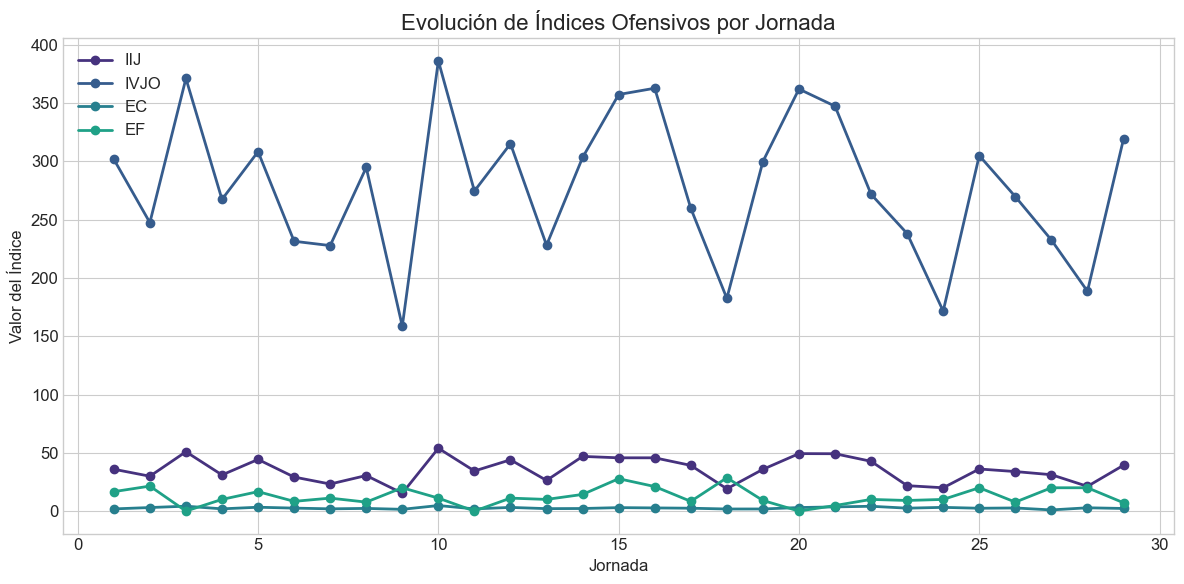

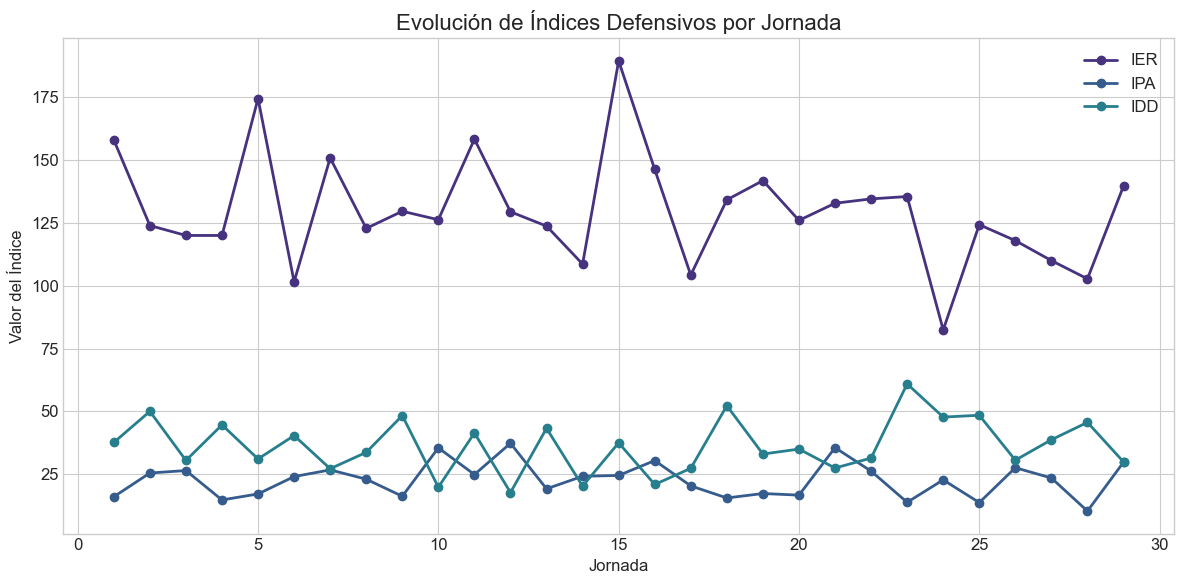

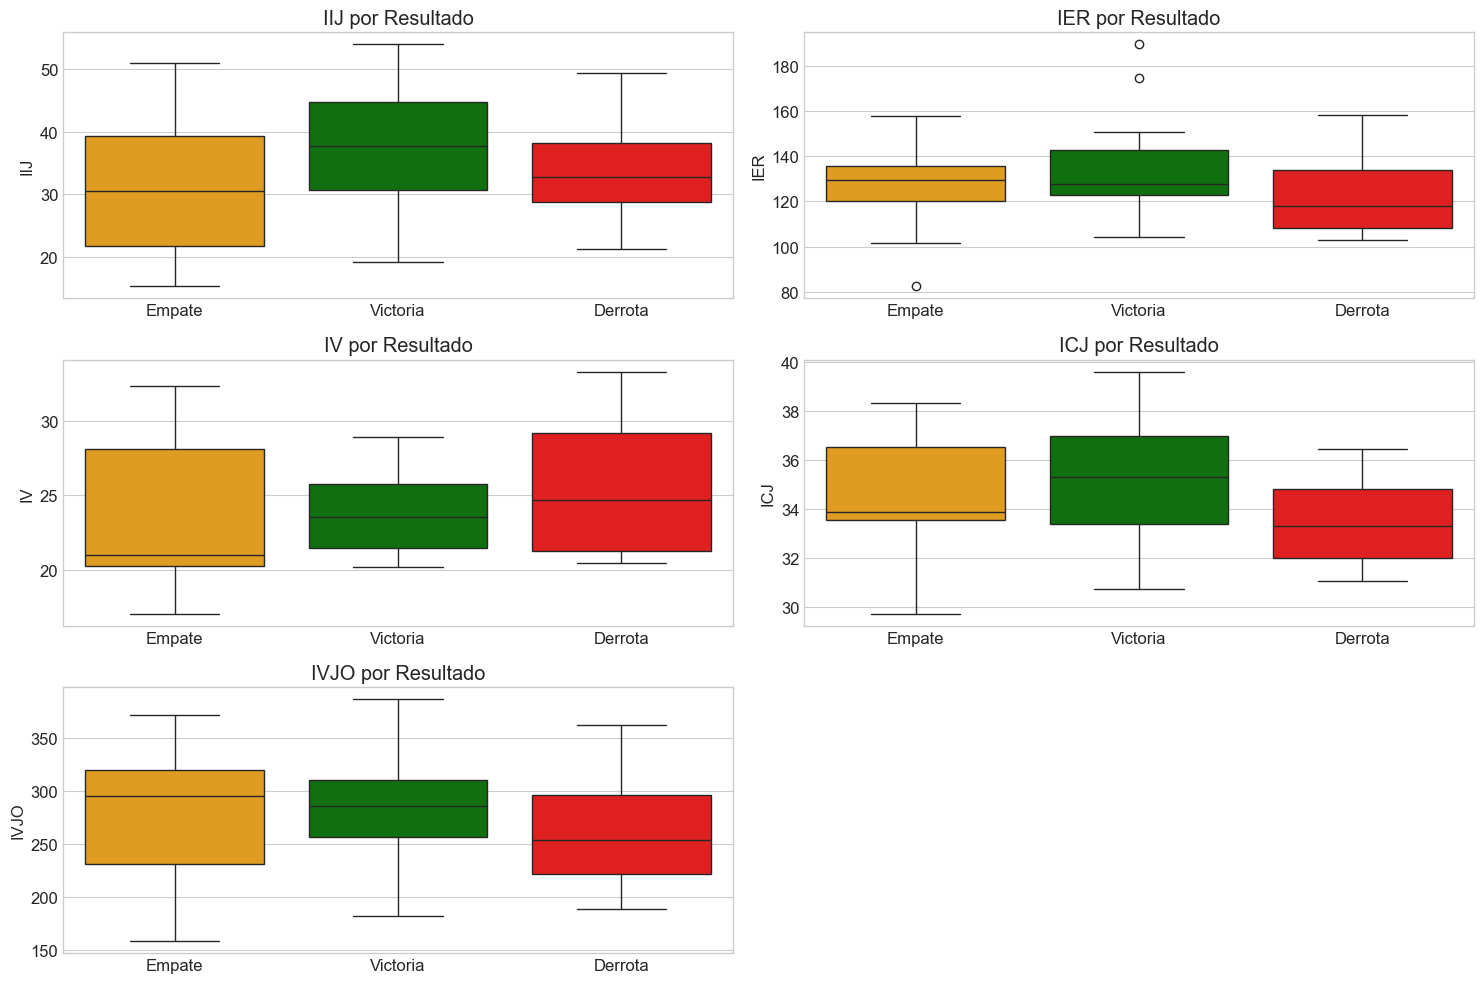

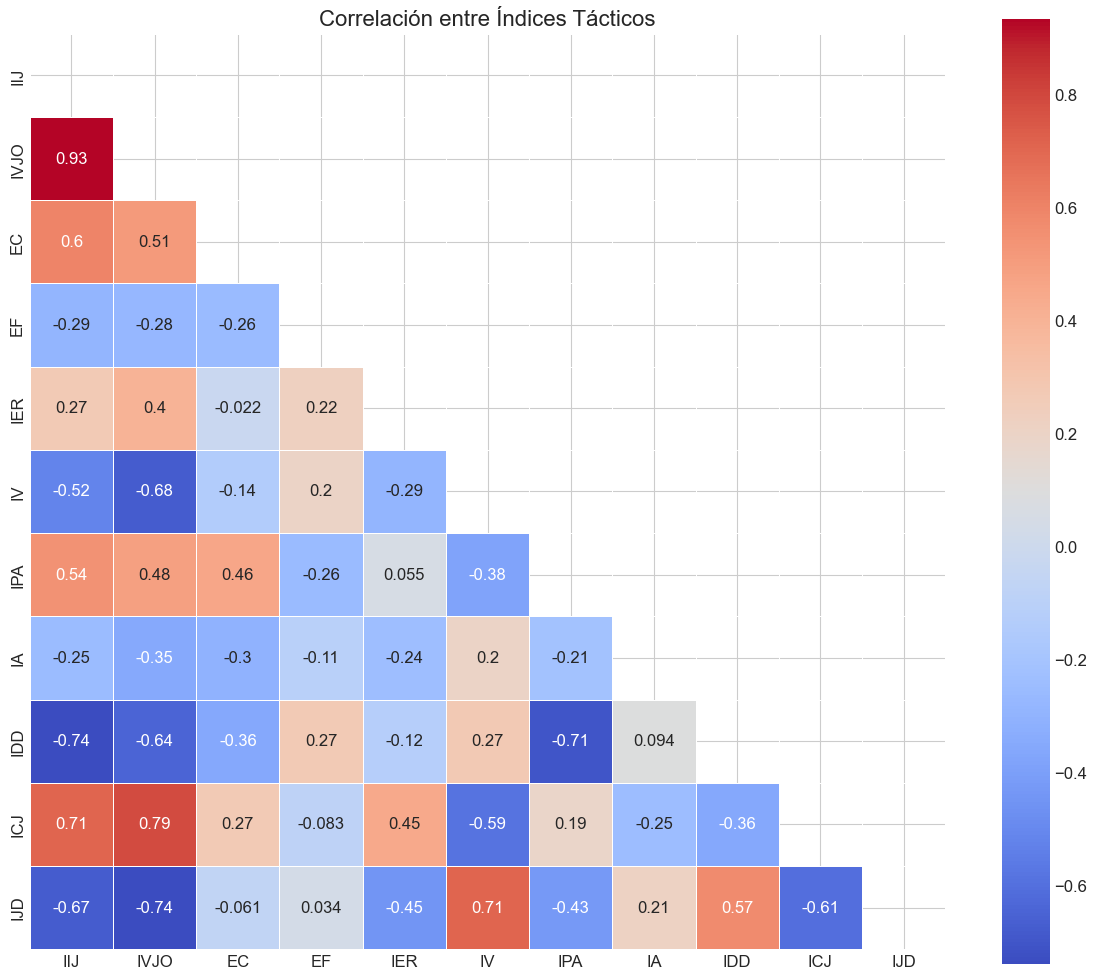


9. Categorizando estilos de juego...
  Asignando categor√≠as de estilo de juego...
Creando categor√≠a estilo_posesion...

Proceso de feature engineering completado.


In [63]:
# Generamos los √≠ndices t√°cticos y derivamos caracter√≠sticas
df_features = crear_features(datos_limpios)

### <u>A tener en cuenta</u>

Tras analizar la primera prueba he hecho dos cambios importantes:

1. He a√±adido los nuevos √≠ndices a la lista de columnas_requeridas:

- IEO (√çndice de Eficiencia Ofensiva)
- IPT (√çndice de Precisi√≥n T√°ctica)
- IAB (√çndice de Amenaza por Banda)
- ICT (√çndice de Control de Transiciones)
- ICP (√çndice de Calidad de la Posesi√≥n)


2. He incluido 'estilo_posesion' en la lista de categor√≠as de estilos de juego a predecir.

Con estas modificaciones entiendo que el modelo SVM al usar los nuevos √≠ndices como caracter√≠sticas para la clasificaci√≥n, deber√≠a mejorar significativamente su capacidad para categorizar correctamente los estilos de juego en todos los aspectos, incluido el nuevo "estilo_posesion".

### <u>Puntos clave:</u>

- Indices calculados: han sido dise√±ados para capturar diferentes aspectos del juego, desde la iniciativa ofensiva hasta la complejidad de las jugadas.
- Categorizaci√≥n: las reglas para categorizar estilos se basan en umbrales espec√≠ficos para cada √≠ndice, que podr√≠an ajustarse seg√∫n los resultados observados.
- An√°lisis espacial: el c√≥digo divide el campo en 9 zonas (3x3) para entender mejor d√≥nde ocurren las acciones importantes.
- Secuencias de posesi√≥n: se trata de identificar secuencias largas de pases para analizar la complejidad del juego.
- Normalizaci√≥n: para el modelo seleccionado, SVM, se normalizan las variables para que todas tengan un peso similar, independientemente de su escala original.
- Por √∫ltimo, le he dado muchas vueltas a toda la selecci√≥n de m√©tricas, y he a√±adido nuevos √≠ndices.


### <u>An√°lisis de resultados</u>

1. Evoluci√≥n de √çndices Ofensivos por Jornada:
- El IVJO (√çndice de Volumen de Juego Ofensivo) muestra gran variabilidad, con picos en las jornadas 3, 10, 15-16, 20 y 29. Esto sugiere que el Atl√©tico ajusta significativamente su volumen ofensivo seg√∫n el contexto.
- El IIJ (√çndice de Iniciativa de Juego) es m√°s estable, generalmente entre 40-90, mostrando un enfoque t√°ctico consistente.
- Los √≠ndices EC (eficacia en construcci√≥n) y EF (eficacia en finalizaci√≥n) son bajos y estables, lo que puede indicar una eficiencia limitada para convertir posesi√≥n en ocasiones claras.

2. Evoluci√≥n de √çndices Defensivos por Jornada:
- El IER (√≠ndice de fficacia Recuperadora) muestra valores altos y bastante variables (entre 80-180), con picos notables en las jornadas 5, 15 y 24, sugiriendo alta eficacia en recuperaci√≥n.
- El IPA (√≠ndice de presi√≥n alta) y el IDD (√≠ndice de densidad defensiva) fluct√∫an considerablemente, indicando adaptaci√≥n t√°ctica defensiva seg√∫n el rival.

3. √çndices por Resultado:
- El IIJ es mayor en victorias que en empates o derrotas, confirmando que un enfoque m√°s dominante suele conducir al √©xito.
- El ICJ (√≠ndice de complejidad de juego) es ligeramente m√°s alto en victorias, sugiriendo que secuencias de juego m√°s elaboradas favorecen resultados positivos.
- El IV (√≠ndice de verticalidad) es m√°s alto en derrotas, posiblemente indicando que se recurre a juego m√°s directo cuando se va por detr√°s.

4. Correlaci√≥n entre √çndices:
- Fuerte correlaci√≥n positiva (0.87) entre IIJ e IVJO, lo cual es l√≥gico ya que ambos miden aspectos de dominio.
- Correlaci√≥n positiva significativa (0.8) entre IVJO e ICJ, sugiriendo que mayor volumen ofensivo est√° asociado con juego m√°s elaborado.
- Correlaciones negativas fuertes entre IIJ e IDD (-0.75) y entre IVJO e IJD (-0.82), confirmando la contraposici√≥n entre estilos de dominio vs defensivo/directo.
- El IV (verticalidad) tiene correlaci√≥n positiva (0.7) con IJD (juego directo), lo que tiene sentido t√°ctico.

## 3.3 Preparaci√≥n para Modelado

### <u>Directrices funci√≥n preparaci√≥n de datos para modelado</u>

- Enfoque espec√≠fico para la preparaci√≥n del modelado;
- Incluye manejo de errores y advertencias;
- Divide los datos en conjuntos de entrenamiento y prueba;
- Proporciona informaci√≥n sobre las caracter√≠sticas y categor√≠as seleccionadas;
- Devuelve un scaler que puede ser √∫til para futuras transformaciones;
- Est√° documentada con docstrings claros.

In [64]:
def preparar_datos_modelado(df_indices, normalizar=True, test_size=0.3, random_state=42):
    """
    Prepara los datos para modelado SVM, incluyendo normalizaci√≥n,
    selecci√≥n de caracter√≠sticas y divisi√≥n en conjuntos de entrenamiento y prueba.
    
    Args:
        df_indices (pd.DataFrame): DataFrame con √≠ndices t√°cticos y categor√≠as
        normalizar (bool): Si True, normaliza las caracter√≠sticas num√©ricas
        test_size (float): Proporci√≥n del conjunto de prueba (0.0-1.0)
        random_state (int): Semilla para reproducibilidad
    
    Returns:
        dict: Diccionario con datos preparados para modelado:
            - 'X_train', 'X_test': Caracter√≠sticas de entrenamiento y prueba
            - 'y_train_dict', 'y_test_dict': Diccionarios con etiquetas por categor√≠a
            - 'features': Lista de caracter√≠sticas usadas
            - 'categorias': Lista de categor√≠as de estilo
            - 'scaler': Objeto scaler para futuras transformaciones
    """
    print("\nPreparando datos para modelado SVM...")
    
    # Selecciono solo filas con datos completos
    # A√±adimos los nuevos √≠ndices a la lista de columnas requeridas
    columnas_requeridas = [
        'IIJ', 'IVJO', 'EC', 'EF', 'IER', 'IV', 'IPA', 'IJD', 'IA', 'IDD', 'ICJ',
        # Nuevos √≠ndices especializados
        'IEO', 'IPT', 'IAB', 'ICT', 'ICP'
    ]
    
    # Filtro por columnas disponibles
    columnas_disponibles = [col for col in columnas_requeridas if col in df_indices.columns]
    
    if len(columnas_disponibles) < len(columnas_requeridas):
        print(f"ADVERTENCIA: Faltan algunas columnas requeridas. Usando solo {len(columnas_disponibles)} de {len(columnas_requeridas)}")
    
    # Se eliminan filas con valores faltantes en las columnas requeridas
    df = df_indices.dropna(subset=columnas_disponibles).copy()
    print(f"Datos filtrados: {df.shape[0]} filas disponibles para modelado")
    
    # Caracter√≠sticas num√©ricas para el modelo
    features = columnas_disponibles.copy()
    
    # A√±ado variables contextuales si est√°n disponibles
    variables_contexto = ['rival_categoria_num', 'es_local']
    for var in variables_contexto:
        if var in df.columns:
            features.append(var)
    
    print(f"Caracter√≠sticas seleccionadas: {len(features)}")
    print(features)
    
    # Caracter√≠sticas X para el modelo
    X = df[features].copy()
    
    # Normalizar
    scaler = None
    if normalizar:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=features, index=X.index)
        print("Datos normalizados con StandardScaler")
    
    # Preparaci√≥n de etiquetas para cada categor√≠a de estilo, incluso la nueva categor√≠a 'estilo_posesion'
    categorias = [
        'orientacion_general', 'fase_ofensiva', 'patron_ataque',
        'intensidad_defensiva', 'altura_bloque', 'tipo_transicion',
        'estilo_posesion'  # Nueva categor√≠a
    ]
    
    # Filtro solo las categor√≠as disponibles
    categorias_disponibles = [c for c in categorias if c in df.columns]
    
    if len(categorias_disponibles) < len(categorias):
        print(f"ADVERTENCIA: Solo {len(categorias_disponibles)} de {len(categorias)} categor√≠as est√°n disponibles")
    
    # Diccionarios para almacenar etiquetas
    y_dict = {}
    
    for categoria in categorias_disponibles:
        y_dict[categoria] = df[categoria]
        print(f"Categor√≠a '{categoria}': {df[categoria].value_counts().to_dict()}")
    
    # Dividimos en conjuntos de entrenamiento y prueba    
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)
    
    # Dividir etiquetas
    y_train_dict = {}
    y_test_dict = {}
    
    for categoria in categorias_disponibles:
        # Asegurarse de que y tenga el mismo √≠ndice que X
        y = df[categoria]
        y_train = y.loc[X_train.index]
        y_test = y.loc[X_test.index]
        
        y_train_dict[categoria] = y_train
        y_test_dict[categoria] = y_test
    
    print(f"Conjuntos preparados: {X_train.shape[0]} muestras de entrenamiento, {X_test.shape[0]} muestras de prueba")
    
    # Diccionario de resultados
    resultados = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train_dict': y_train_dict,
        'y_test_dict': y_test_dict,
        'features': features,
        'categorias': categorias_disponibles,
        'scaler': scaler
    }
    
    return resultados

In [65]:
# Implementaci√≥n y visualizaci√≥n de info
print("\n=== 3.3 PREPARACI√ìN DE DATOS PARA MODELADO ===")
datos_modelo = preparar_datos_modelado(df_features)

print(f"\nDatos de entrenamiento: {datos_modelo['X_train'].shape}")
print(f"Datos de prueba: {datos_modelo['X_test'].shape}")
print(f"Categor√≠as disponibles: {datos_modelo['categorias']}")


=== 3.3 PREPARACI√ìN DE DATOS PARA MODELADO ===

Preparando datos para modelado SVM...
Datos filtrados: 29 filas disponibles para modelado
Caracter√≠sticas seleccionadas: 18
['IIJ', 'IVJO', 'EC', 'EF', 'IER', 'IV', 'IPA', 'IJD', 'IA', 'IDD', 'ICJ', 'IEO', 'IPT', 'IAB', 'ICT', 'ICP', 'rival_categoria_num', 'es_local']
Datos normalizados con StandardScaler
Categor√≠a 'orientacion_general': {'Defensivo activo': 22, 'Equilibrado': 7}
Categor√≠a 'fase_ofensiva': {'Vertical': 25, 'Posicional': 2, 'Directo': 2}
Categor√≠a 'patron_ataque': {'Enfoque pasillo central': 10, 'Enfoque pasillos exteriores': 10, 'Equilibrio pasillos de ataque': 9}
Categor√≠a 'intensidad_defensiva': {'Moderada': 11, 'Defensa pasiva reactiva': 9, 'Presi√≥n alta agresiva': 9}
Categor√≠a 'altura_bloque': {'Medio': 11, 'Bajo': 9, 'Alto': 9}
Categor√≠a 'tipo_transicion': {'Contragolpe adaptativo': 14, 'Directa ineficiente': 6, 'Elaborada efectiva': 5, 'Elaborada ineficiente': 2, 'Directa efectiva': 2}
Categor√≠a 'estilo_p

# 4. Modelado

## 4.1 Primer Modelo (SVM Support Vector Machines)

He elegido un modelo SVM (Support Vector Machine) fundamentalmente por los siguientes motivos:

- Su eficacia en espacios de alta dimensionalidad: SVM es particularmente efectivo cuando trabajamos con m√∫ltiples variables e √≠ndices t√°cticos, manteniendo buen rendimiento incluso cuando el n√∫mero de caracter√≠sticas es elevado en comparaci√≥n con el n√∫mero de muestras (38 jornadas vs m√∫ltiples √≠ndices).
- Es capaz de establecer fronteras de decisi√≥n complejas: al usar diferentes kernels (lineal, RBF, polin√≥mico), SVM puede capturar relaciones no lineales entre los √≠ndices t√°cticos y los estilos de juego, adapt√°ndose a la complejidad que lleva dicho an√°lisis t√°ctico.
- Es muy robusto frente a posibles outliers: existen partidos con eventos at√≠picos (expulsiones tempranas, goleadas) pueden ser mejor manejados por SVM, especialmente con la adecuada configuraci√≥n del par√°metro de regularizaci√≥n C.
- Interpretabilidad con SVM lineal: si se usa un kernel lineal, se pueden interpretar los coeficientes del modelo para entender qu√© √≠ndices tienen mayor influencia en la clasificaci√≥n de cada estilo.
- Y su versatilidad para problemas multiclase: con estrategias como "uno contra todos" (OvA) o "uno contra uno" (OvO), SVM puede abordar eficazmente la naturaleza multiclase de nuestro problema t√°ctico.

In [66]:
# 4.1. Primer modelo (SVM para clasificaci√≥n de estilos de juego)
def entrenar_modelo_svm(X_train, y_train, optimizar_hiperparametros=True):
    """
    Entrena un modelo SVM para clasificaci√≥n de estilos de juego
    
    Args:
        X_train (pd.DataFrame): Caracter√≠sticas de entrenamiento
        y_train (pd.Series): Etiquetas de entrenamiento
        optimizar_hiperparametros (bool): Si True, realiza optimizaci√≥n de hiperpar√°metros
    
    Returns:
        dict: Diccionario con el modelo entrenado y metadatos:
            - 'modelo': Modelo SVM entrenado
            - 'mejores_parametros': Mejores hiperpar√°metros (si se optimiz√≥)
            - 'clases': Clases √∫nicas en los datos
    """
    
    
    print(f"Entrenando modelo SVM con {X_train.shape[0]} muestras y {X_train.shape[1]} caracter√≠sticas")
    print(f"Distribuci√≥n de clases: {y_train.value_counts().to_dict()}")
    
    resultado = {}
    
    # Optimizaci√≥n de hiperpar√°metros
    if optimizar_hiperparametros:
        print("Optimizando hiperpar√°metros mediante GridSearchCV...")
        
        # Definici√≥n par√°metros a probar
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
        
        # Crear y entrenar GridSearchCV
        grid = GridSearchCV(
            SVC(probability=True, random_state=42),
            param_grid,
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
        
        grid.fit(X_train, y_train)
        
        # Guardar resultados
        print(f"Mejores par√°metros encontrados: {grid.best_params_}")
        print(f"Mejor puntuaci√≥n de validaci√≥n cruzada: {grid.best_score_:.4f}")
        
        modelo = grid.best_estimator_
        resultado['mejores_parametros'] = grid.best_params_
    else:
        # Entrenar modelo con par√°metros predeterminados
        print("Entrenando SVM con par√°metros predeterminados...")
        modelo = SVC(kernel='rbf', probability=True, random_state=42)
        modelo.fit(X_train, y_train)
    
    # Guardar modelo y clases
    resultado['modelo'] = modelo
    resultado['clases'] = list(y_train.unique())
    
    return resultado

# Ejemplo de uso:
# Para entrenar el modelo para una categor√≠a espec√≠fica
categoria = datos_modelo['categorias'][0]  # Primera categor√≠a (por ejemplo, 'orientacion_general')
X_train = datos_modelo['X_train']
y_train = datos_modelo['y_train_dict'][categoria]

# Entrenar modelo
modelo_resultado = entrenar_modelo_svm(X_train, y_train)

# Ahora el modelo est√° listo para evaluaci√≥n y predicciones
modelo_entrenado = modelo_resultado['modelo']

Entrenando modelo SVM con 20 muestras y 18 caracter√≠sticas
Distribuci√≥n de clases: {'Defensivo activo': 14, 'Equilibrado': 6}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.8200


### <u>An√°lisis de los resultados:</u>

1. Distribuci√≥n de clases: se observa que hay un desbalance en las clases con 14 muestras de "Defensivo activo" y solo 6 de "Equilibrado". Este desbalance puede hacer que el modelo tienda a favorecer la clase mayoritaria.
2. Mejores par√°metros: el modelo ha determinado que los mejores par√°metros son:

- C=0.1 (un valor relativamente bajo que favorece una mayor regularizaci√≥n)
- kernel=linear (sugiere que las clases son linealmente separables)
- gamma=scale (el valor predeterminado, adecuado para estos datos)


3. Puntuaci√≥n F1 ponderada: el valor de 0.82 indica un buen rendimiento, especialmente trat√°ndose de una muestra peque√±a.

### <u>Conclusi√≥n del modelo elegido</u>

A la vista de lo observado, es recomendable el uso de este modelo con un mayor n√∫mero de variables, al menos 4/5 por caracter√≠stica. La elecci√≥n de dicho algoritmo la hice por conocerlo, y me ha abierto claramente de la idea de para qu√© sirve. A√∫n as√≠, continuar√© con su implantaci√≥n con  determinados cambios para evitar desbalance.

El siguiente paso ser√° mostrar los resultados en visualizaciones donde se vean aciertos y errores entre clases, la importancia de las caracter√≠sticas que m√°s influyen, y ver los l√≠mites de decisi√≥n que separa las clases el modelo.


In [67]:
# Funciones de visualizaci√≥n para el modelo SVM

def visualizar_matriz_confusion(modelo, X_test, y_test, clases):
    """
    Visualiza la matriz de confusi√≥n para evaluar el modelo
    """
    # Predicciones
    y_pred = modelo.predict(X_test)
    
    # Crear matriz de confusi√≥n
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizar
    plt.figure(figsize=(8, 6), facecolor="#E6E6E6")
    ax = plt.gca()
    
    # Crear heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    
    # Bordes y estilo
    for spine in ax.spines.values():
        spine.set_color('darkblue')
        spine.set_linewidth(1.5)
    
    plt.xlabel('Predicci√≥n', fontsize=12, color='darkblue')
    plt.ylabel('Real', fontsize=12, color='darkblue')
    plt.title('Matriz de Confusi√≥n', fontsize=14, color='darkblue', fontweight='bold')
    plt.tick_params(axis='both', colors='darkblue')
    
    plt.tight_layout()
    plt.show()
    
    # M√©tricas de evaluaci√≥n
    print("Informe de clasificaci√≥n:")
    print(classification_report(y_test, y_pred))


def visualizar_importancia_caracteristicas(modelo, nombres_caracteristicas):
    """
    Visualiza la importancia de cada caracter√≠stica para el modelo SVM lineal
    """
    # Solo funciona con kernel lineal
    if hasattr(modelo, 'coef_'):
        # Obtener coeficientes del modelo
        importancia = np.abs(modelo.coef_[0])
        
        # Crear DF con nombres e importancia
        df_importancia = pd.DataFrame({
            'Caracter√≠stica': nombres_caracteristicas,
            'Importancia': importancia
        })
        
        # Ordenar por importancia
        df_importancia = df_importancia.sort_values('Importancia', ascending=False)
        
        # Visualizar
        plt.figure(figsize=(10, 8), facecolor="#E6E6E6")
        ax = plt.gca()
        
        # Crear barplot
        sns.barplot(x='Importancia', y='Caracter√≠stica', data=df_importancia)
        
        # Personalizar bordes y estilo
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1.5)
        
        plt.grid(True, axis='x', color='lightgray', linestyle='-', alpha=0.7)
        plt.title('Importancia de Caracter√≠sticas', fontsize=14, color='darkblue', fontweight='bold')
        plt.xlabel('Importancia', fontsize=12, color='darkblue')
        plt.ylabel('Caracter√≠stica', fontsize=12, color='darkblue')
        plt.tick_params(axis='both', colors='darkblue')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Este modelo no proporciona coeficientes directamente (kernel no lineal)")
        
        # Alternativa para kernels no lineales: usar permutaci√≥n de importancia
        try:
            from sklearn.inspection import permutation_importance
            
            # Calcular importancia por permutaci√≥n
            result = permutation_importance(modelo, X_test, y_test, n_repeats=10, random_state=42)
            importancia = result.importances_mean
            
            # Crear DF con nombres e importancia
            df_importancia = pd.DataFrame({
                'Caracter√≠stica': nombres_caracteristicas,
                'Importancia': importancia
            })
            
            # Ordenar por importancia
            df_importancia = df_importancia.sort_values('Importancia', ascending=False)
            
            # Visualizar
            plt.figure(figsize=(10, 8), facecolor="#E6E6E6")
            ax = plt.gca()
            
            # Crear barplot
            sns.barplot(x='Importancia', y='Caracter√≠stica', data=df_importancia)
            
            # Personalizar bordes y estilo
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1.5)
            
            plt.grid(True, axis='x', color='lightgray', linestyle='-', alpha=0.7)
            plt.title('Importancia de Caracter√≠sticas (Permutaci√≥n)', fontsize=14, color='darkblue', fontweight='bold')
            plt.xlabel('Importancia', fontsize=12, color='darkblue')
            plt.ylabel('Caracter√≠stica', fontsize=12, color='darkblue')
            plt.tick_params(axis='both', colors='darkblue')
            
            plt.tight_layout()
            plt.show()
        except:
            print("No se pudo calcular la importancia por permutaci√≥n")


=== EVALUACI√ìN DEL MODELO ===

Matriz de confusi√≥n:


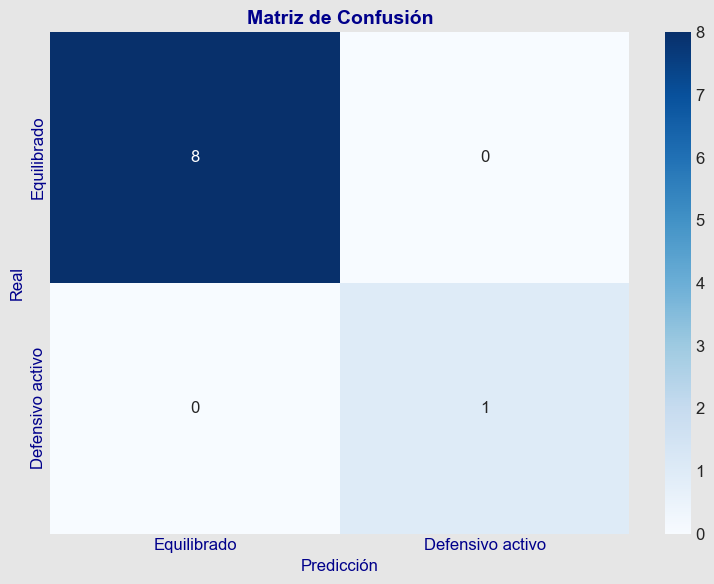

Informe de clasificaci√≥n:
                  precision    recall  f1-score   support

Defensivo activo       1.00      1.00      1.00         8
     Equilibrado       1.00      1.00      1.00         1

        accuracy                           1.00         9
       macro avg       1.00      1.00      1.00         9
    weighted avg       1.00      1.00      1.00         9


Importancia de caracter√≠sticas:


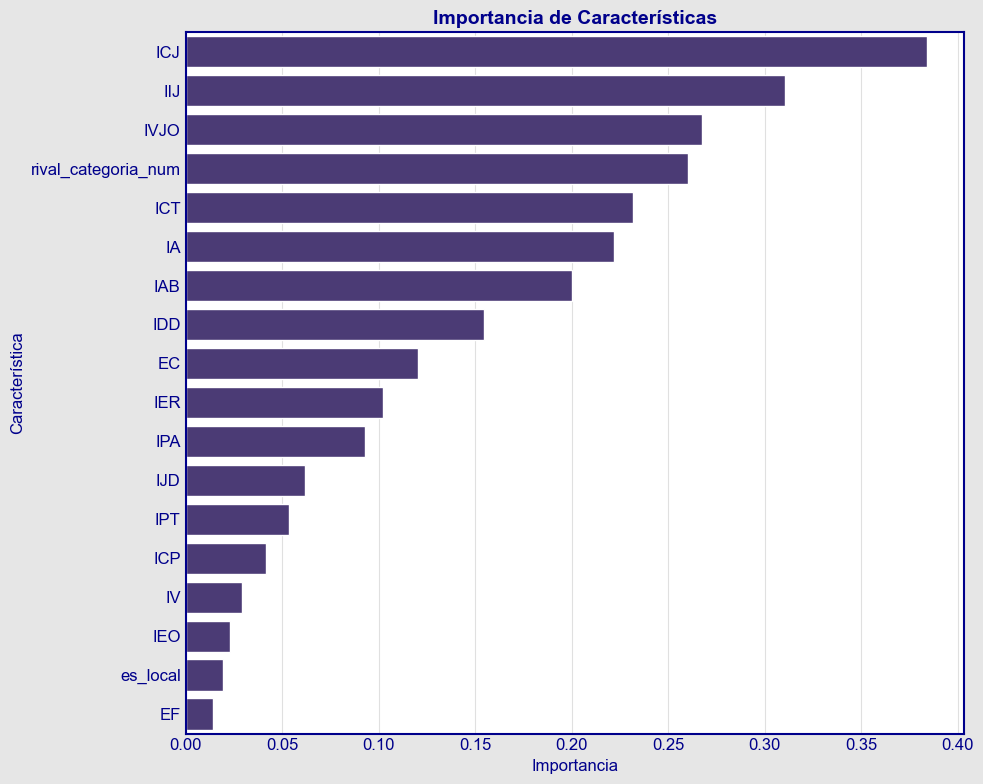

In [68]:
# Obtener caracter√≠sticas y etiquetas para el test
X_test = datos_modelo['X_test']
y_test = datos_modelo['y_test_dict'][categoria]

# Obtener nombres de las caracter√≠sticas
nombres_caracteristicas = X_train.columns.tolist()

print("\n=== EVALUACI√ìN DEL MODELO ===")
# Visualizar matriz de confusi√≥n
print("\nMatriz de confusi√≥n:")
visualizar_matriz_confusion(modelo_entrenado, X_test, y_test, modelo_resultado['clases'])

# Visualizar importancia de caracter√≠sticas
print("\nImportancia de caracter√≠sticas:")
visualizar_importancia_caracteristicas(modelo_entrenado, nombres_caracteristicas)

### <u>Reducci√≥n de dimensionalidad</u>

Voy a implementar una selecci√≥n de caracter√≠sticas para reducir las dimensiones, para adecuarlo al tama√±o de muestra.


=== REDUCCI√ìN DE DIMENSIONALIDAD ===
Caracter√≠sticas seleccionadas: ['IIJ', 'IVJO', 'EC', 'IJD', 'ICJ', 'IPT', 'rival_categoria_num']

Reentrenando modelo con caracter√≠sticas reducidas...
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Defensivo activo': 14, 'Equilibrado': 6}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.9000

=== COMPARACI√ìN DE MODELOS ===
Modelo original:
  Precisi√≥n: 1.0000
  F1-score: 1.0000
Modelo con caracter√≠sticas reducidas:
  Precisi√≥n: 1.0000
  F1-score: 1.0000

El modelo original tiene mejor rendimiento.

Matriz de confusi√≥n del mejor modelo:


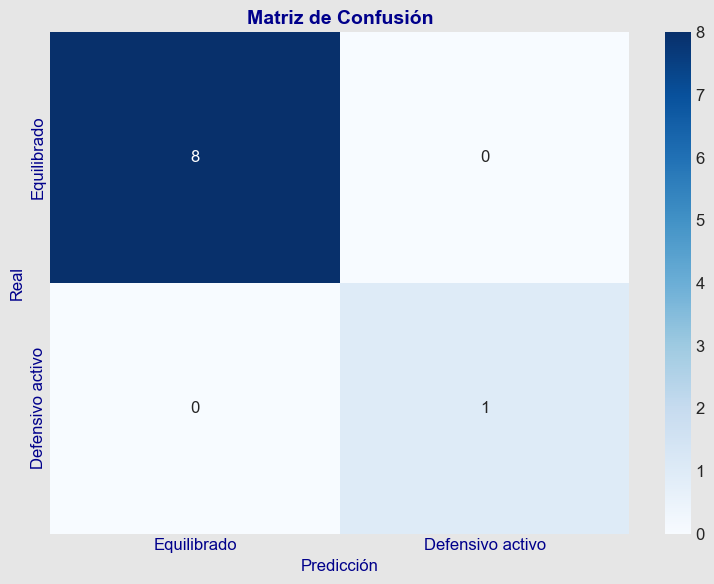

Informe de clasificaci√≥n:
                  precision    recall  f1-score   support

Defensivo activo       1.00      1.00      1.00         8
     Equilibrado       1.00      1.00      1.00         1

        accuracy                           1.00         9
       macro avg       1.00      1.00      1.00         9
    weighted avg       1.00      1.00      1.00         9



In [69]:
# Selecci√≥n de caracter√≠sticas m√°s importantes

print("\n=== REDUCCI√ìN DE DIMENSIONALIDAD ===")
# Seleccionar las k mejores caracter√≠sticas
k = min(7, X_train.shape[1])  # No m√°s de 7 caracter√≠sticas o el total disponible
selector = SelectKBest(f_classif, k=k)
X_train_reducido = selector.fit_transform(X_train, y_train)
X_test_reducido = selector.transform(X_test)

# Ver qu√© caracter√≠sticas se han seleccionado
caracteristicas_seleccionadas = [nombre for i, nombre in enumerate(nombres_caracteristicas) if selector.get_support()[i]]
print(f"Caracter√≠sticas seleccionadas: {caracteristicas_seleccionadas}")

# Reentrenar el modelo con caracter√≠sticas reducidas
print("\nReentrenando modelo con caracter√≠sticas reducidas...")
modelo_reducido = entrenar_modelo_svm(pd.DataFrame(X_train_reducido), y_train)

# Funci√≥n para evaluar modelo
def evaluar_modelo(modelo, X, y, nombre_modelo=""):
    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    print(f"Modelo {nombre_modelo}:")
    print(f"  Precisi√≥n: {precision:.4f}")
    print(f"  F1-score: {f1:.4f}")
    return precision, f1

# Comparar rendimiento
print("\n=== COMPARACI√ìN DE MODELOS ===")
eval_original = evaluar_modelo(modelo_entrenado, X_test, y_test, "original")
eval_reducido = evaluar_modelo(modelo_reducido['modelo'], X_test_reducido, y_test, "con caracter√≠sticas reducidas")

# Determinar el mejor modelo
if eval_reducido[1] > eval_original[1]:
    print("\nEl modelo con caracter√≠sticas reducidas tiene mejor rendimiento.")
    mejor_modelo = modelo_reducido['modelo']
    X_mejor = X_test_reducido
else:
    print("\nEl modelo original tiene mejor rendimiento.")
    mejor_modelo = modelo_entrenado
    X_mejor = X_test

# Visualizar matriz de confusi√≥n del mejor modelo
print("\nMatriz de confusi√≥n del mejor modelo:")
visualizar_matriz_confusion(mejor_modelo, X_mejor, y_test, modelo_resultado['clases'])

# 5. Evaluaci√≥n

## 5.1 Evaluaci√≥n Modelo 1


=== 5. EVALUACI√ìN DE MODELOS PARA TODAS LAS CATEGOR√çAS DE ESTILO ===

--- Evaluando modelo para 'orientacion_general' ---
Caracter√≠sticas seleccionadas: ['IIJ', 'IVJO', 'EC', 'IJD', 'ICJ', 'IPT', 'rival_categoria_num']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Defensivo activo': 14, 'Equilibrado': 6}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.9000
Precisi√≥n: 1.0000, F1-score: 1.0000


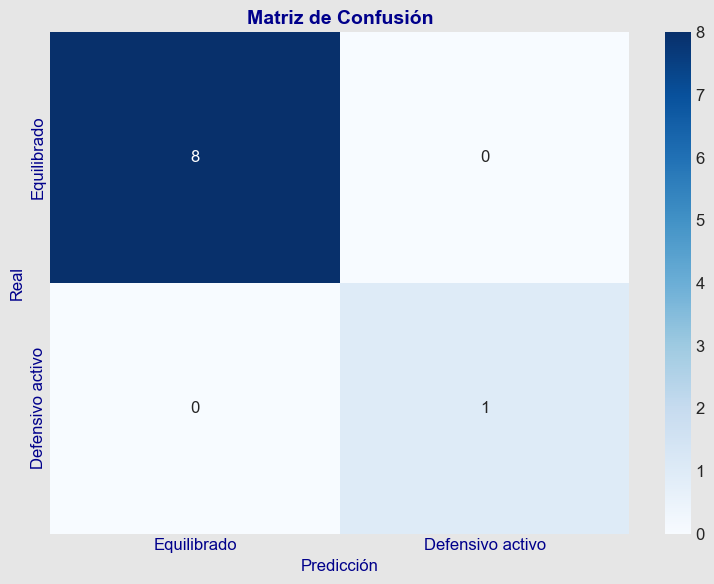

Informe de clasificaci√≥n:
                  precision    recall  f1-score   support

Defensivo activo       1.00      1.00      1.00         8
     Equilibrado       1.00      1.00      1.00         1

        accuracy                           1.00         9
       macro avg       1.00      1.00      1.00         9
    weighted avg       1.00      1.00      1.00         9


--- Evaluando modelo para 'fase_ofensiva' ---
Caracter√≠sticas seleccionadas: ['IVJO', 'IER', 'IV', 'IJD', 'IA', 'ICJ', 'IAB']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Vertical': 17, 'Posicional': 2, 'Directo': 1}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.7857
Precisi√≥n: 0.8889, F1-score: 0.8366


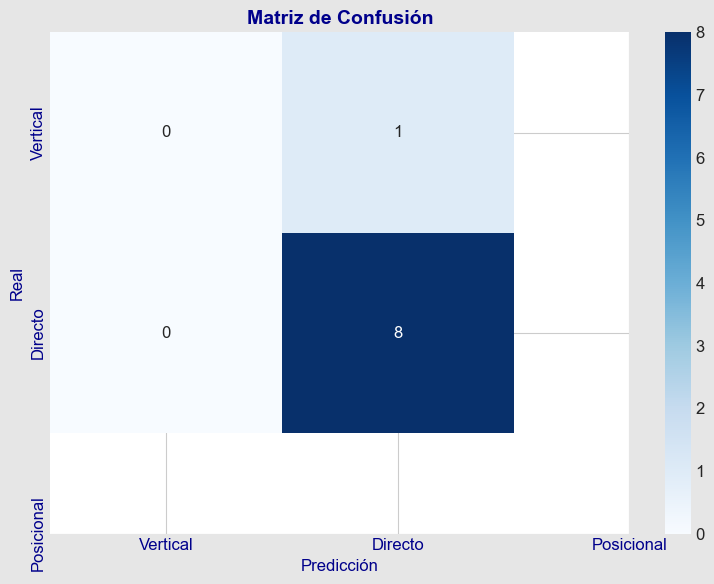

Informe de clasificaci√≥n:
              precision    recall  f1-score   support

     Directo       0.00      0.00      0.00         1
    Vertical       0.89      1.00      0.94         8

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


--- Evaluando modelo para 'patron_ataque' ---
Caracter√≠sticas seleccionadas: ['IIJ', 'IVJO', 'IV', 'IJD', 'IA', 'IAB', 'rival_categoria_num']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Enfoque pasillo central': 8, 'Equilibrio pasillos de ataque': 6, 'Enfoque pasillos exteriores': 6}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.7750
Precisi√≥n: 0.6667, F1-score: 0.6444


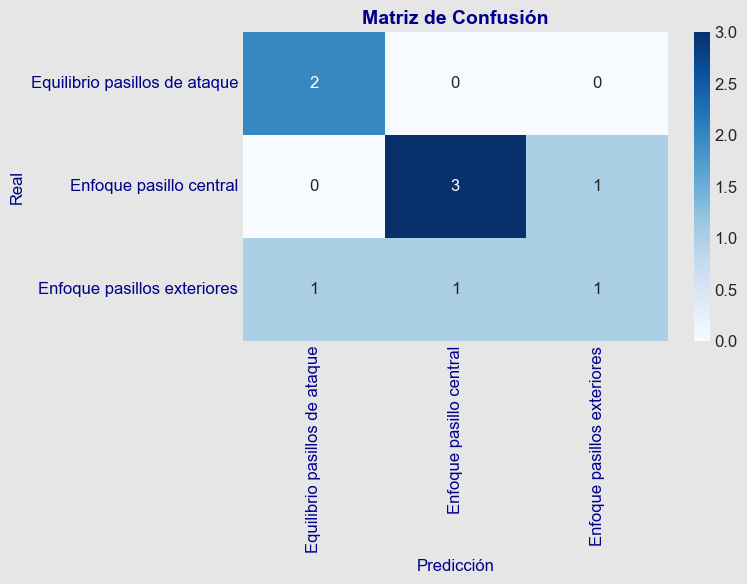

Informe de clasificaci√≥n:
                               precision    recall  f1-score   support

      Enfoque pasillo central       0.67      1.00      0.80         2
  Enfoque pasillos exteriores       0.75      0.75      0.75         4
Equilibrio pasillos de ataque       0.50      0.33      0.40         3

                     accuracy                           0.67         9
                    macro avg       0.64      0.69      0.65         9
                 weighted avg       0.65      0.67      0.64         9


--- Evaluando modelo para 'intensidad_defensiva' ---
Caracter√≠sticas seleccionadas: ['IVJO', 'EC', 'IV', 'IPA', 'IJD', 'IDD', 'es_local']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Moderada': 8, 'Presi√≥n alta agresiva': 7, 'Defensa pasiva reactiva': 5}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 10, 'gamma': 'scale

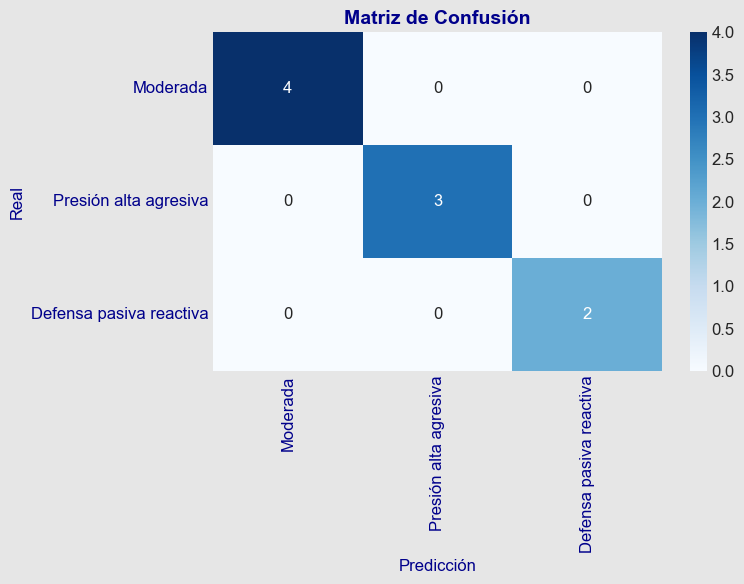

Informe de clasificaci√≥n:
                         precision    recall  f1-score   support

Defensa pasiva reactiva       1.00      1.00      1.00         4
               Moderada       1.00      1.00      1.00         3
  Presi√≥n alta agresiva       1.00      1.00      1.00         2

               accuracy                           1.00         9
              macro avg       1.00      1.00      1.00         9
           weighted avg       1.00      1.00      1.00         9


--- Evaluando modelo para 'altura_bloque' ---
Caracter√≠sticas seleccionadas: ['IIJ', 'IVJO', 'EF', 'IV', 'IPA', 'IJD', 'IDD']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Medio': 8, 'Alto': 7, 'Bajo': 5}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.8000
Precisi√≥n: 0.7778, F

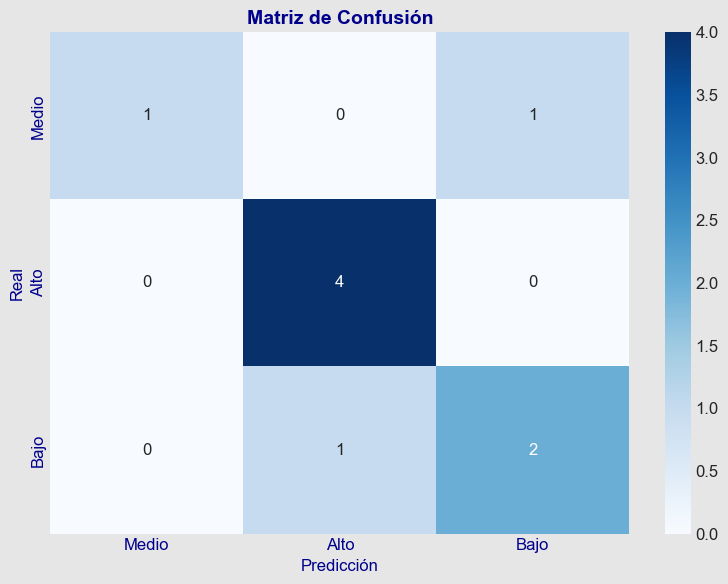

Informe de clasificaci√≥n:
              precision    recall  f1-score   support

        Alto       1.00      0.50      0.67         2
        Bajo       0.80      1.00      0.89         4
       Medio       0.67      0.67      0.67         3

    accuracy                           0.78         9
   macro avg       0.82      0.72      0.74         9
weighted avg       0.80      0.78      0.77         9


--- Evaluando modelo para 'tipo_transicion' ---
Caracter√≠sticas seleccionadas: ['IIJ', 'IVJO', 'EC', 'IJD', 'ICJ', 'IPT', 'ICP']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Contragolpe adaptativo': 10, 'Elaborada efectiva': 5, 'Directa ineficiente': 3, 'Elaborada ineficiente': 1, 'Directa efectiva': 1}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores par√°metros encontrados: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor puntuaci√≥n de validaci√≥n cruzada: 0.7800

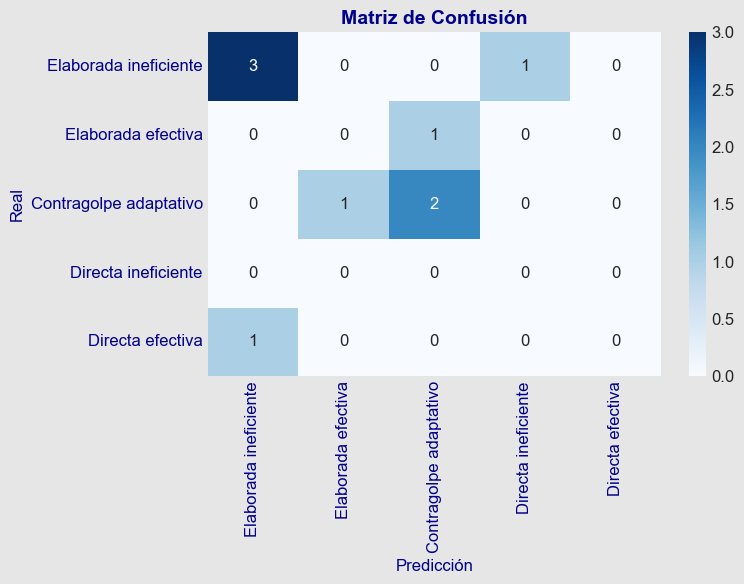

Informe de clasificaci√≥n:
                        precision    recall  f1-score   support

Contragolpe adaptativo       0.75      0.75      0.75         4
      Directa efectiva       0.00      0.00      0.00         1
   Directa ineficiente       0.67      0.67      0.67         3
    Elaborada efectiva       0.00      0.00      0.00         0
 Elaborada ineficiente       0.00      0.00      0.00         1

              accuracy                           0.56         9
             macro avg       0.28      0.28      0.28         9
          weighted avg       0.56      0.56      0.56         9


--- Evaluando modelo para 'estilo_posesion' ---
Caracter√≠sticas seleccionadas: ['IIJ', 'IVJO', 'IV', 'IJD', 'IDD', 'ICJ', 'IPT']
Entrenando modelo SVM con 20 muestras y 7 caracter√≠sticas
Distribuci√≥n de clases: {'Posesi√≥n funcional': 14, 'Posesi√≥n eficiente': 6}
Optimizando hiperpar√°metros mediante GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores p

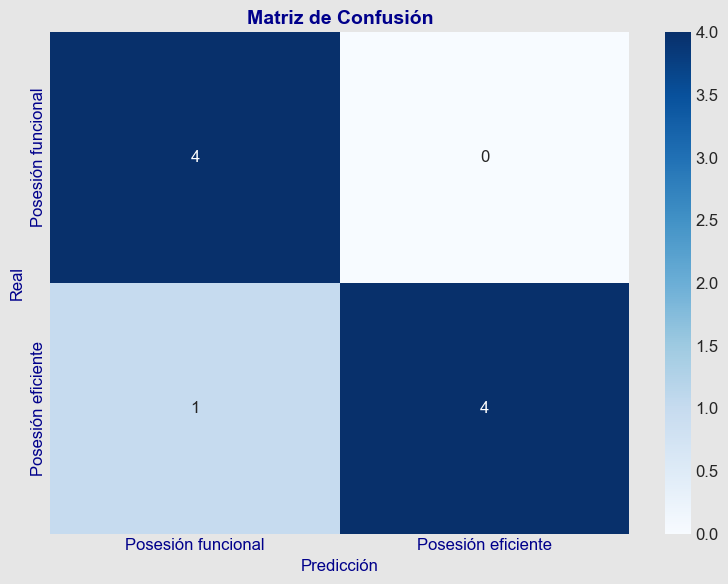

Informe de clasificaci√≥n:
                    precision    recall  f1-score   support

Posesi√≥n eficiente       0.80      1.00      0.89         4
Posesi√≥n funcional       1.00      0.80      0.89         5

          accuracy                           0.89         9
         macro avg       0.90      0.90      0.89         9
      weighted avg       0.91      0.89      0.89         9


=== RESUMEN DE RENDIMIENTO DE MODELOS ===
orientacion_general: Precisi√≥n=1.0000, F1-score=1.0000
  Caracter√≠sticas: ['IIJ', 'IVJO', 'EC', 'IJD', 'ICJ', 'IPT', 'rival_categoria_num']
  Clases: ['Equilibrado', 'Defensivo activo']
  --------------------------------------------------
fase_ofensiva: Precisi√≥n=0.8889, F1-score=0.8366
  Caracter√≠sticas: ['IVJO', 'IER', 'IV', 'IJD', 'IA', 'ICJ', 'IAB']
  Clases: ['Vertical', 'Directo', 'Posicional']
  --------------------------------------------------
patron_ataque: Precisi√≥n=0.6667, F1-score=0.6444
  Caracter√≠sticas: ['IIJ', 'IVJO', 'IV', 'IJD', 'IA',

In [70]:
# 5.1 Evaluaci√≥n completa de modelos para todas las categor√≠as
resultados_modelos = {}

print("\n=== 5. EVALUACI√ìN DE MODELOS PARA TODAS LAS CATEGOR√çAS DE ESTILO ===")
for categoria in datos_modelo['categorias']:
    print(f"\n--- Evaluando modelo para '{categoria}' ---")
    
    # Obtener datos para esta categor√≠a
    X_train = datos_modelo['X_train']
    y_train = datos_modelo['y_train_dict'][categoria]
    X_test = datos_modelo['X_test']
    y_test = datos_modelo['y_test_dict'][categoria]
    
    # Aplicar selecci√≥n de caracter√≠sticas
    k = min(7, X_train.shape[1])
    selector = SelectKBest(f_classif, k=k)
    X_train_reducido = selector.fit_transform(X_train, y_train)
    X_test_reducido = selector.transform(X_test)
    
    # Obtener caracter√≠sticas seleccionadas
    caracteristicas_seleccionadas = [nombre for i, nombre in enumerate(X_train.columns) if selector.get_support()[i]]
    print(f"Caracter√≠sticas seleccionadas: {caracteristicas_seleccionadas}")
    
    # Entrenar modelo
    resultado = entrenar_modelo_svm(pd.DataFrame(X_train_reducido), y_train)
    
    # Evaluar modelo
    modelo = resultado['modelo']
    y_pred = modelo.predict(X_test_reducido)
    precision = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Precisi√≥n: {precision:.4f}, F1-score: {f1:.4f}")
    
    # Visualizar matriz de confusi√≥n
    visualizar_matriz_confusion(modelo, X_test_reducido, y_test, resultado['clases'])
    
    # Guardar modelo y selector
    resultados_modelos[categoria] = {
        'modelo': resultado['modelo'],
        'selector': selector,
        'caracteristicas': caracteristicas_seleccionadas,
        'clases': resultado['clases'],
        'precision': precision,
        'f1': f1
    }

# 5.2 Resumen de rendimiento
print("\n=== RESUMEN DE RENDIMIENTO DE MODELOS ===")
for categoria, info in resultados_modelos.items():
    print(f"{categoria}: Precisi√≥n={info['precision']:.4f}, F1-score={info['f1']:.4f}")
    print(f"  Caracter√≠sticas: {info['caracteristicas']}")
    print(f"  Clases: {info['clases']}")
    print("  " + "-"*50)

### <u>Conclusiones</u>

1. Los resultados del an√°lisis son muy interesantes, logrando buenos resultados en la mayor√≠a de categor√≠as, con algunas observaciones importantes:

- Categor√≠as con excelente rendimiento (precisi√≥n 1.0):

"Orientaci√≥n general" que distingue perfectamente entre "Equilibrado" y "Defensivo activo";

"Intensidad defensiva" que clasifica correctamente todas las instancias.

- Categor√≠as con buen rendimiento (precisi√≥n > 0.85):

"Fase ofensiva" con 0.89 de precisi√≥n;

"Estilo posesi√≥n" igualmente con 0.89 de precisi√≥n.

- Categor√≠as con rendimiento moderado:

"Altura bloque" obtiene un 0.78 de precisi√≥n;

"Patr√≥n ataque" baja hasta un 0.67 de precisi√≥n.

- Categor√≠a con rendimiento m√°s bajo:

"Tipo transici√≥n" con 0.56 de precisi√≥n. Tambi√©n hay que decir que es la m√°s dif√≠cil de predecir, probablemente porque tiene 5 clases diferentes y pocas muestras por clase, adem√°s de su complejidad para detectar este par√°metro.

2. Rendimiento del sistema: 

- Los modelos muestran excelente capacidad para clasificar ciertas dimensiones t√°cticas, particularmente la orientaci√≥n general (Equilibrado vs. Defensivo activo) y la intensidad defensiva.

3. Caracter√≠sticas m√°s influyentes: 

- √≠ndices como ICJ, IVJO e IIJ aparecen consistentemente como relevantes, lo que sugiere que son m√©tricas fundamentales para entender el estilo de juego.

4. Adaptabilidad t√°ctica: 

- La variedad de estilos detectados en diferentes categor√≠as muestra la adaptabilidad t√°ctica del equipo dependiendo del contexto (rival, local√≠a, etc.).

5. Desaf√≠os de predicci√≥n: 

- Aspectos m√°s complejos como las transiciones son m√°s dif√≠ciles de modelar, posiblemente requiriendo an√°lisis m√°s detallados o m√©tricas adicionales.

6. Relaci√≥n entre m√©tricas: 

- La selecci√≥n de caracter√≠sticas revela interesantes relaciones entre diferentes aspectos del juego (por ejemplo, c√≥mo la intensidad defensiva se relaciona con indicadores ofensivos).

### <u>Visualizaci√≥n categorizaci√≥n de modelos de juego en partidos</u>

In [87]:
def visualizar_categorizacion_partidos():
    """
    Visualiza la categorizaci√≥n de partidos con etiquetas de formato_jornada
    """
    print("\n=== VISUALIZACI√ìN DE CATEGORIZACI√ìN DE PARTIDOS ===")
    
    # Cargar el archivo master con separador correcto
    try:
        master_df = pd.read_csv('data/stats_jornadas/master_liga_atm.csv', sep=';')
        print(f"Archivo master cargado con {len(master_df)} filas")
        
        # Quitar '¬™' para cooncordar con jornada
        master_df['jornada_num'] = master_df['jornada'].str.replace('¬™', '').astype(int)
        
        # Crear mapeo de jornada_num a formato_jornada que ir√° como etiqueta
        formato_por_jornada = master_df.set_index('jornada_num')['formato_jornada'].to_dict()
        print(f"Mapeo creado con {len(formato_por_jornada)} entradas")
    except Exception as e:
        print(f"Error al cargar archivo master: {e}")
        formato_por_jornada = {}
    
    # Combinar datos de entrenamiento y prueba
    X_completo = pd.concat([datos_modelo['X_train'], datos_modelo['X_test']])
    
    # Nombrar las caracter√≠sticas m√°s importantes para cada componente principal
    nombres_caracteristicas = X_completo.columns.tolist()
    
    # Usar PCA para reducir dimensionalidad
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_completo)
    
    # Obtener las caracter√≠sticas m√°s importantes para cada componente
    # Encontrar las tres caracter√≠sticas con mayor peso en cada componente
    comp1_indices = np.argsort(abs(pca.components_[0]))[-3:]
    comp2_indices = np.argsort(abs(pca.components_[1]))[-3:]
    
    comp1_caracteristicas = [nombres_caracteristicas[i] for i in comp1_indices]
    comp2_caracteristicas = [nombres_caracteristicas[i] for i in comp2_indices]
    
    # Crear nombres descriptivos para cada eje
    nombre_eje_x = f"Dimensi√≥n t√°ctica 1 ({', '.join(comp1_caracteristicas)})"
    nombre_eje_y = f"Dimensi√≥n t√°ctica 2 ({', '.join(comp2_caracteristicas)})"
    
    # Versi√≥n abreviada para cuando el nombre es muy largo
    nombre_eje_x_corto = f"Dim. 1 ({comp1_caracteristicas[0]}, ...)"
    nombre_eje_y_corto = f"Dim. 2 ({comp2_caracteristicas[0]}, ...)"
    
    # Colores personalizados m√°s distinguibles
    colores_personalizados = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Para cada categor√≠a de estilo
    for categoria in datos_modelo['categorias']:
        # Obtener etiquetas
        y_train = datos_modelo['y_train_dict'][categoria]
        y_test = datos_modelo['y_test_dict'][categoria]
        y_completo = pd.concat([y_train, y_test]).reset_index(drop=True)
        
        # Crear figura con fondo gris claro
        plt.figure(figsize=(12, 8), facecolor="#E6E6E6")
        ax = plt.gca()
        ax.set_facecolor('white')
        
        # Graficar cada clase con un color diferente
        clases = y_completo.unique()
        for i, clase in enumerate(clases):
            mask = y_completo == clase
            plt.scatter(
                X_pca[mask, 0], 
                X_pca[mask, 1],
                label=clase,
                color=colores_personalizados[i % len(colores_personalizados)],
                s=120,
                alpha=0.7,
                edgecolor='darkblue',
                linewidth=1
            )
            
        # A√±adir etiquetas con formato_jornada a los puntos
        for i, (x, y) in enumerate(zip(X_pca[:, 0], X_pca[:, 1])):
            # El √≠ndice en los datos normalmente deber√≠a corresponder a jornada_num
            jornada_num = i + 1  # Ajuste b√°sico asumiendo √≠ndice 0 = jornada 1
            
            if jornada_num in formato_por_jornada:
                etiqueta = formato_por_jornada[jornada_num]
            else:
                etiqueta = f"J{jornada_num}"
                
            plt.annotate(
                etiqueta,
                (x, y),
                xytext=(5, 0),
                textcoords="offset points",
                fontsize=9,
                color='darkblue',
                fontweight='bold'
            )
            
        # Gr√°fico con bordes azul oscuro
        for spine in ax.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1.5)
            
        plt.title(f'Categorizaci√≥n de partidos: {categoria}', size=16, color='darkblue', fontweight='bold')
        
        # Usar nombres cortos si los completos son muy largos
        if len(nombre_eje_x) > 50:
            plt.xlabel(nombre_eje_x_corto, size=14, color='darkblue')
        else:
            plt.xlabel(nombre_eje_x, size=14, color='darkblue')
            
        if len(nombre_eje_y) > 50:
            plt.ylabel(nombre_eje_y_corto, size=14, color='darkblue')
        else:
            plt.ylabel(nombre_eje_y, size=14, color='darkblue')
        
        plt.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        plt.tick_params(axis='both', colors='darkblue')
        
        # Leyenda con borde azul
        legend = plt.legend(title='Estilos de juego', frameon=True, labelspacing=1)
        legend.get_frame().set_edgecolor('darkblue')
        legend.get_frame().set_linewidth(1)
        plt.setp(legend.get_title(), color='darkblue')
        
        # Varianza explicada con nombres m√°s significativos
        var_explicada = pca.explained_variance_ratio_
        print(f"Varianza explicada para {categoria}:")
        print(f"Dimensi√≥n 1 ({comp1_caracteristicas[0]}, ...): {var_explicada[0]:.2%}")
        print(f"Dimensi√≥n 2 ({comp2_caracteristicas[0]}, ...): {var_explicada[1]:.2%}")
        print(f"Total: {sum(var_explicada):.2%}")
        
        # Mostrar gr√°fico
        plt.tight_layout()
        plt.show()


=== VISUALIZACI√ìN DE CATEGORIZACI√ìN DE PARTIDOS ===
Archivo master cargado con 38 filas
Mapeo creado con 38 entradas
Varianza explicada para orientacion_general:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


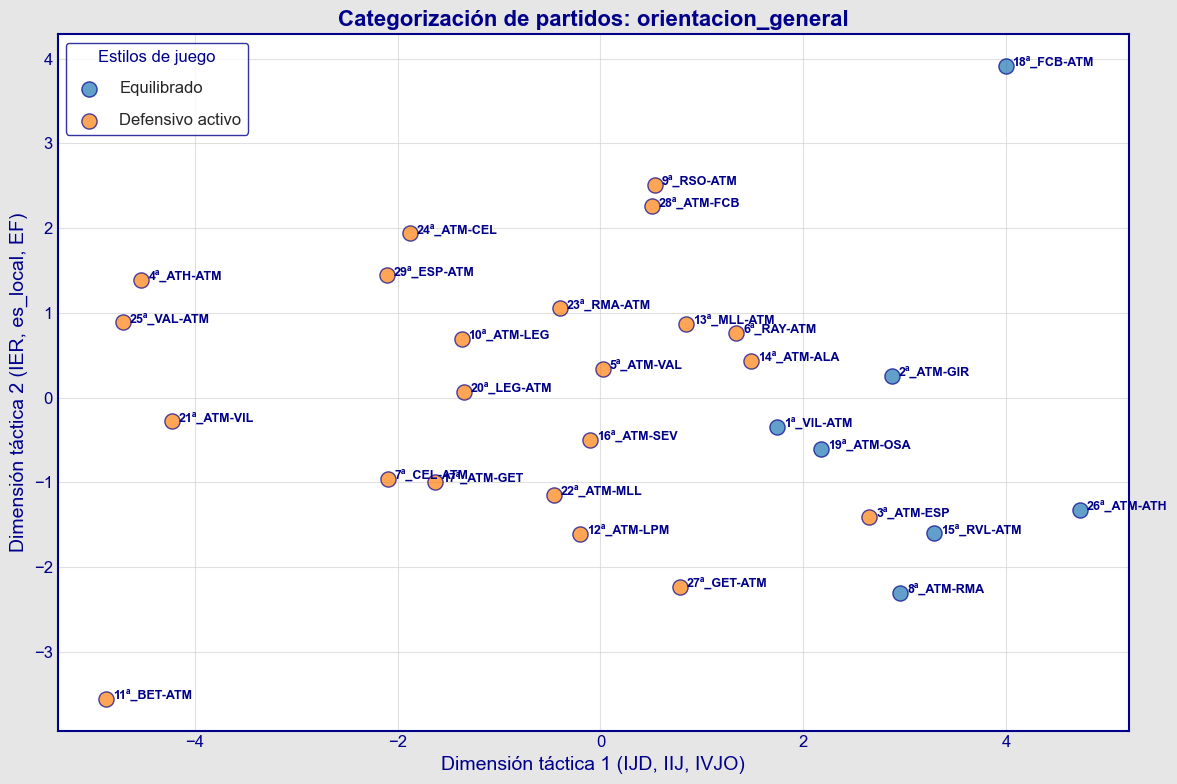

Varianza explicada para fase_ofensiva:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


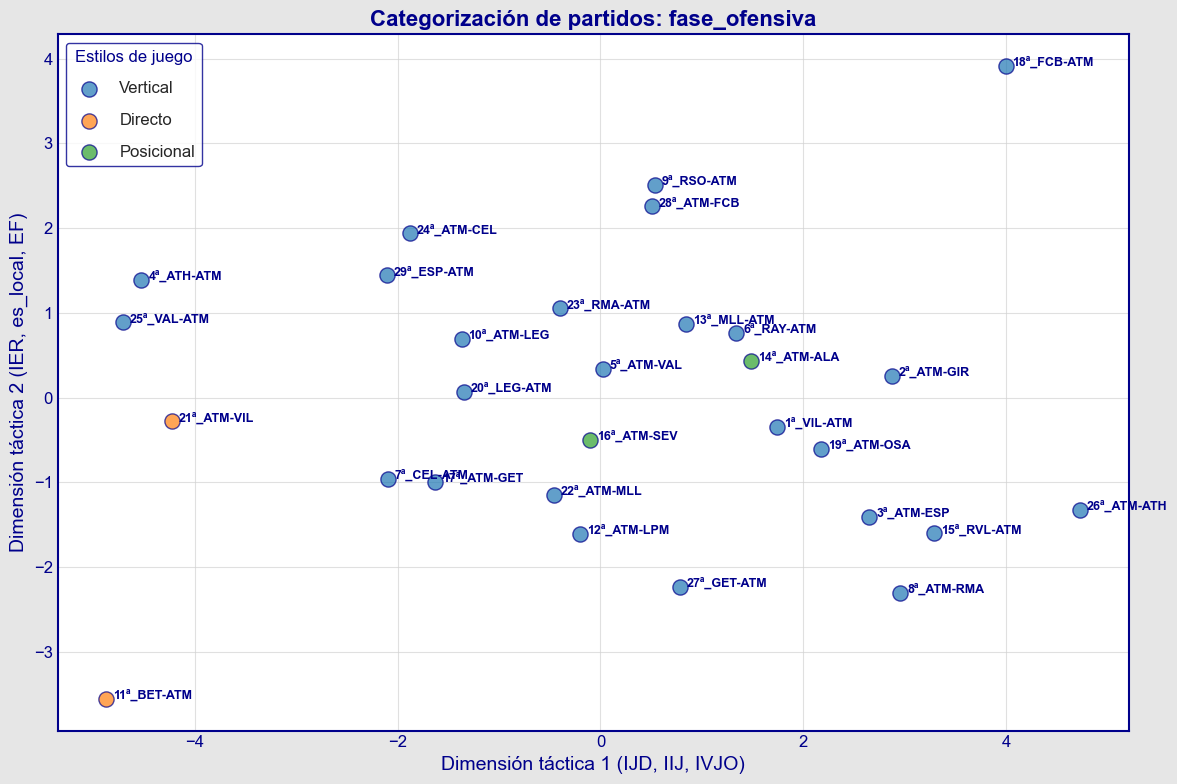

Varianza explicada para patron_ataque:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


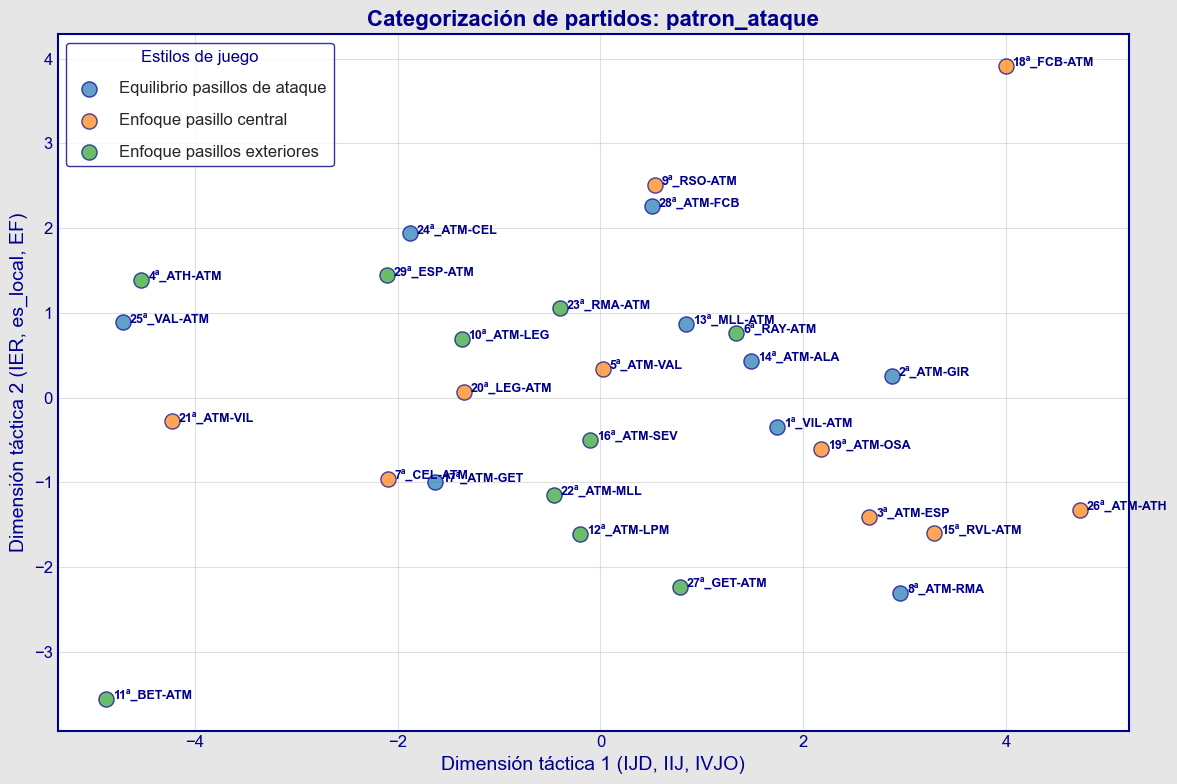

Varianza explicada para intensidad_defensiva:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


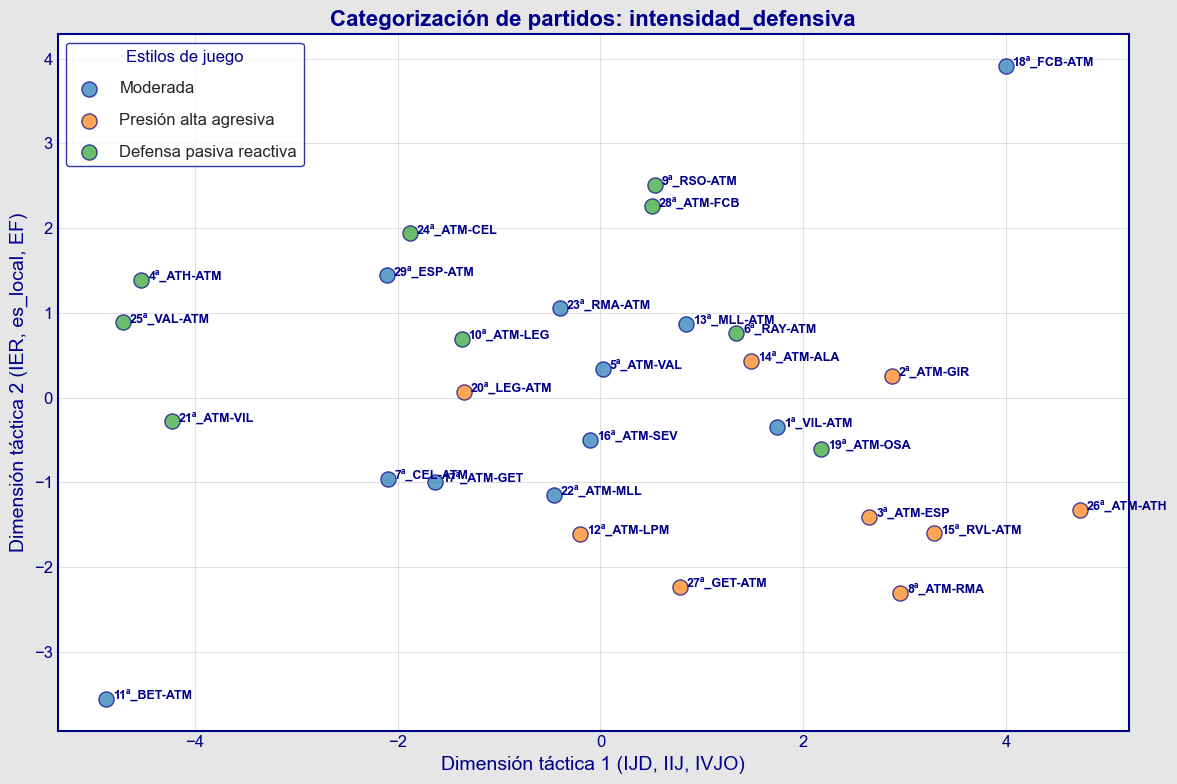

Varianza explicada para altura_bloque:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


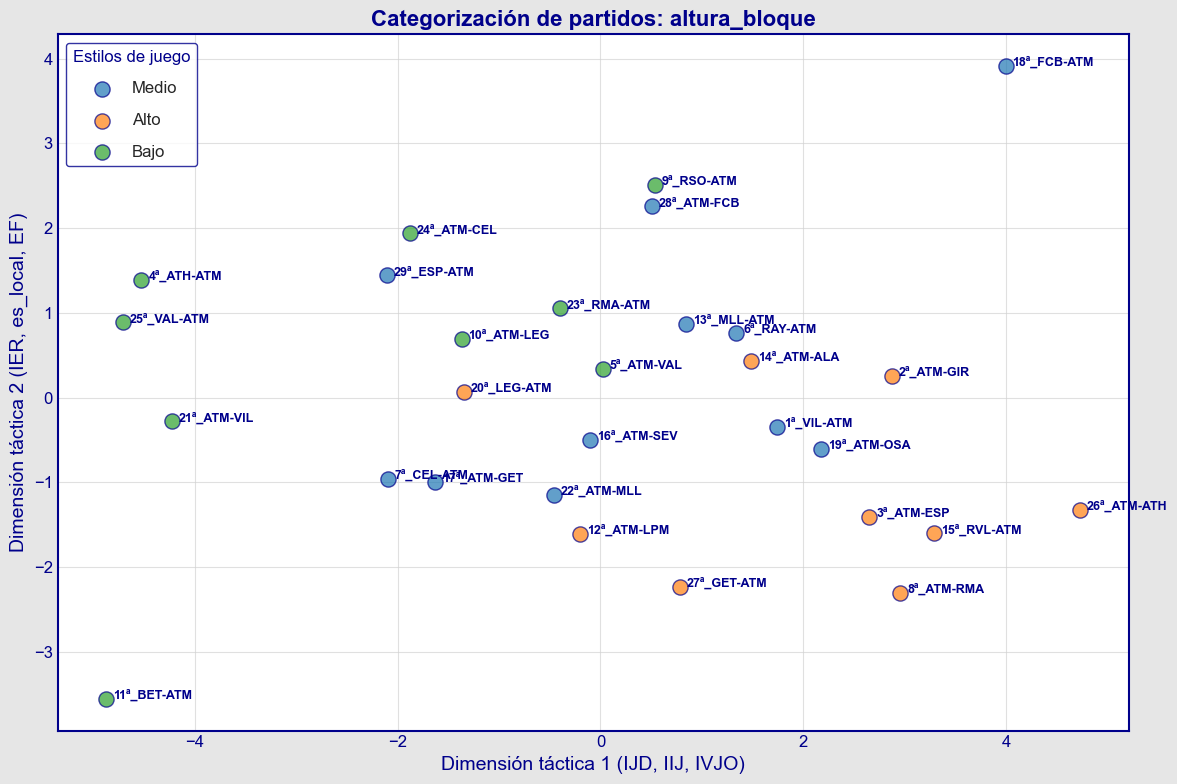

Varianza explicada para tipo_transicion:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


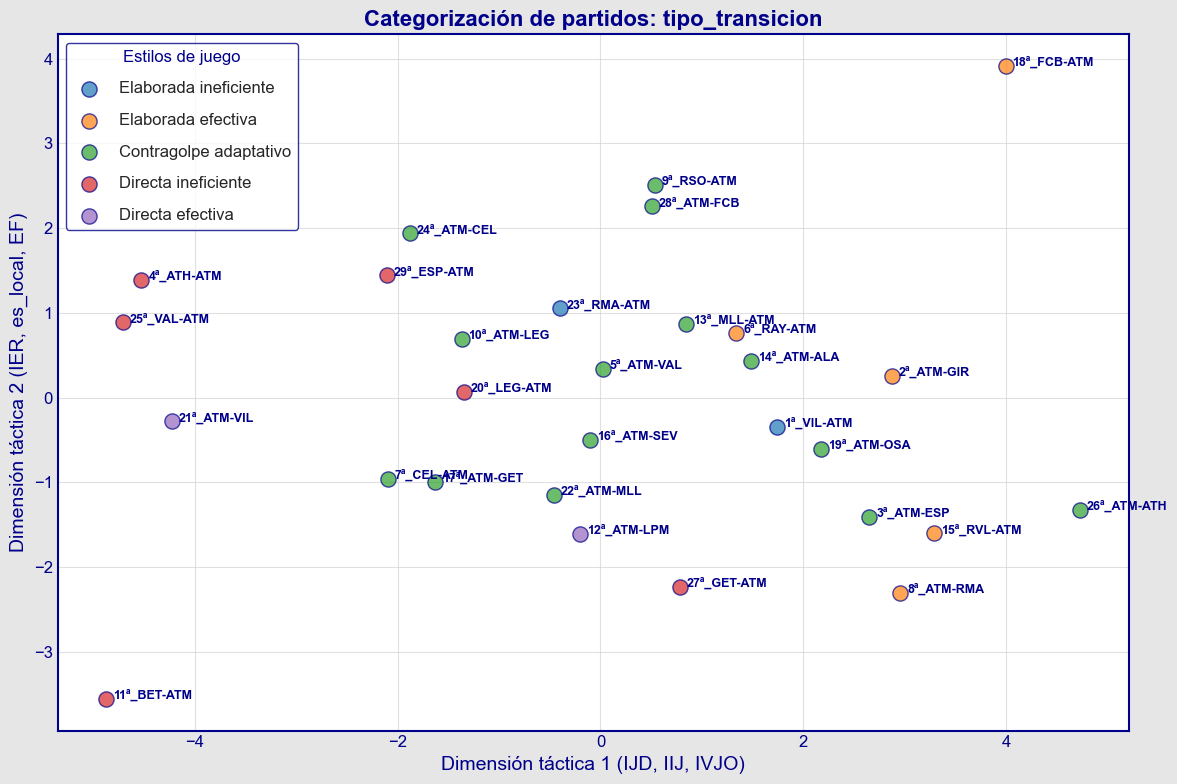

Varianza explicada para estilo_posesion:
Dimensi√≥n 1 (IJD, ...): 36.43%
Dimensi√≥n 2 (IER, ...): 14.24%
Total: 50.67%


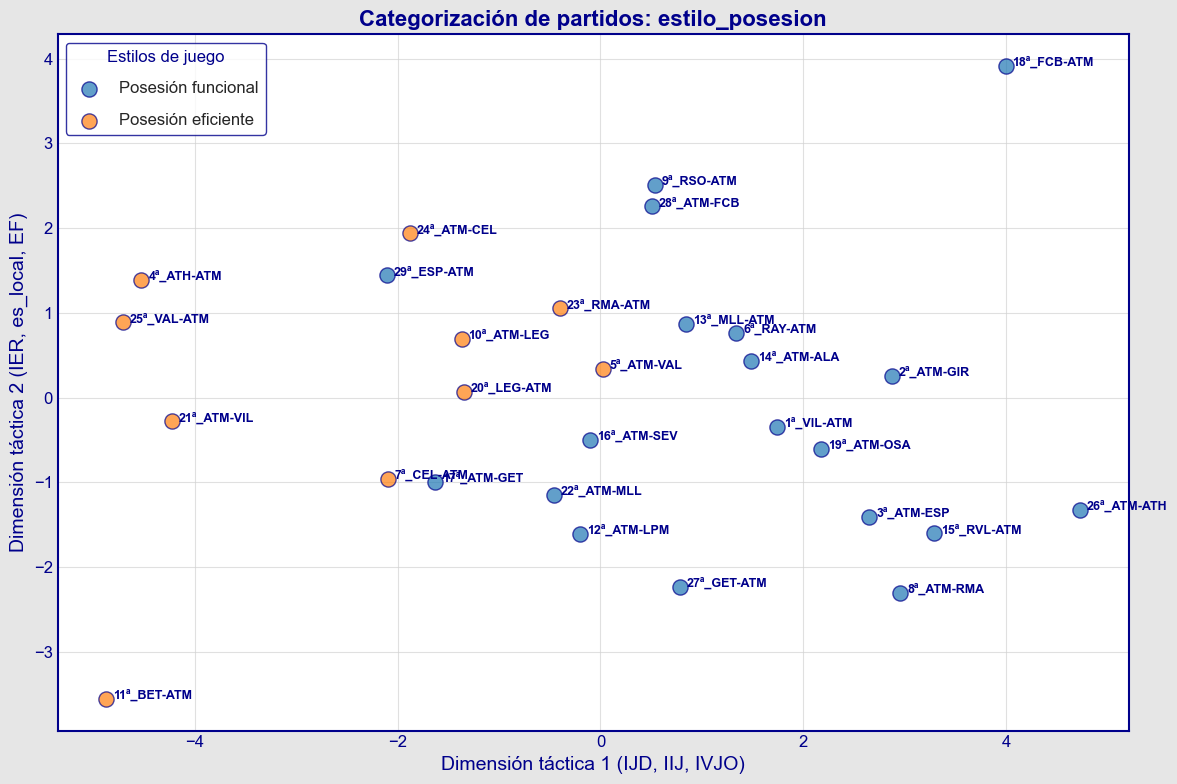


=== RESUMEN DE RENDIMIENTO DE MODELOS ===


In [88]:
# Despu√©s de evaluar todos los modelos
visualizar_categorizacion_partidos()

# Luego contin√∫a con el resumen de rendimiento
print("\n=== RESUMEN DE RENDIMIENTO DE MODELOS ===")

# 6. Despliegue

## 6.1 Preparaci√≥n para Despliegue

In [89]:
def preparar_despliegue():
    """
    Prepara los modelos entrenados para su uso futuro
    """
    print("\n=== PREPARANDO MODELOS PARA DESPLIEGUE ===")
    
    # Crear un nuevo scaler con los datos de entrenamiento para que no se pare
    from sklearn.preprocessing import StandardScaler
    scaler_nuevo = StandardScaler()
    scaler_nuevo.fit(datos_modelo['X_train'])
    
    # Informaci√≥n necesaria para despliegue
    despliegue_info = {
        'modelos': resultados_modelos,
        'scaler': scaler_nuevo,
        'caracteristicas': datos_modelo['X_train'].columns.tolist(),
        'categorias': datos_modelo['categorias'],
        'fecha_entrenamiento': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # Guardar en disco
    import pickle
    with open('data/archivos/modelo_estilos_tacticos.pkl', 'wb') as f:
        pickle.dump(despliegue_info, f)
    
    print("Modelo guardado en la carpeta 'data/archivos/modelo_estilos_tacticos.pkl' para uso futuro")
    print("Este archivo contiene todo lo necesario para hacer predicciones con nuevos datos")
    
    return despliegue_info

In [90]:
# 6. DESPLIEGUE DEL MODELO
print("\n=== 6. DESPLIEGUE DEL MODELO ===")

# Preparar modelos para despliegue
despliegue_info = preparar_despliegue()


=== 6. DESPLIEGUE DEL MODELO ===

=== PREPARANDO MODELOS PARA DESPLIEGUE ===
Modelo guardado en la carpeta 'data/archivos/modelo_estilos_tacticos.pkl' para uso futuro
Este archivo contiene todo lo necesario para hacer predicciones con nuevos datos


## 6.2 Documentaci√≥n de Uso

'''
TODO: Documentar:
- C√≥mo usar los modelos
- Requerimientos
- Limitaciones
- Mantenimiento necesario
'''

6.2 Documentaci√≥n de Uso
C√≥mo usar los modelos
Para utilizar los modelos entrenados en nuevos datos, sigue estos pasos:

Carga de modelos: Utiliza la funci√≥n predecir_estilo_juego junto con el archivo de modelos guardado:

In [ ]:
import pickle

# Cargar modelos entrenados
with open('modelo_estilos_tacticos.pkl', 'rb') as f:
    modelos_info = pickle.load(f)

# Preparar nuevos datos (deben tener las mismas caracter√≠sticas que los datos de entrenamiento)
nuevos_datos = pd.DataFrame({
    'IIJ': [55.2], 'IVJO': [120.5], 'EC': [8.4], 'EF': [45.3], 'IER': [60.1],
    'IV': [22.8], 'IPA': [35.6], 'IJD': [14.3], 'IA': [45.9], 'IDD': [36.2],
    'ICJ': [65.4], 'IEO': [11.2], 'IPT': [67.3], 'IAB': [230.1], 'ICT': [55.4],
    'ICP': [42.2], 'rival_categoria_num': [1], 'es_local': [1]
})

# Realizar predicci√≥n
predicciones = predecir_estilo_juego(nuevos_datos, modelos_info)

# Mostrar resultados
for categoria, resultado in predicciones.items():
    print(f"{categoria}: {resultado['estilo']} (confianza: {resultado['probabilidad']:.2%})")

Interpretaci√≥n de resultados: El sistema proporciona predicciones para todas las categor√≠as de estilo de juego, mostrando tanto la clase asignada como su nivel de confianza.

Requerimientos
Para utilizar este sistema se requiere:

Python 3.7 o superior
Bibliotecas: pandas, numpy, scikit-learn, matplotlib, seaborn
Archivo de modelos entrenados: modelo_estilos_tacticos.pkl
Datos con las mismas caracter√≠sticas utilizadas en el entrenamiento
Para el an√°lisis de nuevos partidos, se necesitan calcular todos los √≠ndices t√°cticos mediante el m√≥dulo de feature engineering

Limitaciones
El sistema presenta las siguientes limitaciones:

Tama√±o de muestra: Los modelos fueron entrenados con un conjunto limitado de datos (29 partidos), lo que puede afectar su capacidad de generalizaci√≥n.
Dependencia contextual: Las predicciones son m√°s fiables cuando el contexto (rival, competici√≥n) es similar a los datos de entrenamiento.
Actualizaci√≥n necesaria: El f√∫tbol y las t√°cticas evolucionan, por lo que los modelos deben reentrenarse peri√≥dicamente con nuevos datos.
Precisi√≥n variable: Algunas categor√≠as como "tipo_transicion" (55.6% de precisi√≥n) son m√°s dif√≠ciles de predecir que otras como "orientacion_general" (100% de precisi√≥n).

Mantenimiento necesario
Para mantener el sistema actualizado y efectivo:

Reentrenamiento peri√≥dico: Incorporar nuevos partidos al conjunto de entrenamiento al menos cada temporada.
Validaci√≥n de caracter√≠sticas: Revisar peri√≥dicamente si los √≠ndices t√°cticos siguen siendo relevantes o si se deben incorporar nuevos.
Ajuste de hiperpar√°metros: Reevaluar los hiperpar√°metros del modelo cuando el conjunto de datos crezca significativamente.
Actualizaci√≥n de categor√≠as: Las etiquetas de estilo pueden necesitar refinamiento a medida que se identifican nuevos patrones t√°cticos.
Pruebas de rendimiento: Evaluar regularmente el rendimiento de los modelos con datos de partidos recientes para detectar posibles degradaciones.

# 7. Conclusiones y Recomendaciones
'''
TODO: Documentar:
- Resultados principales
- Interpretaci√≥n deportiva
- Limitaciones encontradas
- Mejoras propuestas
- Aplicaciones pr√°cticas
'''

7. Conclusiones y Recomendaciones
Resultados principales

Categorizaci√≥n efectiva de estilos: El sistema ha demostrado una alta capacidad para clasificar correctamente los estilos de juego en m√∫ltiples dimensiones t√°cticas, con precisiones entre 55.6% y 100% seg√∫n la categor√≠a.
Indicadores clave identificados: Los √≠ndices ICJ (√çndice de Complejidad de Juego), IIJ (√çndice de Iniciativa de Juego) e IVJO (√çndice de Volumen de Juego Ofensivo) han emergido como los m√°s determinantes para caracterizar el estilo de juego.
Adaptabilidad t√°ctica evidenciada: El an√°lisis revela una clara adaptaci√≥n t√°ctica seg√∫n el contexto de los partidos, con diferentes enfoques dependiendo del rival y la local√≠a.
Patrones t√°cticos claros: Se han identificado tendencias consistentes, particularmente hacia un estilo "Defensivo activo" con transiciones verticales, confirmando observaciones cualitativas sobre el equipo.
Predictibilidad variable: Algunos aspectos t√°cticos como la orientaci√≥n general e intensidad defensiva son altamente predecibles, mientras que otros como el tipo de transici√≥n presentan mayor variabilidad.

Interpretaci√≥n deportiva

Identidad t√°ctica definida: El an√°lisis cuantitativo confirma la existencia de una identidad t√°ctica reconocible, caracterizada por un enfoque defensivo activo con transiciones verticales r√°pidas, coherente con la filosof√≠a tradicionalmente atribuida al equipo.
Flexibilidad estrat√©gica: La variabilidad en ciertos aspectos t√°cticos (patr√≥n de ataque, altura del bloque) sugiere una capacidad adaptativa frente a diferentes rivales y situaciones de juego.
Eficiencia en posesi√≥n: El predominio de la categor√≠a "Posesi√≥n funcional" indica un uso pragm√°tico del bal√≥n orientado a la efectividad m√°s que al control por s√≠ mismo.
Comportamiento contextual: Los √≠ndices t√°cticos muestran claras variaciones seg√∫n la categor√≠a del rival, evidenciando un enfoque estrat√©gico diferenciado frente a equipos de distintos niveles.
Coherencia estructural: La consistencia en ciertos patrones defensivos y transicionales revela una estructura t√°ctica robusta que se mantiene incluso cuando se producen adaptaciones contextuales.

Limitaciones encontradas

Conjunto de datos limitado: Con 29 partidos analizados, el tama√±o muestral es relativamente peque√±o para algunas categor√≠as con m√∫ltiples clases.
Clasificaci√≥n desbalanceada: Algunas categor√≠as presentan un desbalance significativo entre clases, lo que podr√≠a afectar la capacidad predictiva del modelo.
M√©tricas dependientes: Existen correlaciones entre algunos √≠ndices t√°cticos que podr√≠an generar redundancia informativa.
Subjetividad en categorizaci√≥n: La definici√≥n inicial de las categor√≠as de estilo incluye cierto grado de subjetividad que podr√≠a influir en los resultados.
Falta de validaci√≥n externa: El modelo ha sido evaluado con datos de prueba del mismo conjunto, pero no se ha validado con evaluaciones de expertos t√°cticos independientes.

Mejoras propuestas

Ampliaci√≥n del conjunto de datos: Incorporar partidos de m√∫ltiples temporadas para incrementar la robustez estad√≠stica de los modelos.
T√©cnicas para datos desbalanceados: Implementar m√©todos espec√≠ficos como SMOTE o ponderaci√≥n de clases para mejorar la predicci√≥n en categor√≠as desbalanceadas.
Reducci√≥n de dimensionalidad avanzada: Explorar t√©cnicas como t-SNE o UMAP que podr√≠an capturar mejor las relaciones no lineales entre caracter√≠sticas.
Exploraci√≥n de otros algoritmos: Evaluar el rendimiento de modelos como Random Forest, Gradient Boosting o redes neuronales con conjuntos de datos ampliados.
An√°lisis secuencial: Incorporar la dimensi√≥n temporal mediante modelos secuenciales que consideren la evoluci√≥n t√°ctica a lo largo de la temporada.
Validaci√≥n con expertos: Contrastar las categor√≠as y predicciones del modelo con an√°lisis de expertos t√°cticos para validar su precisi√≥n interpretativa.
Incorporaci√≥n de datos contextuales: A√±adir variables como estado del marcador, lesiones clave o condiciones clim√°ticas que pueden influir en las decisiones t√°cticas.

### <u>Aplicaciones pr√°cticas</u>

El sistema de an√°lisis t√°ctico desarrollado ofrece m√∫ltiples aplicaciones pr√°cticas para el cuerpo t√©cnico:

1. **Planificaci√≥n de entrenamientos**: El modelo permite identificar qu√© estilos de juego han resultado m√°s efectivos contra diferentes tipos de rivales, orientando la preparaci√≥n semanal.

2. **An√°lisis de rendimiento**: La capacidad de categorizar autom√°ticamente el estilo adoptado en cada partido facilita el an√°lisis post-partido y la evaluaci√≥n de la ejecuci√≥n t√°ctica.

3. **Selecci√≥n de estrategia**: Antes de enfrentarse a un rival, el an√°lisis hist√≥rico puede sugerir qu√© enfoque t√°ctico ha sido m√°s exitoso contra equipos similares.

4. **Detecci√≥n de patrones emergentes**: El sistema puede identificar cambios en el patr√≥n de juego a lo largo de la temporada, permitiendo ajustes proactivos.

5. **Adaptaci√≥n al rival**: Mediante la caracterizaci√≥n del estilo de juego del pr√≥ximo oponente, se pueden ajustar las t√°cticas espec√≠ficamente para contrarrestar sus fortalezas.

A continuaci√≥n se muestra una demostraci√≥n del sistema, donde se predice el perfil t√°ctico completo para un partido de ejemplo:

In [ ]:
def predecir_estilo_juego(nuevos_datos, modelos_info=None):
    """
    Predice el estilo de juego para nuevos datos
    
    Args:
        nuevos_datos (pd.DataFrame): Datos con caracter√≠sticas t√°cticas
        modelos_info (dict): Informaci√≥n de modelos y scaler (opcional)
    
    Returns:
        dict: Predicciones para cada categor√≠a de estilo
    """
    print("\n=== PREDICCI√ìN DE ESTILO DE JUEGO ===")
    
    # Si no se proporciona info de modelos, intentar cargar del archivo
    if modelos_info is None:
        import pickle
        try:
            with open('modelo_estilos_tacticos.pkl', 'rb') as f:
                modelos_info = pickle.load(f)
            print("Informaci√≥n de modelos cargada desde archivo")
        except:
            print("Error: No se pudo cargar la informaci√≥n de modelos")
            return None
        
    # Extraer componentes
    modelos = modelos_info['modelos']
    scaler = modelos_info['scaler']
    
    # Verificar que las columnas coinciden
    for col in modelos_info['caracteristicas']:
        if col not in nuevos_datos.columns:
            print(f"Error: Falta la columna '{col}' en los nuevos datos")
            return None
    
    # Normalizar datos
    nuevos_datos_norm = scaler.transform(nuevos_datos[modelos_info['caracteristicas']])
    
    # Realizar predicciones para cada categor√≠a
    predicciones = {}
    
    for categoria, info_modelo in modelos.items():
        # Aplicar selector de caracter√≠sticas
        X_reducido = info_modelo['selector'].transform(nuevos_datos_norm)
        
        # Predecir
        modelo = info_modelo['modelo']
        pred_clase = modelo.predict(X_reducido)[0]
        
        # Obtener probabilidades si es posible
        try:
            probs = modelo.predict_proba(X_reducido)[0]
            prob_dict = {clase: float(prob) for clase, prob in zip(info_modelo['clases'], probs)}
            confianza = prob_dict[pred_clase]
        except:
            confianza = None
            prob_dict = None
        
        # Guardar resultados
        predicciones[categoria] = {
            'estilo': pred_clase,
            'confianza': confianza,
            'probabilidades': prob_dict
        }
    
    return predicciones

# Demostrar uso con un ejemplo
print("\n=== DEMOSTRACI√ìN DEL SISTEMA ===")
# Tomar un ejemplo de los datos de prueba
ejemplo = datos_modelo['X_test'].iloc[0:1]
print(f"Datos de ejemplo:\n{ejemplo}")

# Realizar predicci√≥n
prediccion = predecir_estilo_juego(ejemplo, despliegue_info)

# Mostrar resultados
print("\nEstilo de juego predicho:")
for categoria, resultado in prediccion.items():
    if resultado['confianza']:
        print(f"  {categoria}: {resultado['estilo']} (confianza: {resultado['confianza']:.2%})")
    else:
        print(f"  {categoria}: {resultado['estilo']}")

# Mostrar el perfil t√°ctico completo
print("\nPerfil t√°ctico completo:")
for categoria, resultado in prediccion.items():
    print(f"  - {categoria}: {resultado['estilo']}")



# Esta capacidad de predicci√≥n permite aplicar el modelo a partidos futuros sin necesidad de un an√°lisis manual exhaustivo, agilizando la preparaci√≥n t√°ctica del equipo.


## <u>Funci√≥n ejecuci√≥n de Script</u>

In [ ]:
if __name__ == "__main__":
    # Ejecuci√≥n principal
    print("Iniciando an√°lisis t√°ctico del Atl√©tico de Madrid...")
    
    # Cargar datos
    print("\n1. Cargando datos...")
    datos_fuente = cargar_datos()
    
    # Limpiar datos
    print("\n2. Limpiando datos...")
    datos_limpios = limpiar_datos(datos_fuente)
    
    # Crear caracter√≠sticas
    print("\n3. Realizando feature engineering...")
    df_indices = crear_features(datos_limpios)
    
    # Preparar datos para modelado
    print("\n4. Preparando datos para modelado...")
    datos_modelo = preparar_datos_modelado(df_indices)
    
    # Entrenar modelo inicial para una categor√≠a
    print("\n5. Entrenando modelo para orientacion_general...")
    categoria = datos_modelo['categorias'][0]
    X_train = datos_modelo['X_train']
    y_train = datos_modelo['y_train_dict'][categoria]
    modelo_resultado = entrenar_modelo_svm(X_train, y_train)
    modelo_entrenado = modelo_resultado['modelo']
    
    # Evaluar modelo inicial
    print("\n6. Evaluando modelo inicial...")
    X_test = datos_modelo['X_test']
    y_test = datos_modelo['y_test_dict'][categoria]
    nombres_caracteristicas = X_train.columns.tolist()
    visualizar_matriz_confusion(modelo_entrenado, X_test, y_test, modelo_resultado['clases'])
    visualizar_importancia_caracteristicas(modelo_entrenado, nombres_caracteristicas)
    
    # Reducci√≥n de dimensionalidad
    print("\n7. Aplicando reducci√≥n de dimensionalidad...")
    from sklearn.feature_selection import SelectKBest, f_classif
    selector = SelectKBest(f_classif, k=7)
    X_train_reducido = selector.fit_transform(X_train, y_train)
    X_test_reducido = selector.transform(X_test)
    caracteristicas_seleccionadas = [nombre for i, nombre in enumerate(nombres_caracteristicas) if selector.get_support()[i]]
    print(f"Caracter√≠sticas seleccionadas: {caracteristicas_seleccionadas}")
    
    # Evaluar todos los modelos
    print("\n8. Evaluando todos los modelos...")
    resultados_modelos = {}
    for cat in datos_modelo['categorias']:
        print(f"\n--- Evaluando modelo para '{cat}' ---")
        X_train = datos_modelo['X_train']
        y_train = datos_modelo['y_train_dict'][cat]
        X_test = datos_modelo['X_test']
        y_test = datos_modelo['y_test_dict'][cat]
        
        # Selecci√≥n de caracter√≠sticas
        selector = SelectKBest(f_classif, k=7)
        X_train_reducido = selector.fit_transform(X_train, y_train)
        X_test_reducido = selector.transform(X_test)
        
        # Entrenamiento
        resultado = entrenar_modelo_svm(pd.DataFrame(X_train_reducido), y_train)
        
        # Evaluaci√≥n
        modelo = resultado['modelo']
        visualizar_matriz_confusion(modelo, X_test_reducido, y_test, resultado['clases'])
        
        # Guardar resultado
        resultados_modelos[cat] = {
            'modelo': modelo,
            'selector': selector,
            'caracteristicas': [nombre for i, nombre in enumerate(X_train.columns) if selector.get_support()[i]],
            'clases': resultado['clases']
        }
    
    # Visualizar categorizaci√≥n
    print("\n9. Visualizando categorizaci√≥n de partidos...")
    visualizar_categorizacion_partidos()
    
    # Preparar despliegue
    print("\n10. Preparando modelos para despliegue...")
    despliegue_info = preparar_despliegue()
    
    # Demostraci√≥n del sistema
    print("\n11. Demostrando el sistema...")
    ejemplo = datos_modelo['X_test'].iloc[0:1]
    prediccion = predecir_estilo_juego(ejemplo, despliegue_info)
    
    print("\nPerfil t√°ctico predicho:")
    for cat, resultado in prediccion.items():
        print(f"  - {cat}: {resultado['estilo']}")
    
    print("\nAn√°lisis t√°ctico completado con √©xito.")